In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
import numpy as np
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import glob
import os
import torch.optim as optim
import matplotlib.pyplot as plt

class GCN(nn.Module):
    def __init__(self, input_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, 32)
        self.bn1 = nn.BatchNorm1d(32)
        
        self.conv2 = GCNConv(32, 64)
        self.bn2 = nn.BatchNorm1d(64)
        
        self.conv3 = GCNConv(64, 128)
        self.bn3 = nn.BatchNorm1d(128)

        self.dropout_gcn = nn.Dropout(0.2)
        self.dropout = nn.Dropout(0.6)
        
        self.fc1 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 1)

    def forward(self, data):
        x, edge_index, edge_weight, batch = data.x, data.edge_index, data.edge_attr, data.batch

        x = self.conv1(x, edge_index, edge_weight)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv2(x, edge_index, edge_weight)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        x = self.conv3(x, edge_index, edge_weight)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.dropout_gcn(x)

        # Global pooling to get graph-level representation
        x = global_mean_pool(x, batch)

        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.out(x)

        return x
    
def organize_graph_and_add_weight(file_path, label):
    data = np.load(file_path, allow_pickle=True).item()
    inverse_distance = data['inverse_distance']
    encoded_matrix = data['encoded_matrix']

    x = torch.tensor(encoded_matrix, dtype=torch.float32)
    adj = torch.tensor(inverse_distance, dtype=torch.float32)

    # Normalize adjacency (row-normalize)
    #adj = adj / (adj.sum(dim=1, keepdim=True) + 1e-8)

    # Create edge_index and edge weights
    edge_index = (adj > 0).nonzero(as_tuple=False).t()
    edge_weight = adj[adj > 0]

    y = torch.tensor([label], dtype=torch.float32)
    
    return Data(x=x, edge_index=edge_index, edge_attr=edge_weight, y=y)


In [2]:
def train_model(model, dataloader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0

    for batch in dataloader:
        batch = batch.to(device)

        optimizer.zero_grad()
        outputs = model(batch)
        outputs = outputs.view(-1)  # shape: [batch_size]
        loss = criterion(outputs, batch.y.view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        running_loss += loss.item() * batch.num_graphs
        probs = torch.sigmoid(outputs)
        preds = probs >= 0.5
        correct += (preds == batch.y.view(-1).bool()).sum().item()
        total += batch.num_graphs

    epoch_loss = running_loss / total
    accuracy = correct / total
    return epoch_loss, accuracy

def validate_model(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    total = 0
    correct = 0

    with torch.no_grad():
        for batch in dataloader:
            batch = batch.to(device)
            outputs = model(batch)
            outputs = outputs.view(-1)
            loss = criterion(outputs, batch.y.view(-1))
            running_loss += loss.item() * batch.num_graphs
            probs = torch.sigmoid(outputs)
            preds = probs >= 0.5
            correct += (preds == batch.y.view(-1).bool()).sum().item()
            total += batch.num_graphs

    validation_loss = running_loss / total
    accuracy = correct / total
    return validation_loss, accuracy

In [3]:
# Create a dictionary with file names as keys and label + tensor grid as values
positive_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp2/PositiveWithoutSpies/*.npy')
validation_grids = glob.glob('../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp2/Validation_Set/*.npy')

positive_graphs = []
validation_graphs = []

for file in positive_grids:
    positive_graphs.append(organize_graph_and_add_weight(file, 1))

positive_validation_count = 0
unlabeled_validation_count = 0

for file in validation_grids:
    # Label as negative if "-f1" to "-f5" is in the filename
    if any(f"-f{i}" in file for i in range(1, 6)):
        label = 0
        unlabeled_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))
    else:
        label = 1
        positive_validation_count += 1
        validation_graphs.append(organize_graph_and_add_weight(file, label))

print("In validation directory there are", positive_validation_count, "positives and", unlabeled_validation_count, "fragments")

k = 50
bins = []
for i in range(1, k + 1):
    bin = positive_graphs.copy()
    subset_grid = glob.glob(f'../../../Data/SplitData/Cholesterol/cholesterol-separate-graphs-5A_exp2/k_subsets/subset_{i}/*.npy')  # Adjust path as needed
    for file in subset_grid:
        bin.append(organize_graph_and_add_weight(file, 0))
    
    bins.append(bin)

for i, bin in enumerate(bins):
    pos = sum(1 for g in bin if g.y.item() == 1)
    neg = sum(1 for g in bin if g.y.item() == 0)
    print(f"Bin {i+1}: Positives = {pos}, Negatives = {neg}")


In validation directory there are 77 positives and 277 fragments
Bin 1: Positives = 385, Negatives = 385
Bin 2: Positives = 385, Negatives = 385
Bin 3: Positives = 385, Negatives = 385
Bin 4: Positives = 385, Negatives = 385
Bin 5: Positives = 385, Negatives = 385
Bin 6: Positives = 385, Negatives = 385
Bin 7: Positives = 385, Negatives = 385
Bin 8: Positives = 385, Negatives = 385
Bin 9: Positives = 385, Negatives = 385
Bin 10: Positives = 385, Negatives = 385
Bin 11: Positives = 385, Negatives = 385
Bin 12: Positives = 385, Negatives = 385
Bin 13: Positives = 385, Negatives = 385
Bin 14: Positives = 385, Negatives = 385
Bin 15: Positives = 385, Negatives = 385
Bin 16: Positives = 385, Negatives = 385
Bin 17: Positives = 385, Negatives = 385
Bin 18: Positives = 385, Negatives = 385
Bin 19: Positives = 385, Negatives = 385
Bin 20: Positives = 385, Negatives = 385
Bin 21: Positives = 385, Negatives = 385
Bin 22: Positives = 385, Negatives = 385
Bin 23: Positives = 385, Negatives = 385
B

In [4]:
def plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates):
    # Plot Training Loss vs Validation Loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(1, len(validation_losses) + 1), validation_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss vs Validation Loss')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Validation Accuracy
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(validation_accuracies) + 1), validation_accuracies, label='Validation Accuracy', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    # Plot Learning Rate
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(learning_rates) + 1), learning_rates, label='Learning Rates', color='green')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

Training on bin 1/50
Bin 1, Epoch 1/4000, Train Loss: 0.7058, Validation Loss: 0.6630,  Accuracy: 0.7825, LR: 0.000010
Bin 1, Epoch 101/4000, Train Loss: 0.6054, Validation Loss: 0.6365,  Accuracy: 0.8277, LR: 0.000010
Bin 1, Epoch 201/4000, Train Loss: 0.5287, Validation Loss: 0.6041,  Accuracy: 0.8446, LR: 0.000010
Bin 1, Epoch 301/4000, Train Loss: 0.4838, Validation Loss: 0.5220,  Accuracy: 0.8842, LR: 0.000010
Bin 1, Epoch 401/4000, Train Loss: 0.4539, Validation Loss: 0.4949,  Accuracy: 0.8785, LR: 0.000010
Bin 1, Epoch 501/4000, Train Loss: 0.4240, Validation Loss: 0.4896,  Accuracy: 0.8785, LR: 0.000010
Bin 1, Epoch 601/4000, Train Loss: 0.3946, Validation Loss: 0.4729,  Accuracy: 0.8955, LR: 0.000010
Bin 1, Epoch 701/4000, Train Loss: 0.3945, Validation Loss: 0.4369,  Accuracy: 0.9096, LR: 0.000010
Bin 1, Epoch 801/4000, Train Loss: 0.3628, Validation Loss: 0.4177,  Accuracy: 0.9181, LR: 0.000009
Bin 1, Epoch 901/4000, Train Loss: 0.3640, Validation Loss: 0.4412,  Accuracy: 0.

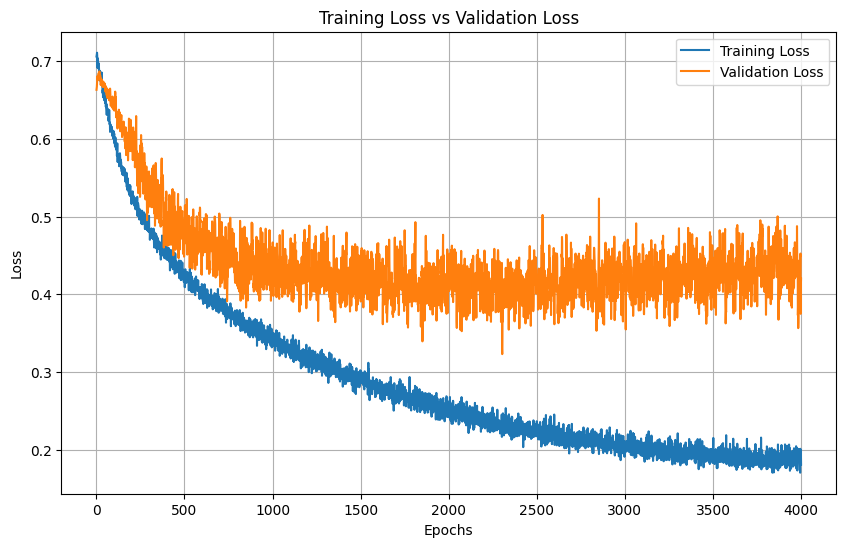

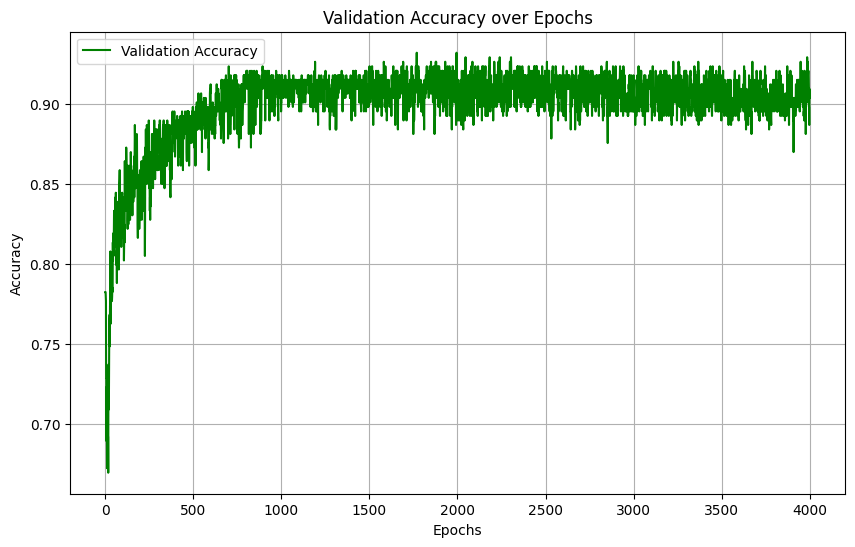

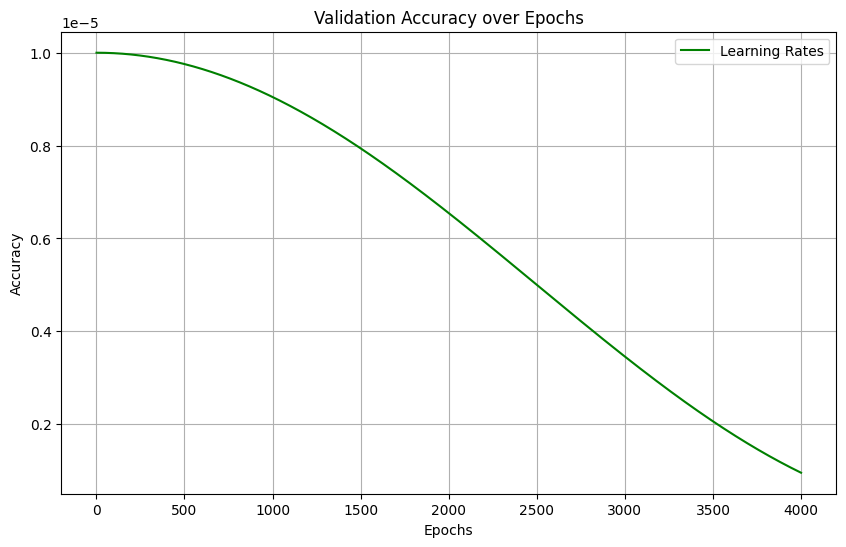

Model for bin 1 saved to GCNModels-5A_exp2/model_bin_1.pth
Training on bin 2/50
Bin 2, Epoch 1/4000, Train Loss: 0.7147, Validation Loss: 0.6915,  Accuracy: 0.7797, LR: 0.000010
Bin 2, Epoch 101/4000, Train Loss: 0.6422, Validation Loss: 0.6507,  Accuracy: 0.8362, LR: 0.000010
Bin 2, Epoch 201/4000, Train Loss: 0.5773, Validation Loss: 0.5940,  Accuracy: 0.8757, LR: 0.000010
Bin 2, Epoch 301/4000, Train Loss: 0.5447, Validation Loss: 0.5441,  Accuracy: 0.8814, LR: 0.000010
Bin 2, Epoch 401/4000, Train Loss: 0.5165, Validation Loss: 0.4886,  Accuracy: 0.8870, LR: 0.000010
Bin 2, Epoch 501/4000, Train Loss: 0.4817, Validation Loss: 0.4563,  Accuracy: 0.8842, LR: 0.000010
Bin 2, Epoch 601/4000, Train Loss: 0.4681, Validation Loss: 0.4031,  Accuracy: 0.9011, LR: 0.000010
Bin 2, Epoch 701/4000, Train Loss: 0.4357, Validation Loss: 0.3620,  Accuracy: 0.9096, LR: 0.000010
Bin 2, Epoch 801/4000, Train Loss: 0.4103, Validation Loss: 0.3307,  Accuracy: 0.9068, LR: 0.000009
Bin 2, Epoch 901/4000,

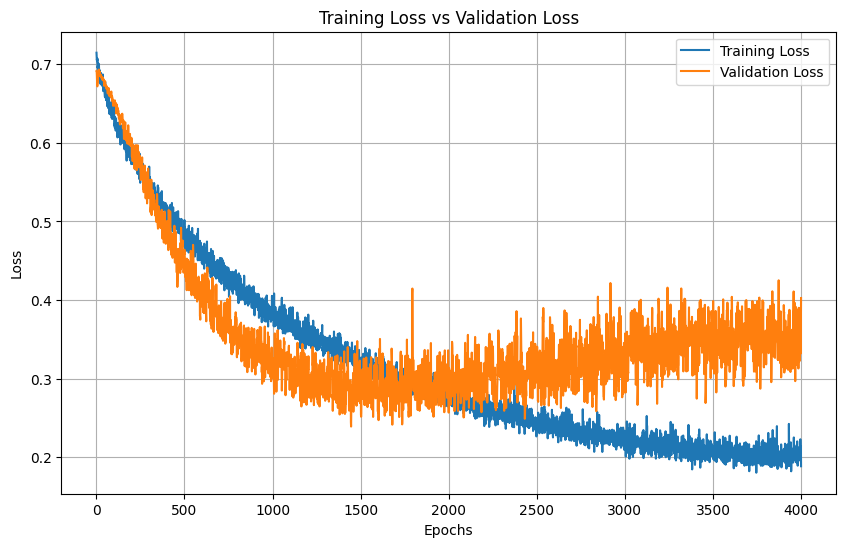

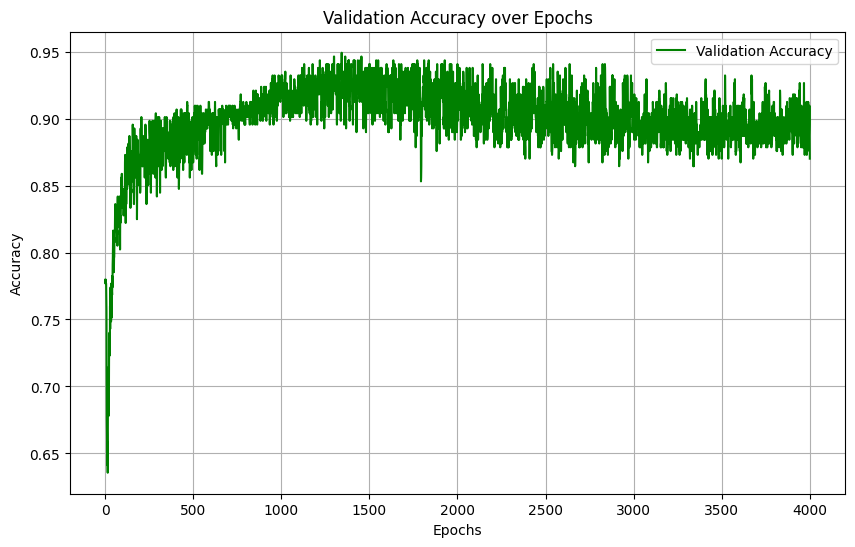

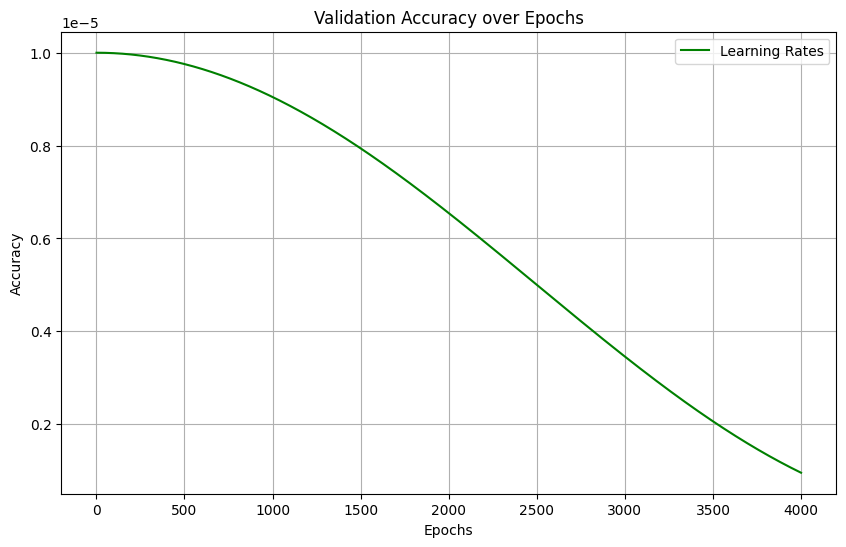

Model for bin 2 saved to GCNModels-5A_exp2/model_bin_2.pth
Training on bin 3/50
Bin 3, Epoch 1/4000, Train Loss: 0.7063, Validation Loss: 0.7049,  Accuracy: 0.2175, LR: 0.000010
Bin 3, Epoch 101/4000, Train Loss: 0.6499, Validation Loss: 0.6805,  Accuracy: 0.6751, LR: 0.000010
Bin 3, Epoch 201/4000, Train Loss: 0.6119, Validation Loss: 0.6247,  Accuracy: 0.8164, LR: 0.000010
Bin 3, Epoch 301/4000, Train Loss: 0.5674, Validation Loss: 0.5714,  Accuracy: 0.8475, LR: 0.000010
Bin 3, Epoch 401/4000, Train Loss: 0.5169, Validation Loss: 0.5058,  Accuracy: 0.8729, LR: 0.000010
Bin 3, Epoch 501/4000, Train Loss: 0.4851, Validation Loss: 0.4534,  Accuracy: 0.8785, LR: 0.000010
Bin 3, Epoch 601/4000, Train Loss: 0.4490, Validation Loss: 0.4193,  Accuracy: 0.8814, LR: 0.000010
Bin 3, Epoch 701/4000, Train Loss: 0.4323, Validation Loss: 0.3746,  Accuracy: 0.8955, LR: 0.000010
Bin 3, Epoch 801/4000, Train Loss: 0.4062, Validation Loss: 0.3465,  Accuracy: 0.8955, LR: 0.000009
Bin 3, Epoch 901/4000,

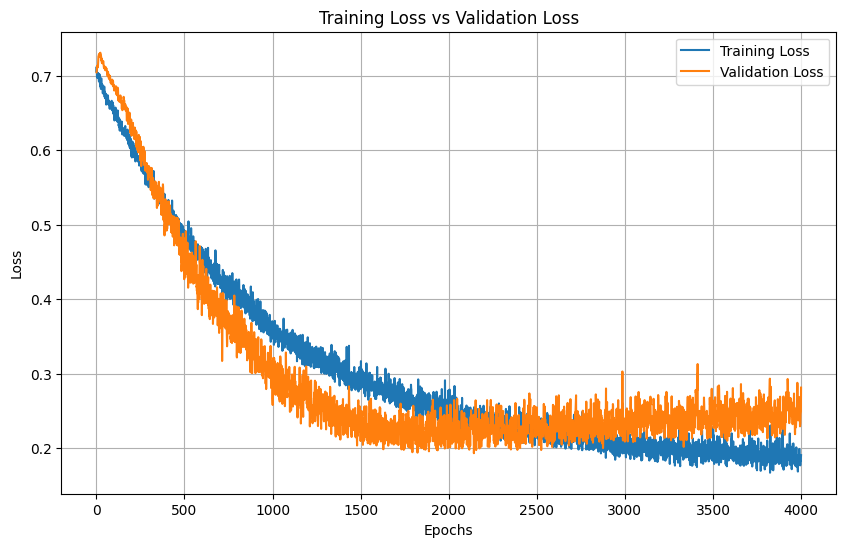

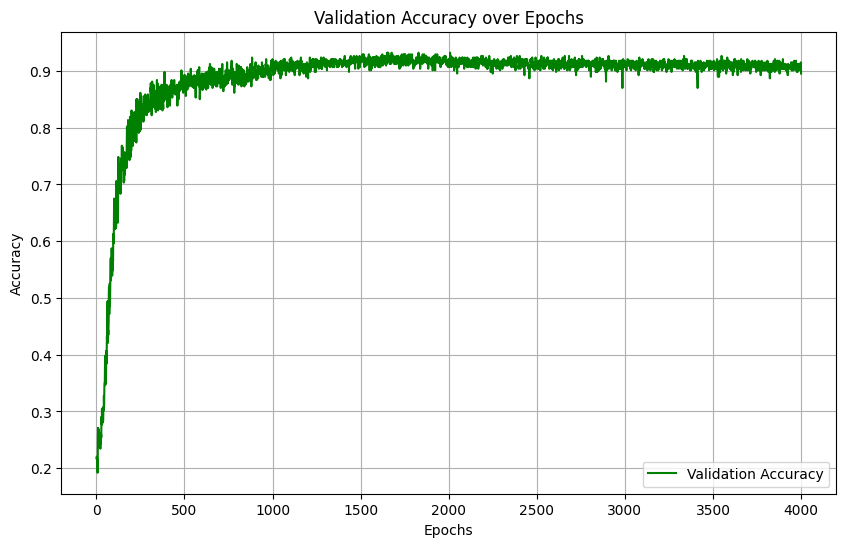

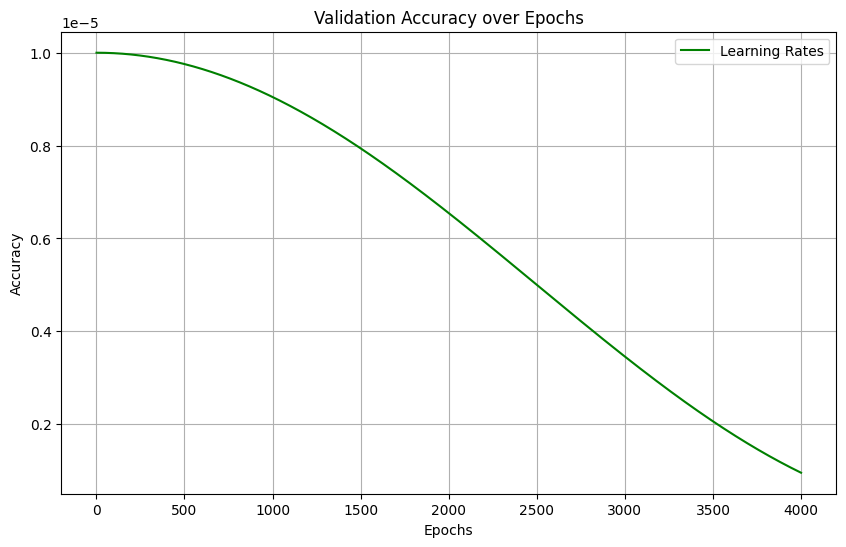

Model for bin 3 saved to GCNModels-5A_exp2/model_bin_3.pth
Training on bin 4/50
Bin 4, Epoch 1/4000, Train Loss: 0.7148, Validation Loss: 0.7196,  Accuracy: 0.2175, LR: 0.000010
Bin 4, Epoch 101/4000, Train Loss: 0.6459, Validation Loss: 0.6645,  Accuracy: 0.6582, LR: 0.000010
Bin 4, Epoch 201/4000, Train Loss: 0.5854, Validation Loss: 0.5967,  Accuracy: 0.7825, LR: 0.000010
Bin 4, Epoch 301/4000, Train Loss: 0.5432, Validation Loss: 0.5254,  Accuracy: 0.8220, LR: 0.000010
Bin 4, Epoch 401/4000, Train Loss: 0.4877, Validation Loss: 0.4673,  Accuracy: 0.8390, LR: 0.000010
Bin 4, Epoch 501/4000, Train Loss: 0.4556, Validation Loss: 0.4304,  Accuracy: 0.8446, LR: 0.000010
Bin 4, Epoch 601/4000, Train Loss: 0.4162, Validation Loss: 0.3676,  Accuracy: 0.8729, LR: 0.000010
Bin 4, Epoch 701/4000, Train Loss: 0.3779, Validation Loss: 0.3188,  Accuracy: 0.9040, LR: 0.000010
Bin 4, Epoch 801/4000, Train Loss: 0.3703, Validation Loss: 0.3027,  Accuracy: 0.9068, LR: 0.000009
Bin 4, Epoch 901/4000,

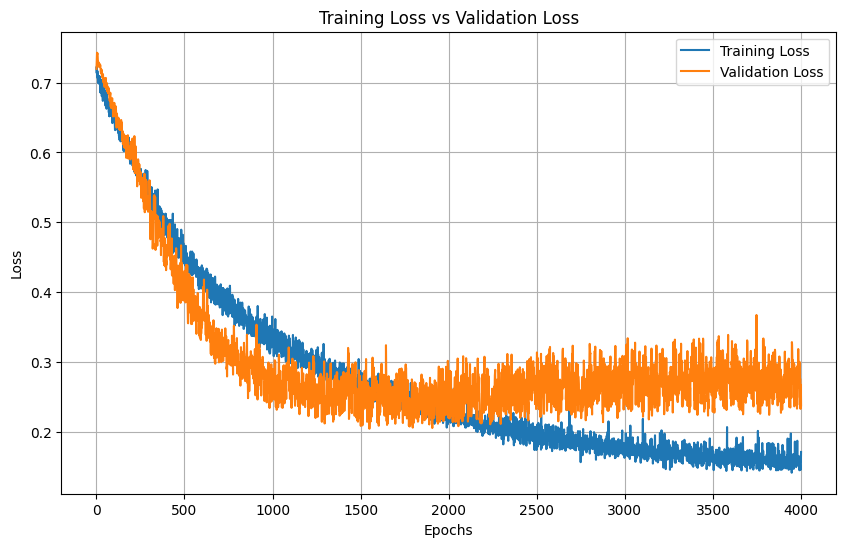

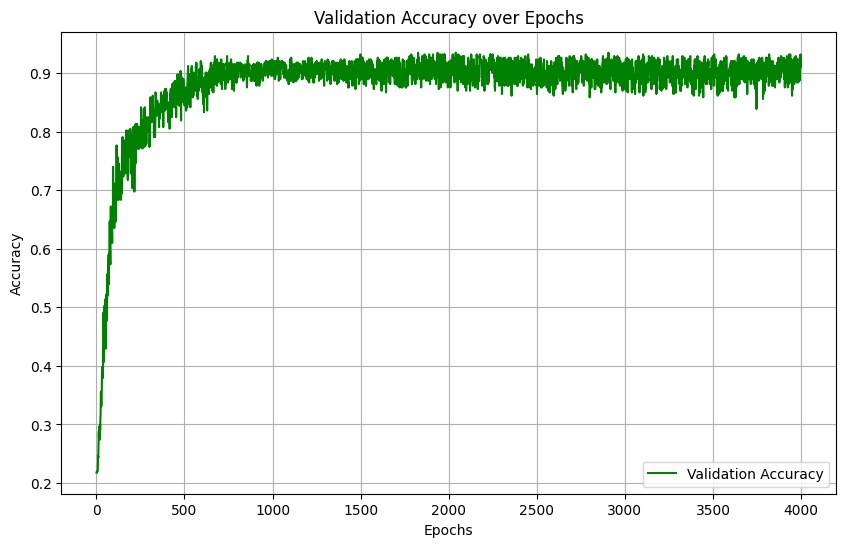

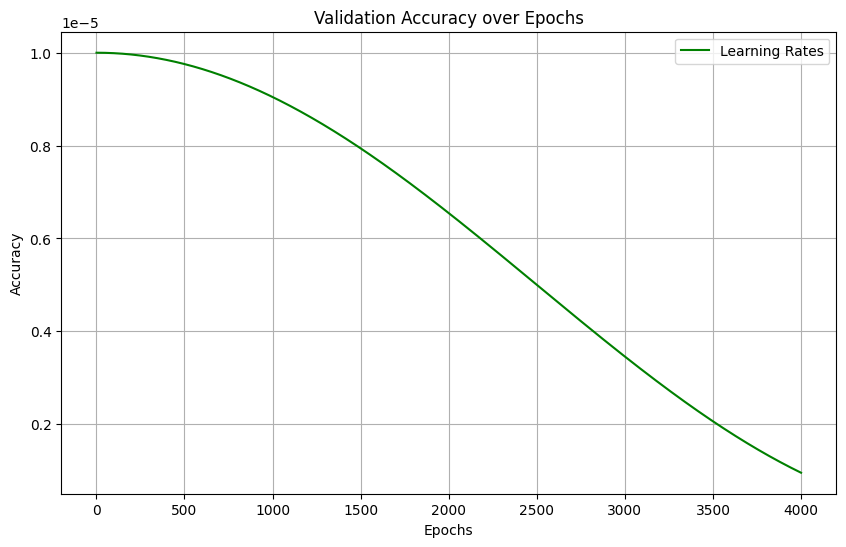

Model for bin 4 saved to GCNModels-5A_exp2/model_bin_4.pth
Training on bin 5/50
Bin 5, Epoch 1/4000, Train Loss: 0.7213, Validation Loss: 0.6731,  Accuracy: 0.7825, LR: 0.000010
Bin 5, Epoch 101/4000, Train Loss: 0.6263, Validation Loss: 0.6077,  Accuracy: 0.8672, LR: 0.000010
Bin 5, Epoch 201/4000, Train Loss: 0.5601, Validation Loss: 0.5359,  Accuracy: 0.8983, LR: 0.000010
Bin 5, Epoch 301/4000, Train Loss: 0.4917, Validation Loss: 0.4867,  Accuracy: 0.9011, LR: 0.000010
Bin 5, Epoch 401/4000, Train Loss: 0.4430, Validation Loss: 0.4433,  Accuracy: 0.9011, LR: 0.000010
Bin 5, Epoch 501/4000, Train Loss: 0.4172, Validation Loss: 0.3858,  Accuracy: 0.9124, LR: 0.000010
Bin 5, Epoch 601/4000, Train Loss: 0.3915, Validation Loss: 0.3628,  Accuracy: 0.9153, LR: 0.000010
Bin 5, Epoch 701/4000, Train Loss: 0.3638, Validation Loss: 0.3640,  Accuracy: 0.9209, LR: 0.000010
Bin 5, Epoch 801/4000, Train Loss: 0.3822, Validation Loss: 0.3537,  Accuracy: 0.9209, LR: 0.000009
Bin 5, Epoch 901/4000,

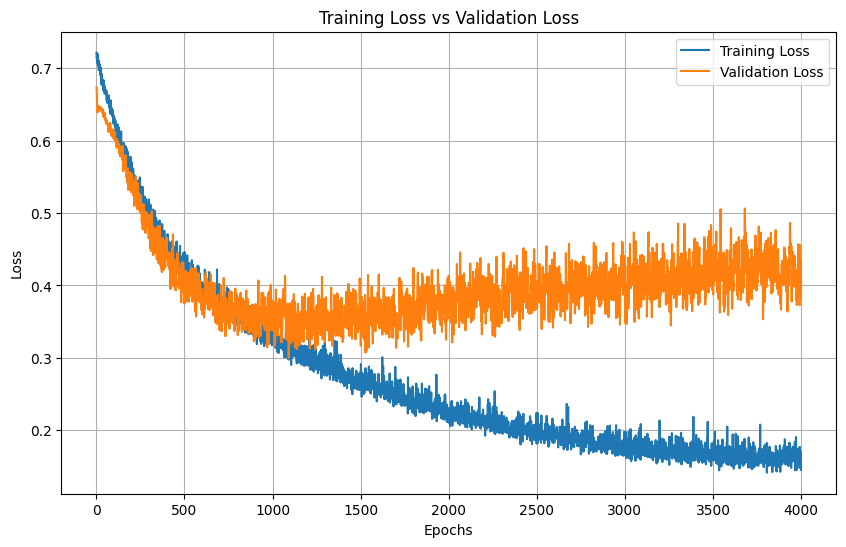

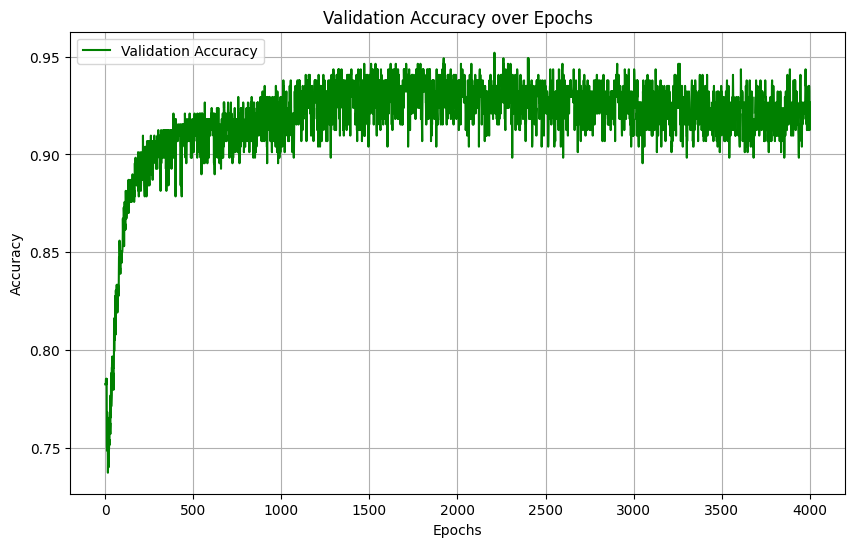

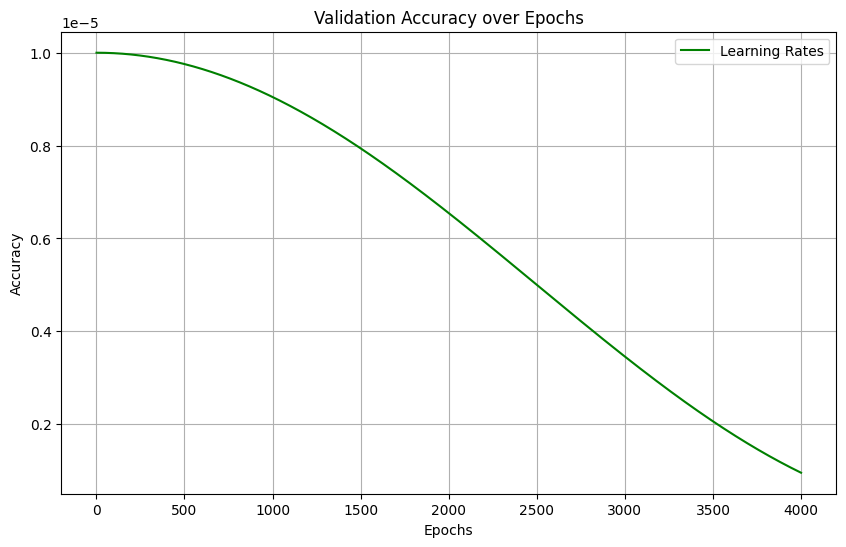

Model for bin 5 saved to GCNModels-5A_exp2/model_bin_5.pth
Training on bin 6/50
Bin 6, Epoch 1/4000, Train Loss: 0.7261, Validation Loss: 0.7111,  Accuracy: 0.2175, LR: 0.000010
Bin 6, Epoch 101/4000, Train Loss: 0.6424, Validation Loss: 0.6452,  Accuracy: 0.8164, LR: 0.000010
Bin 6, Epoch 201/4000, Train Loss: 0.5670, Validation Loss: 0.5755,  Accuracy: 0.8588, LR: 0.000010
Bin 6, Epoch 301/4000, Train Loss: 0.5156, Validation Loss: 0.5132,  Accuracy: 0.8729, LR: 0.000010
Bin 6, Epoch 401/4000, Train Loss: 0.4696, Validation Loss: 0.4625,  Accuracy: 0.8870, LR: 0.000010
Bin 6, Epoch 501/4000, Train Loss: 0.4166, Validation Loss: 0.4492,  Accuracy: 0.8842, LR: 0.000010
Bin 6, Epoch 601/4000, Train Loss: 0.4030, Validation Loss: 0.3794,  Accuracy: 0.8955, LR: 0.000010
Bin 6, Epoch 701/4000, Train Loss: 0.3879, Validation Loss: 0.3676,  Accuracy: 0.9040, LR: 0.000010
Bin 6, Epoch 801/4000, Train Loss: 0.3640, Validation Loss: 0.3262,  Accuracy: 0.9153, LR: 0.000009
Bin 6, Epoch 901/4000,

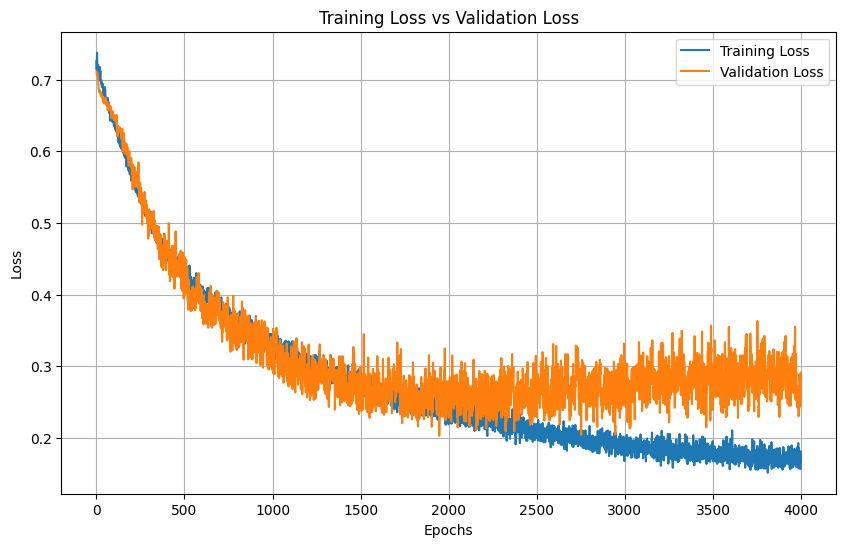

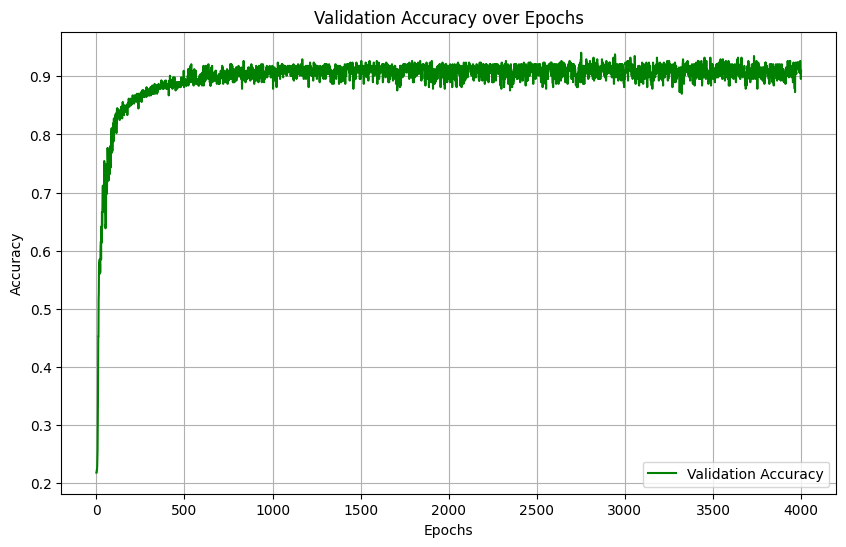

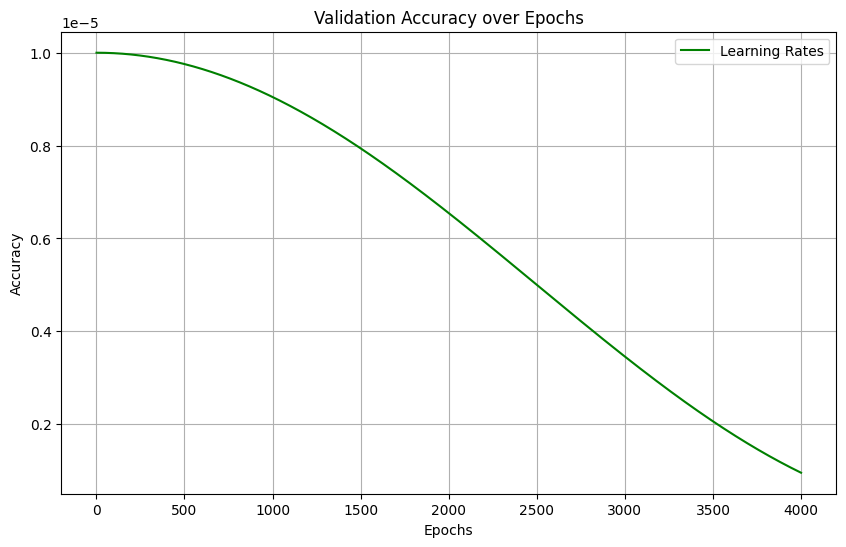

Model for bin 6 saved to GCNModels-5A_exp2/model_bin_6.pth
Training on bin 7/50
Bin 7, Epoch 1/4000, Train Loss: 0.6914, Validation Loss: 0.7155,  Accuracy: 0.2175, LR: 0.000010
Bin 7, Epoch 101/4000, Train Loss: 0.6377, Validation Loss: 0.6337,  Accuracy: 0.7316, LR: 0.000010
Bin 7, Epoch 201/4000, Train Loss: 0.5818, Validation Loss: 0.5505,  Accuracy: 0.8051, LR: 0.000010
Bin 7, Epoch 301/4000, Train Loss: 0.5382, Validation Loss: 0.4644,  Accuracy: 0.8559, LR: 0.000010
Bin 7, Epoch 401/4000, Train Loss: 0.5001, Validation Loss: 0.4533,  Accuracy: 0.8249, LR: 0.000010
Bin 7, Epoch 501/4000, Train Loss: 0.4630, Validation Loss: 0.3758,  Accuracy: 0.8814, LR: 0.000010
Bin 7, Epoch 601/4000, Train Loss: 0.4485, Validation Loss: 0.3304,  Accuracy: 0.8927, LR: 0.000010
Bin 7, Epoch 701/4000, Train Loss: 0.4166, Validation Loss: 0.3402,  Accuracy: 0.8757, LR: 0.000010
Bin 7, Epoch 801/4000, Train Loss: 0.4048, Validation Loss: 0.2745,  Accuracy: 0.9096, LR: 0.000009
Bin 7, Epoch 901/4000,

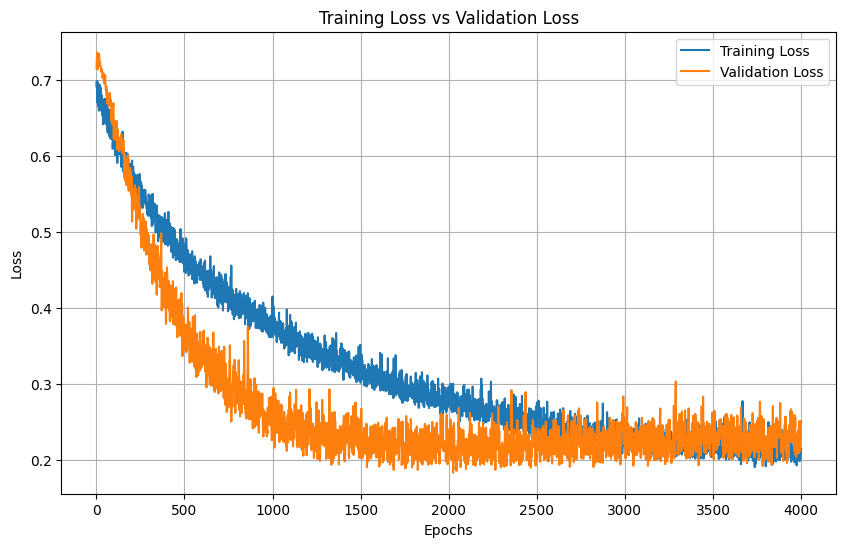

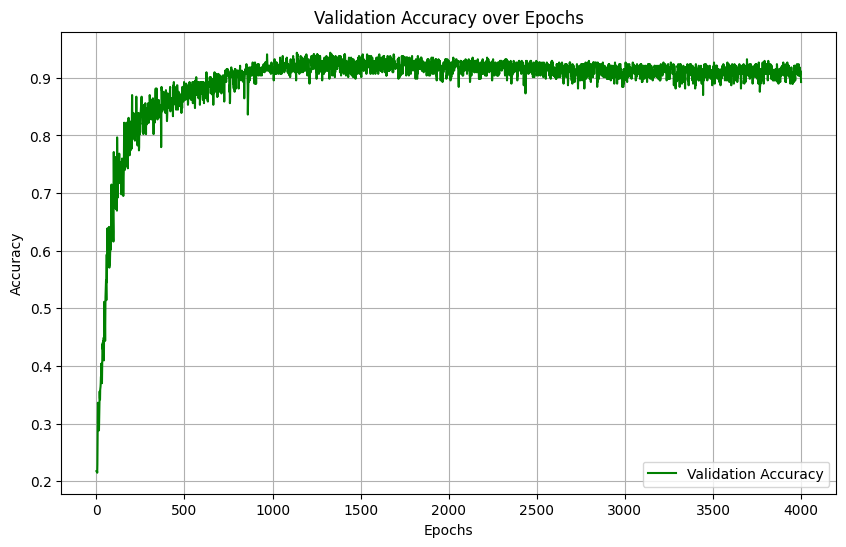

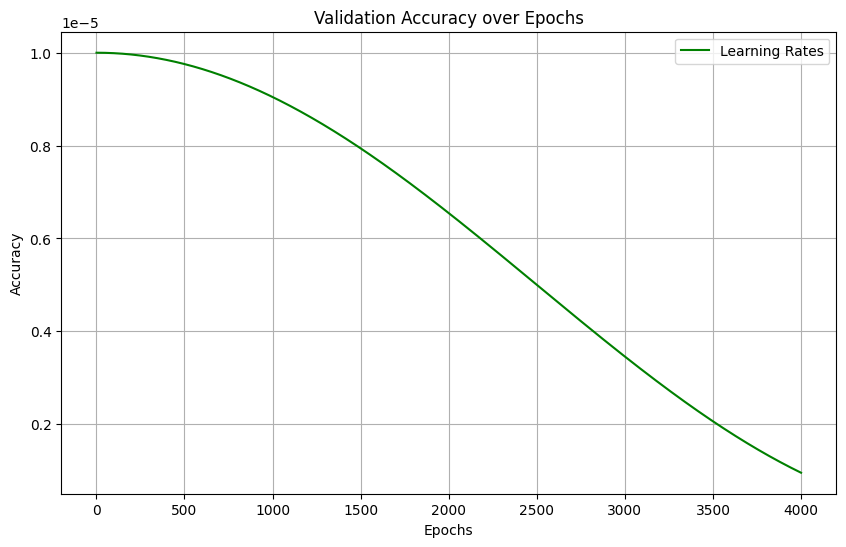

Model for bin 7 saved to GCNModels-5A_exp2/model_bin_7.pth
Training on bin 8/50
Bin 8, Epoch 1/4000, Train Loss: 0.6998, Validation Loss: 0.7071,  Accuracy: 0.2175, LR: 0.000010
Bin 8, Epoch 101/4000, Train Loss: 0.6335, Validation Loss: 0.6422,  Accuracy: 0.8136, LR: 0.000010
Bin 8, Epoch 201/4000, Train Loss: 0.5562, Validation Loss: 0.5698,  Accuracy: 0.8701, LR: 0.000010
Bin 8, Epoch 301/4000, Train Loss: 0.5169, Validation Loss: 0.5016,  Accuracy: 0.8842, LR: 0.000010
Bin 8, Epoch 401/4000, Train Loss: 0.4744, Validation Loss: 0.4438,  Accuracy: 0.8927, LR: 0.000010
Bin 8, Epoch 501/4000, Train Loss: 0.4429, Validation Loss: 0.4276,  Accuracy: 0.9011, LR: 0.000010
Bin 8, Epoch 601/4000, Train Loss: 0.4324, Validation Loss: 0.4266,  Accuracy: 0.8842, LR: 0.000010
Bin 8, Epoch 701/4000, Train Loss: 0.3954, Validation Loss: 0.3832,  Accuracy: 0.9096, LR: 0.000010
Bin 8, Epoch 801/4000, Train Loss: 0.3849, Validation Loss: 0.3628,  Accuracy: 0.9096, LR: 0.000009
Bin 8, Epoch 901/4000,

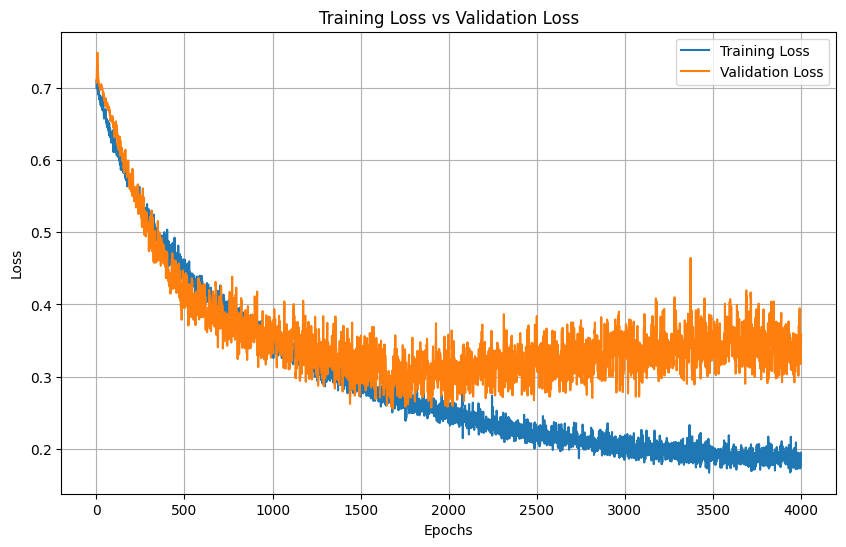

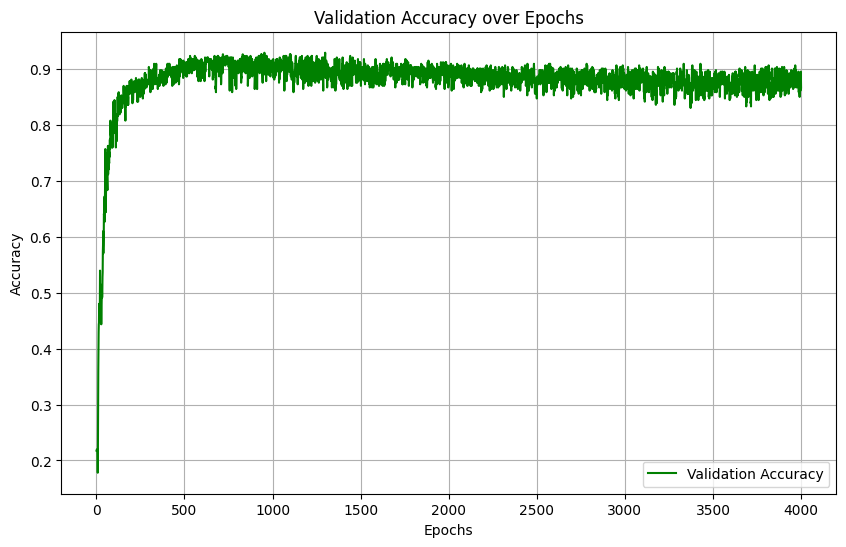

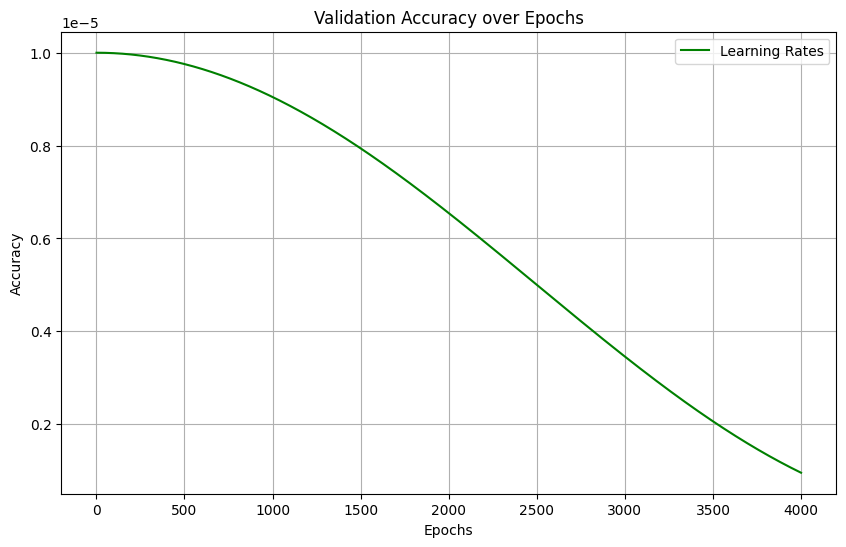

Model for bin 8 saved to GCNModels-5A_exp2/model_bin_8.pth
Training on bin 9/50
Bin 9, Epoch 1/4000, Train Loss: 0.6924, Validation Loss: 0.6885,  Accuracy: 0.7825, LR: 0.000010
Bin 9, Epoch 101/4000, Train Loss: 0.6284, Validation Loss: 0.6267,  Accuracy: 0.8220, LR: 0.000010
Bin 9, Epoch 201/4000, Train Loss: 0.5738, Validation Loss: 0.5608,  Accuracy: 0.8390, LR: 0.000010
Bin 9, Epoch 301/4000, Train Loss: 0.5387, Validation Loss: 0.5125,  Accuracy: 0.8588, LR: 0.000010
Bin 9, Epoch 401/4000, Train Loss: 0.4995, Validation Loss: 0.4371,  Accuracy: 0.8814, LR: 0.000010
Bin 9, Epoch 501/4000, Train Loss: 0.4774, Validation Loss: 0.4103,  Accuracy: 0.8898, LR: 0.000010
Bin 9, Epoch 601/4000, Train Loss: 0.4346, Validation Loss: 0.3911,  Accuracy: 0.9068, LR: 0.000010
Bin 9, Epoch 701/4000, Train Loss: 0.4037, Validation Loss: 0.3566,  Accuracy: 0.9209, LR: 0.000010
Bin 9, Epoch 801/4000, Train Loss: 0.3868, Validation Loss: 0.3386,  Accuracy: 0.9237, LR: 0.000009
Bin 9, Epoch 901/4000,

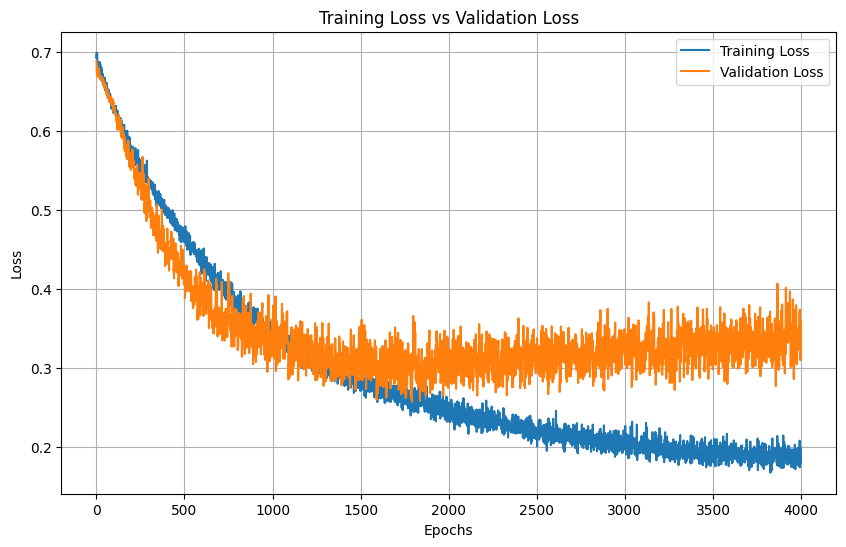

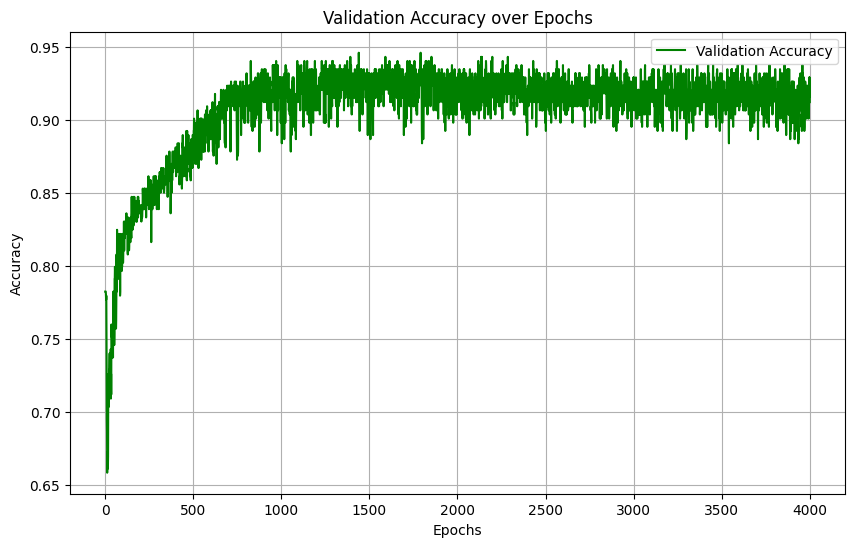

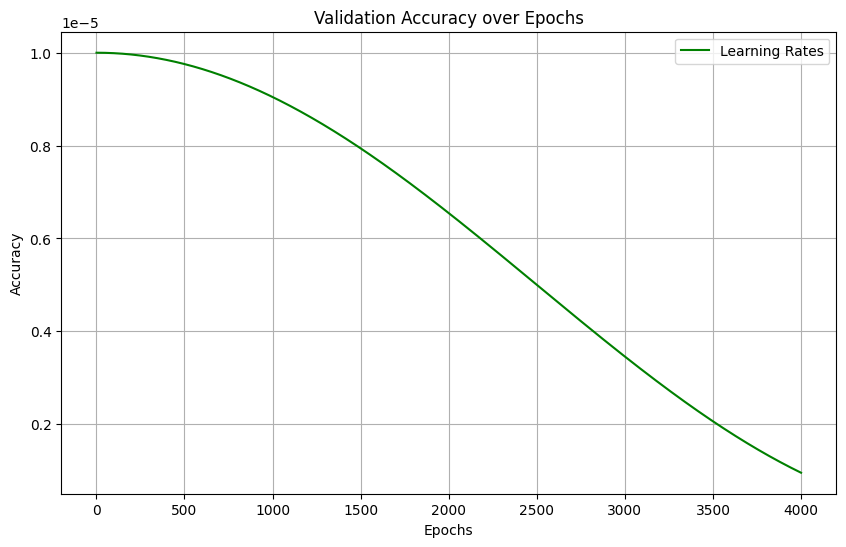

Model for bin 9 saved to GCNModels-5A_exp2/model_bin_9.pth
Training on bin 10/50
Bin 10, Epoch 1/4000, Train Loss: 0.7093, Validation Loss: 0.6950,  Accuracy: 0.2571, LR: 0.000010
Bin 10, Epoch 101/4000, Train Loss: 0.6393, Validation Loss: 0.6819,  Accuracy: 0.6469, LR: 0.000010
Bin 10, Epoch 201/4000, Train Loss: 0.5965, Validation Loss: 0.5971,  Accuracy: 0.8220, LR: 0.000010
Bin 10, Epoch 301/4000, Train Loss: 0.5538, Validation Loss: 0.5401,  Accuracy: 0.8418, LR: 0.000010
Bin 10, Epoch 401/4000, Train Loss: 0.5176, Validation Loss: 0.4868,  Accuracy: 0.8842, LR: 0.000010
Bin 10, Epoch 501/4000, Train Loss: 0.5020, Validation Loss: 0.4454,  Accuracy: 0.8870, LR: 0.000010
Bin 10, Epoch 601/4000, Train Loss: 0.4494, Validation Loss: 0.4246,  Accuracy: 0.8927, LR: 0.000010
Bin 10, Epoch 701/4000, Train Loss: 0.4325, Validation Loss: 0.3627,  Accuracy: 0.9011, LR: 0.000010
Bin 10, Epoch 801/4000, Train Loss: 0.3990, Validation Loss: 0.3570,  Accuracy: 0.9011, LR: 0.000009
Bin 10, Epoc

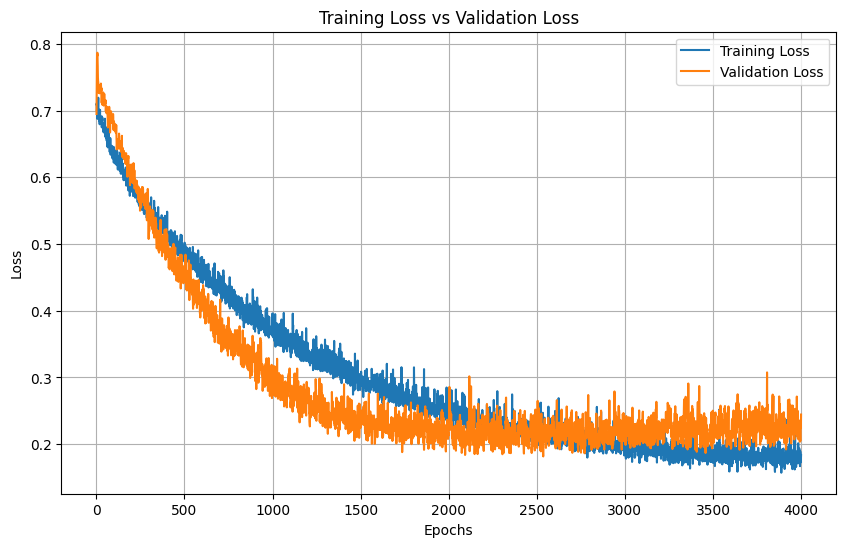

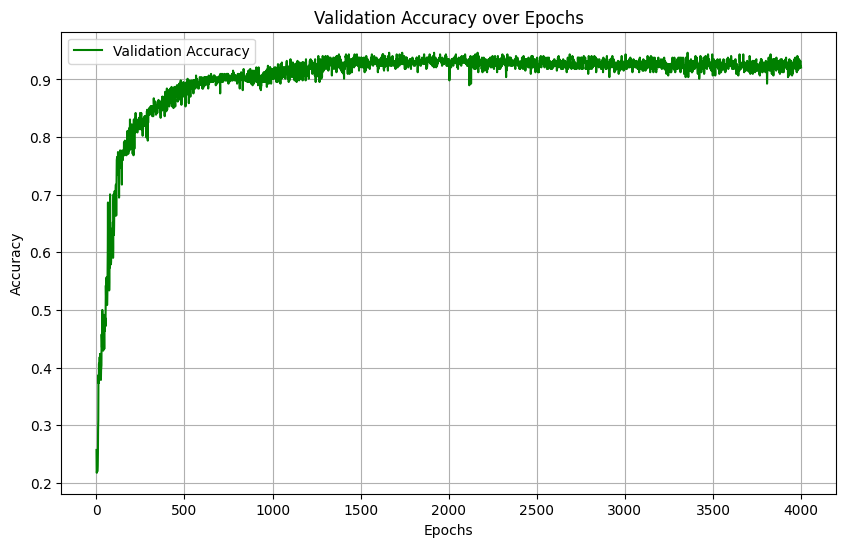

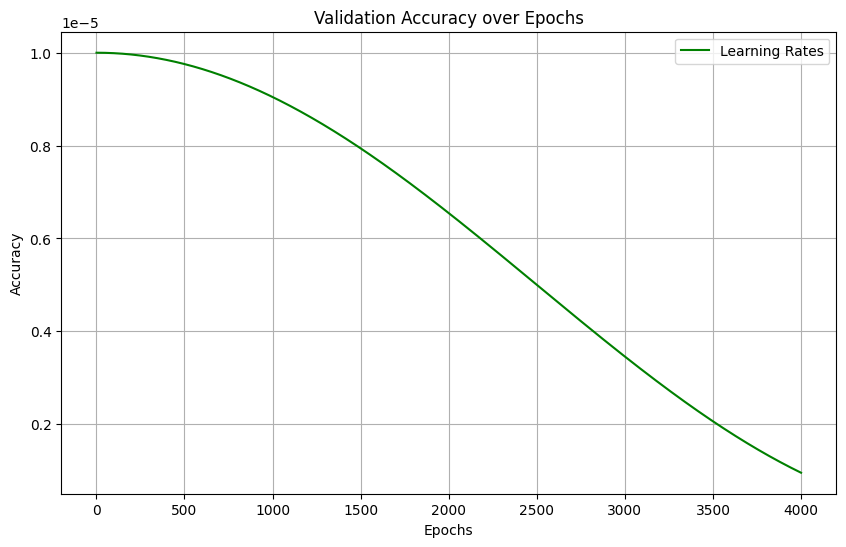

Model for bin 10 saved to GCNModels-5A_exp2/model_bin_10.pth
Training on bin 11/50
Bin 11, Epoch 1/4000, Train Loss: 0.7311, Validation Loss: 0.6664,  Accuracy: 0.7825, LR: 0.000010
Bin 11, Epoch 101/4000, Train Loss: 0.6322, Validation Loss: 0.6330,  Accuracy: 0.8277, LR: 0.000010
Bin 11, Epoch 201/4000, Train Loss: 0.5650, Validation Loss: 0.5828,  Accuracy: 0.8729, LR: 0.000010
Bin 11, Epoch 301/4000, Train Loss: 0.5251, Validation Loss: 0.5340,  Accuracy: 0.8955, LR: 0.000010
Bin 11, Epoch 401/4000, Train Loss: 0.4518, Validation Loss: 0.5058,  Accuracy: 0.8785, LR: 0.000010
Bin 11, Epoch 501/4000, Train Loss: 0.4191, Validation Loss: 0.4481,  Accuracy: 0.9096, LR: 0.000010
Bin 11, Epoch 601/4000, Train Loss: 0.3874, Validation Loss: 0.4275,  Accuracy: 0.9096, LR: 0.000010
Bin 11, Epoch 701/4000, Train Loss: 0.3617, Validation Loss: 0.4200,  Accuracy: 0.9124, LR: 0.000010
Bin 11, Epoch 801/4000, Train Loss: 0.3570, Validation Loss: 0.4033,  Accuracy: 0.9040, LR: 0.000009
Bin 11, Ep

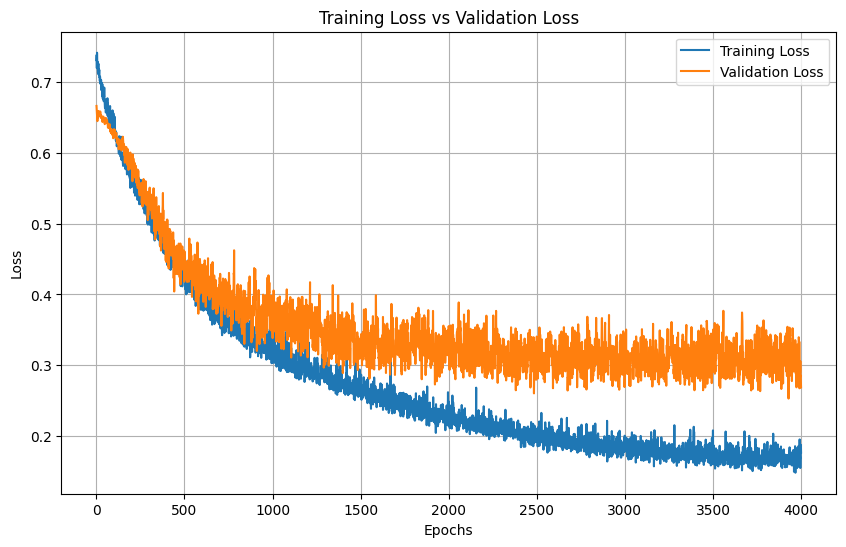

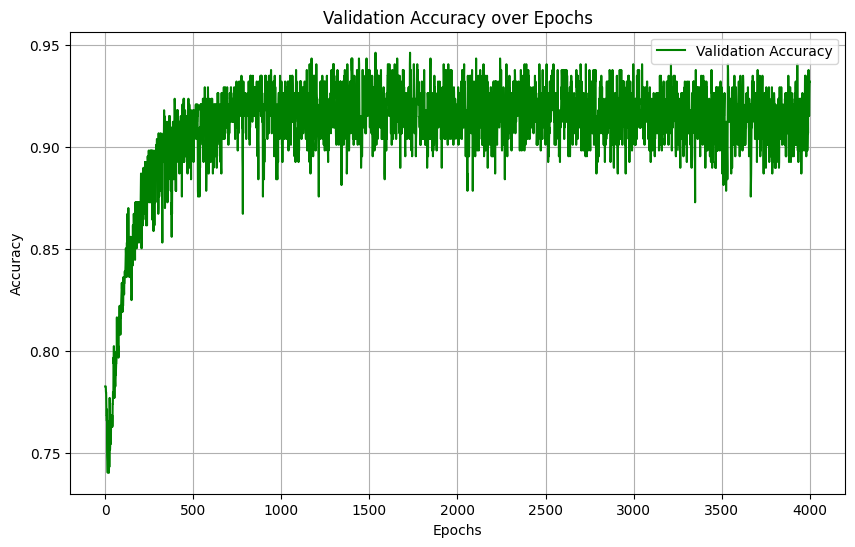

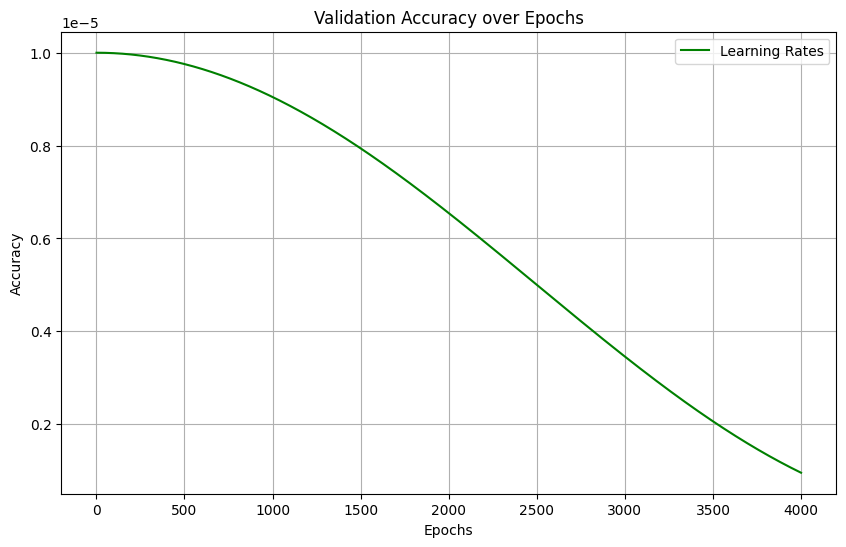

Model for bin 11 saved to GCNModels-5A_exp2/model_bin_11.pth
Training on bin 12/50
Bin 12, Epoch 1/4000, Train Loss: 0.7255, Validation Loss: 0.7649,  Accuracy: 0.2175, LR: 0.000010
Bin 12, Epoch 101/4000, Train Loss: 0.6524, Validation Loss: 0.7050,  Accuracy: 0.4322, LR: 0.000010
Bin 12, Epoch 201/4000, Train Loss: 0.6031, Validation Loss: 0.6142,  Accuracy: 0.7175, LR: 0.000010
Bin 12, Epoch 301/4000, Train Loss: 0.5441, Validation Loss: 0.5616,  Accuracy: 0.8277, LR: 0.000010
Bin 12, Epoch 401/4000, Train Loss: 0.5114, Validation Loss: 0.4936,  Accuracy: 0.8616, LR: 0.000010
Bin 12, Epoch 501/4000, Train Loss: 0.4776, Validation Loss: 0.4480,  Accuracy: 0.8701, LR: 0.000010
Bin 12, Epoch 601/4000, Train Loss: 0.4448, Validation Loss: 0.4040,  Accuracy: 0.8898, LR: 0.000010
Bin 12, Epoch 701/4000, Train Loss: 0.4143, Validation Loss: 0.3897,  Accuracy: 0.8870, LR: 0.000010
Bin 12, Epoch 801/4000, Train Loss: 0.3952, Validation Loss: 0.3529,  Accuracy: 0.8955, LR: 0.000009
Bin 12, Ep

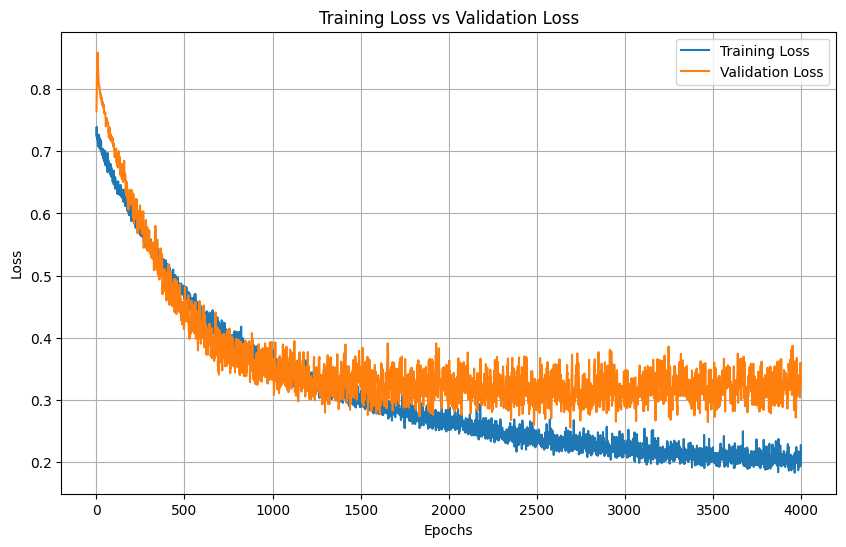

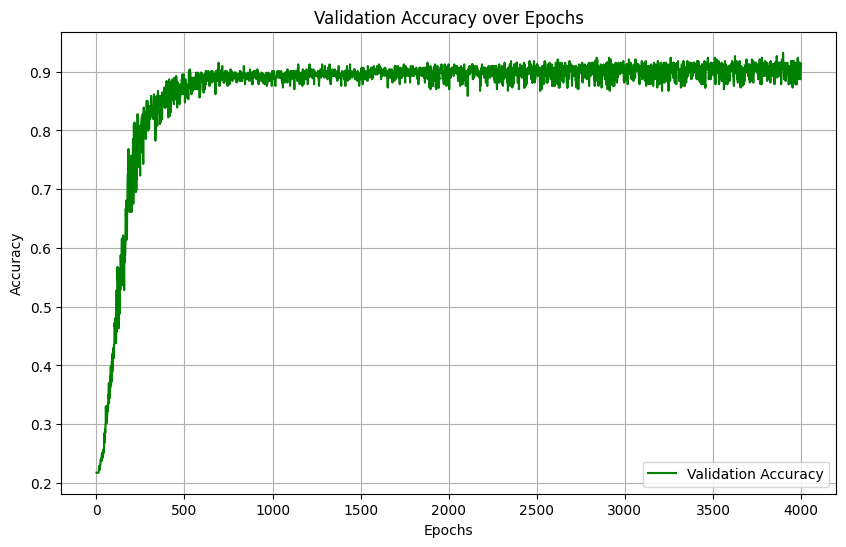

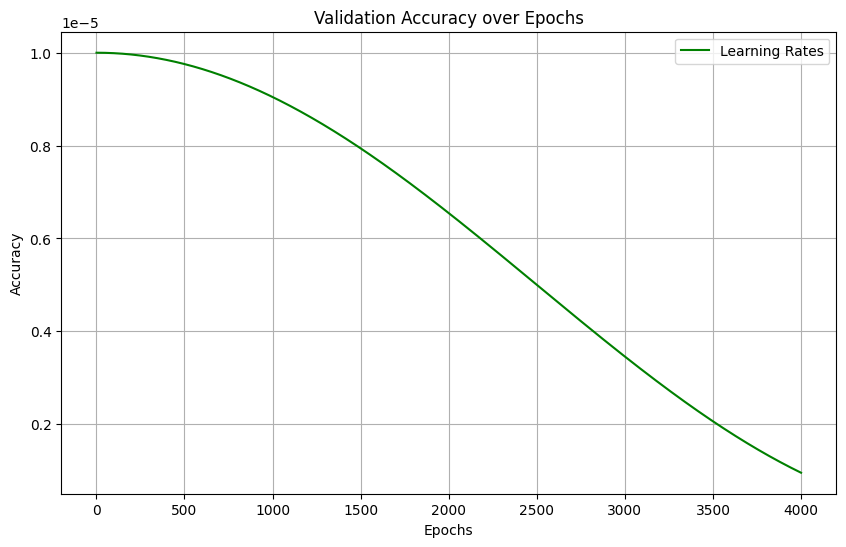

Model for bin 12 saved to GCNModels-5A_exp2/model_bin_12.pth
Training on bin 13/50
Bin 13, Epoch 1/4000, Train Loss: 0.6952, Validation Loss: 0.7167,  Accuracy: 0.2175, LR: 0.000010
Bin 13, Epoch 101/4000, Train Loss: 0.6194, Validation Loss: 0.6716,  Accuracy: 0.7232, LR: 0.000010
Bin 13, Epoch 201/4000, Train Loss: 0.5740, Validation Loss: 0.6044,  Accuracy: 0.8192, LR: 0.000010
Bin 13, Epoch 301/4000, Train Loss: 0.5129, Validation Loss: 0.5077,  Accuracy: 0.8898, LR: 0.000010
Bin 13, Epoch 401/4000, Train Loss: 0.4887, Validation Loss: 0.4786,  Accuracy: 0.8842, LR: 0.000010
Bin 13, Epoch 501/4000, Train Loss: 0.4583, Validation Loss: 0.4466,  Accuracy: 0.8842, LR: 0.000010
Bin 13, Epoch 601/4000, Train Loss: 0.4205, Validation Loss: 0.4344,  Accuracy: 0.8814, LR: 0.000010
Bin 13, Epoch 701/4000, Train Loss: 0.4116, Validation Loss: 0.3996,  Accuracy: 0.8898, LR: 0.000010
Bin 13, Epoch 801/4000, Train Loss: 0.3572, Validation Loss: 0.3834,  Accuracy: 0.8927, LR: 0.000009
Bin 13, Ep

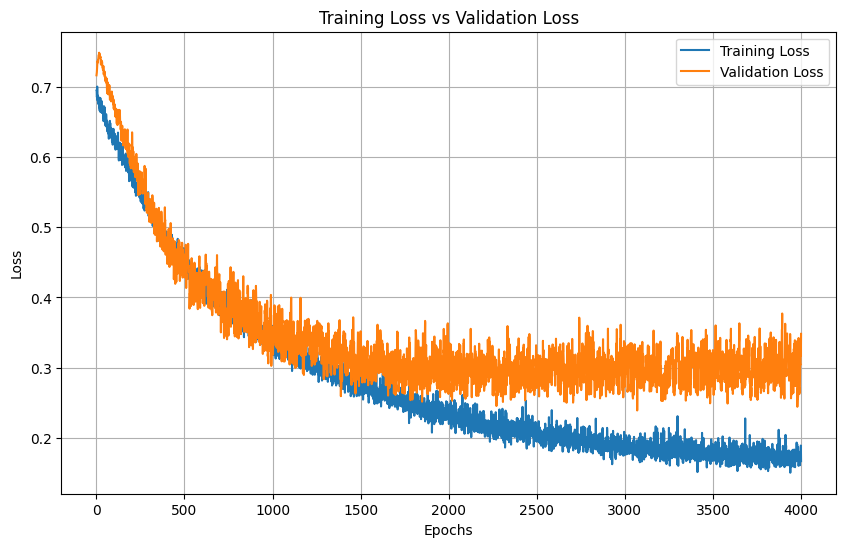

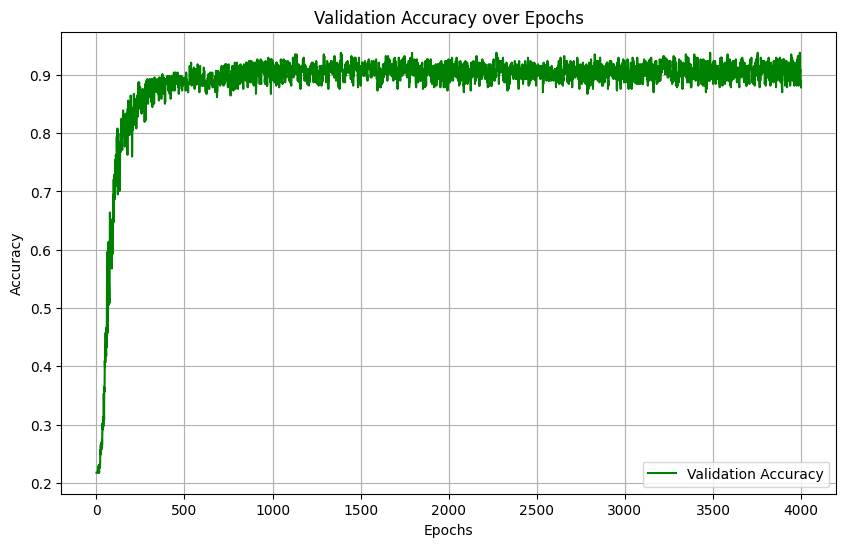

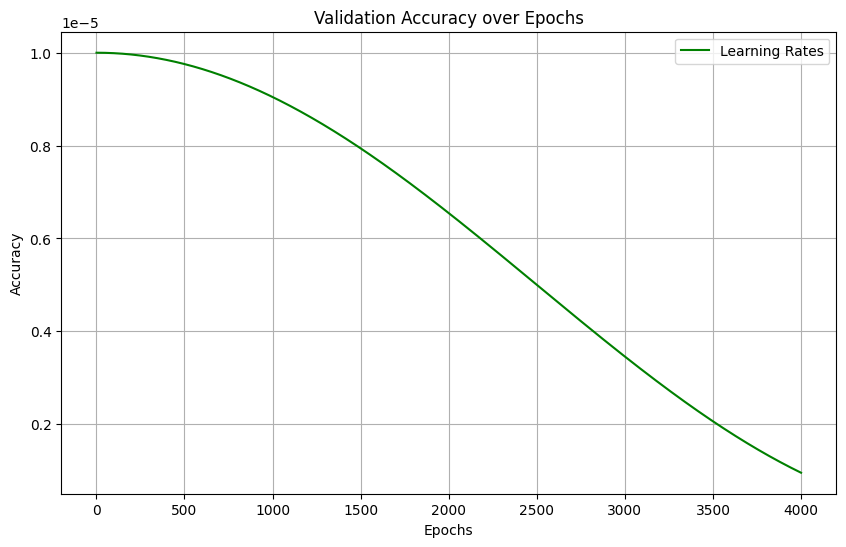

Model for bin 13 saved to GCNModels-5A_exp2/model_bin_13.pth
Training on bin 14/50
Bin 14, Epoch 1/4000, Train Loss: 0.6999, Validation Loss: 0.7384,  Accuracy: 0.2175, LR: 0.000010
Bin 14, Epoch 101/4000, Train Loss: 0.6046, Validation Loss: 0.6413,  Accuracy: 0.7458, LR: 0.000010
Bin 14, Epoch 201/4000, Train Loss: 0.5181, Validation Loss: 0.5576,  Accuracy: 0.8362, LR: 0.000010
Bin 14, Epoch 301/4000, Train Loss: 0.4705, Validation Loss: 0.4594,  Accuracy: 0.8701, LR: 0.000010
Bin 14, Epoch 401/4000, Train Loss: 0.4302, Validation Loss: 0.4072,  Accuracy: 0.8870, LR: 0.000010
Bin 14, Epoch 501/4000, Train Loss: 0.3872, Validation Loss: 0.3781,  Accuracy: 0.9011, LR: 0.000010
Bin 14, Epoch 601/4000, Train Loss: 0.3818, Validation Loss: 0.3489,  Accuracy: 0.8983, LR: 0.000010
Bin 14, Epoch 701/4000, Train Loss: 0.3653, Validation Loss: 0.3662,  Accuracy: 0.8814, LR: 0.000010
Bin 14, Epoch 801/4000, Train Loss: 0.3340, Validation Loss: 0.3163,  Accuracy: 0.9124, LR: 0.000009
Bin 14, Ep

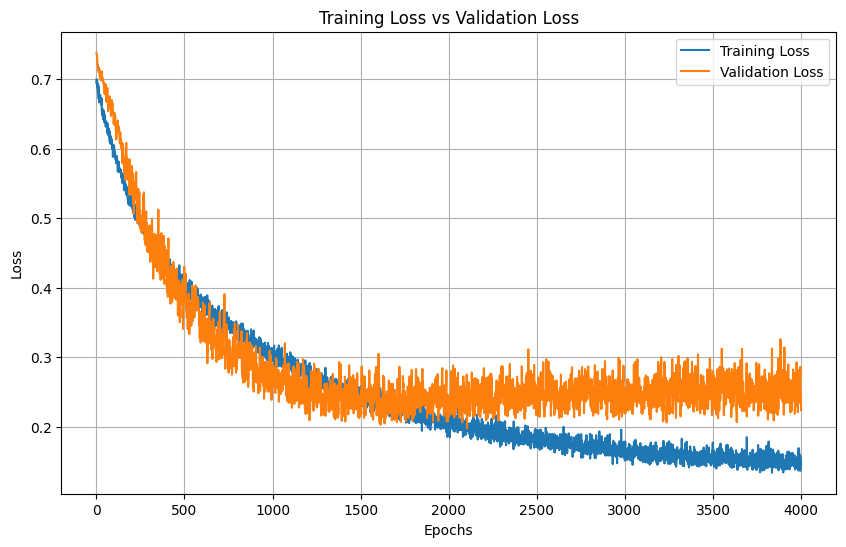

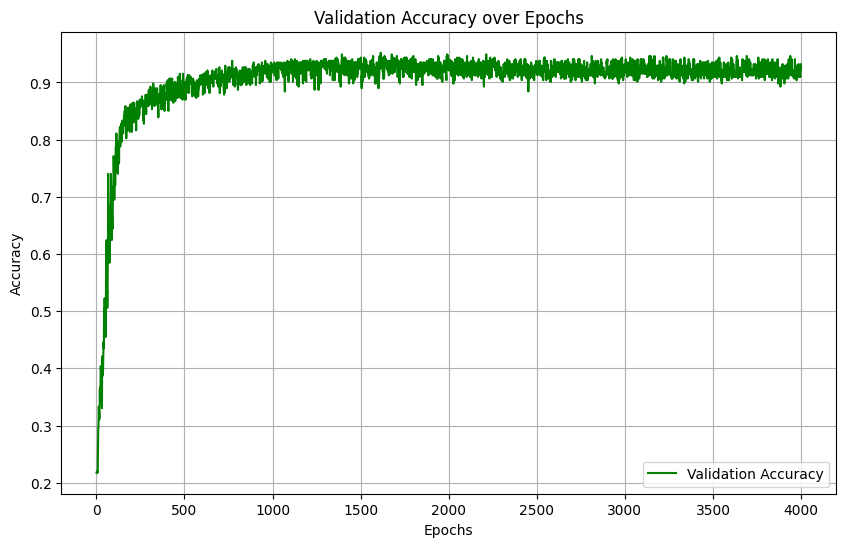

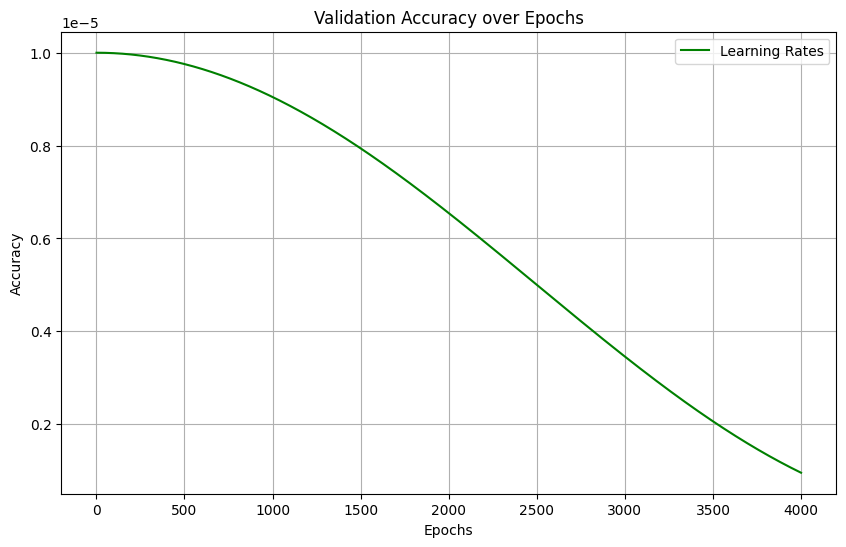

Model for bin 14 saved to GCNModels-5A_exp2/model_bin_14.pth
Training on bin 15/50
Bin 15, Epoch 1/4000, Train Loss: 0.7142, Validation Loss: 0.6654,  Accuracy: 0.7825, LR: 0.000010
Bin 15, Epoch 101/4000, Train Loss: 0.6305, Validation Loss: 0.6199,  Accuracy: 0.8192, LR: 0.000010
Bin 15, Epoch 201/4000, Train Loss: 0.5920, Validation Loss: 0.5445,  Accuracy: 0.8446, LR: 0.000010
Bin 15, Epoch 301/4000, Train Loss: 0.5391, Validation Loss: 0.5012,  Accuracy: 0.8475, LR: 0.000010
Bin 15, Epoch 401/4000, Train Loss: 0.5164, Validation Loss: 0.4416,  Accuracy: 0.8672, LR: 0.000010
Bin 15, Epoch 501/4000, Train Loss: 0.4559, Validation Loss: 0.4010,  Accuracy: 0.8785, LR: 0.000010
Bin 15, Epoch 601/4000, Train Loss: 0.4464, Validation Loss: 0.3707,  Accuracy: 0.8842, LR: 0.000010
Bin 15, Epoch 701/4000, Train Loss: 0.4287, Validation Loss: 0.3393,  Accuracy: 0.8955, LR: 0.000010
Bin 15, Epoch 801/4000, Train Loss: 0.4162, Validation Loss: 0.3254,  Accuracy: 0.8983, LR: 0.000009
Bin 15, Ep

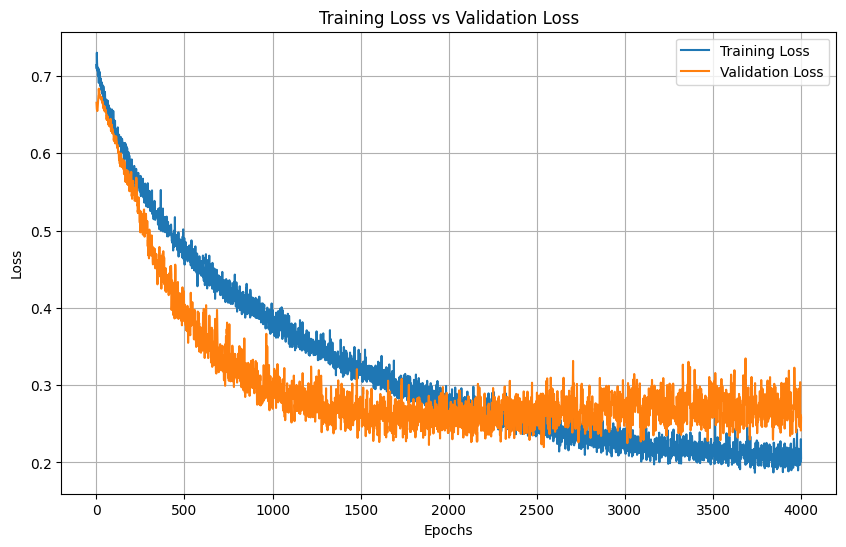

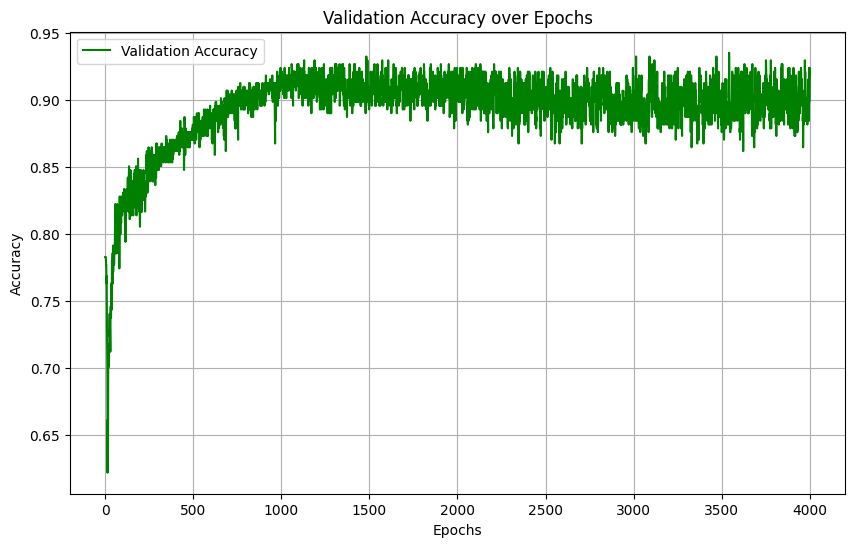

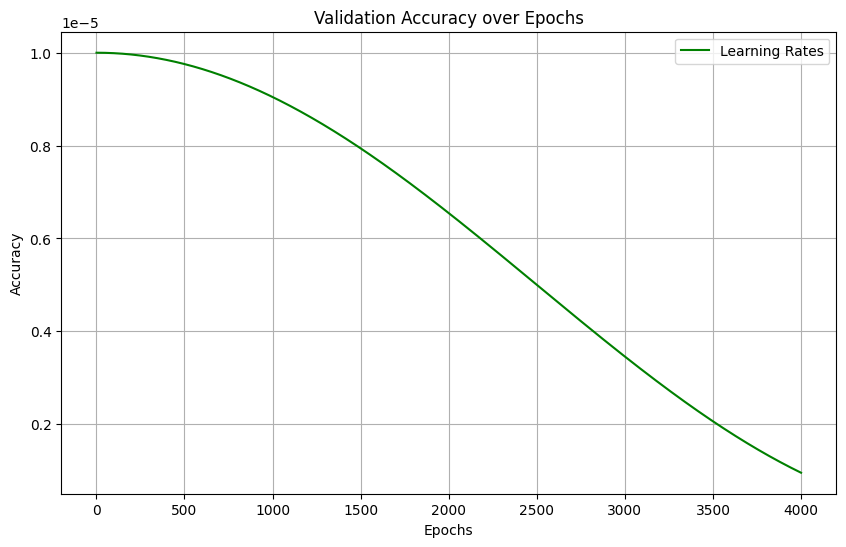

Model for bin 15 saved to GCNModels-5A_exp2/model_bin_15.pth
Training on bin 16/50
Bin 16, Epoch 1/4000, Train Loss: 0.6970, Validation Loss: 0.6829,  Accuracy: 0.7825, LR: 0.000010
Bin 16, Epoch 101/4000, Train Loss: 0.6342, Validation Loss: 0.6680,  Accuracy: 0.7288, LR: 0.000010
Bin 16, Epoch 201/4000, Train Loss: 0.5759, Validation Loss: 0.5746,  Accuracy: 0.8729, LR: 0.000010
Bin 16, Epoch 301/4000, Train Loss: 0.5084, Validation Loss: 0.5119,  Accuracy: 0.8559, LR: 0.000010
Bin 16, Epoch 401/4000, Train Loss: 0.4760, Validation Loss: 0.4307,  Accuracy: 0.9068, LR: 0.000010
Bin 16, Epoch 501/4000, Train Loss: 0.4586, Validation Loss: 0.4172,  Accuracy: 0.8814, LR: 0.000010
Bin 16, Epoch 601/4000, Train Loss: 0.4176, Validation Loss: 0.3948,  Accuracy: 0.8729, LR: 0.000010
Bin 16, Epoch 701/4000, Train Loss: 0.3973, Validation Loss: 0.3747,  Accuracy: 0.8870, LR: 0.000010
Bin 16, Epoch 801/4000, Train Loss: 0.3953, Validation Loss: 0.3338,  Accuracy: 0.9040, LR: 0.000009
Bin 16, Ep

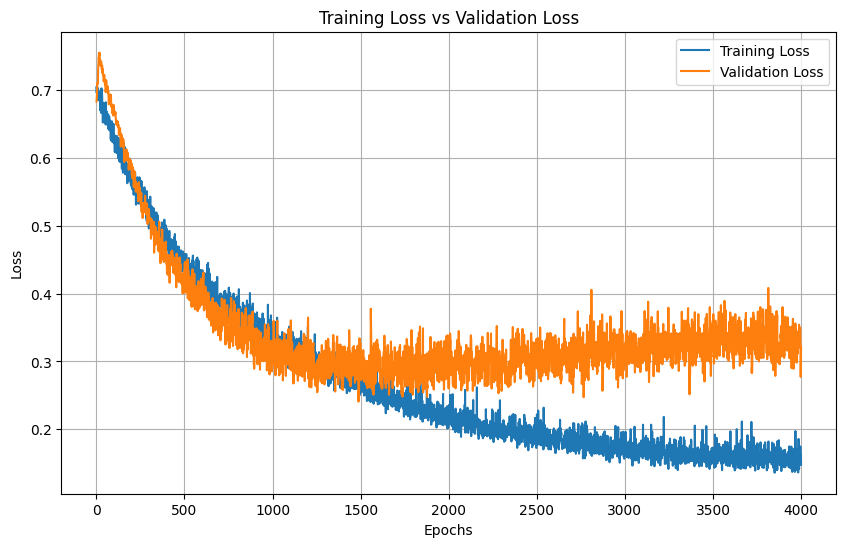

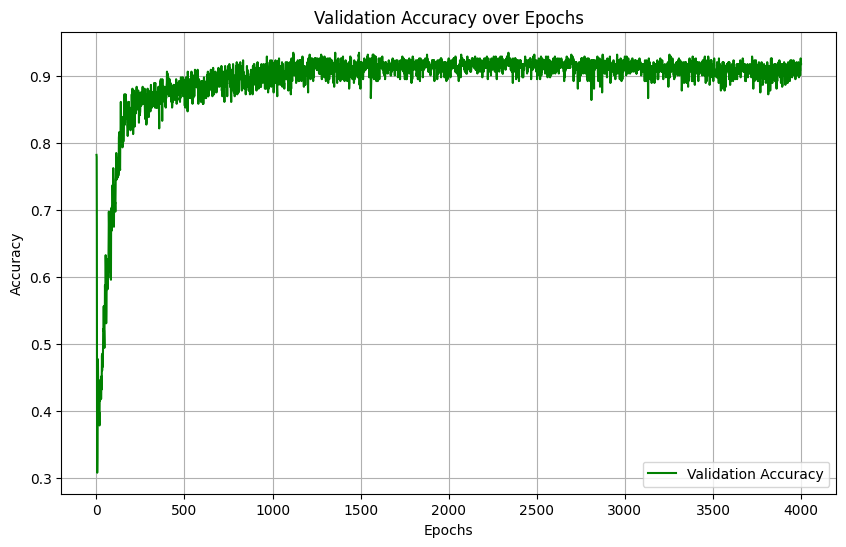

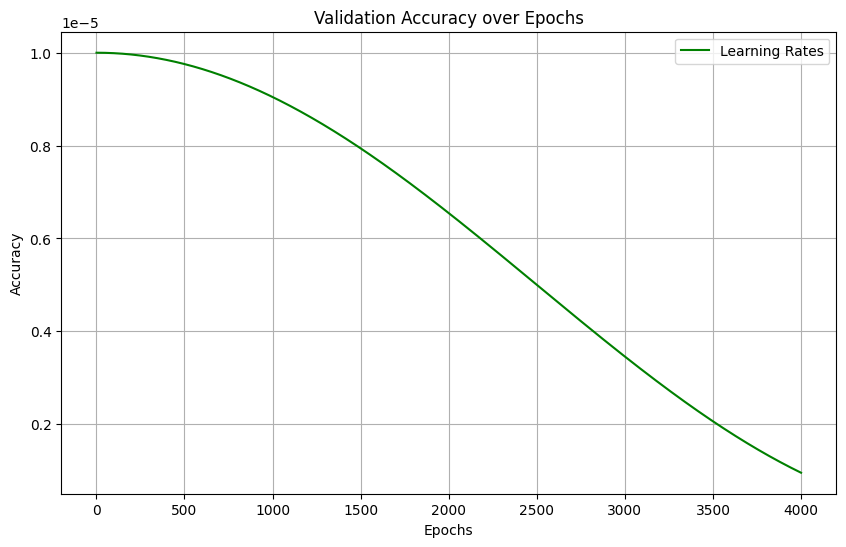

Model for bin 16 saved to GCNModels-5A_exp2/model_bin_16.pth
Training on bin 17/50
Bin 17, Epoch 1/4000, Train Loss: 0.6963, Validation Loss: 0.6734,  Accuracy: 0.7825, LR: 0.000010
Bin 17, Epoch 101/4000, Train Loss: 0.6160, Validation Loss: 0.6103,  Accuracy: 0.8164, LR: 0.000010
Bin 17, Epoch 201/4000, Train Loss: 0.5303, Validation Loss: 0.5476,  Accuracy: 0.8503, LR: 0.000010
Bin 17, Epoch 301/4000, Train Loss: 0.4914, Validation Loss: 0.4714,  Accuracy: 0.8842, LR: 0.000010
Bin 17, Epoch 401/4000, Train Loss: 0.4355, Validation Loss: 0.4071,  Accuracy: 0.9153, LR: 0.000010
Bin 17, Epoch 501/4000, Train Loss: 0.4211, Validation Loss: 0.3990,  Accuracy: 0.9068, LR: 0.000010
Bin 17, Epoch 601/4000, Train Loss: 0.4028, Validation Loss: 0.3879,  Accuracy: 0.8898, LR: 0.000010
Bin 17, Epoch 701/4000, Train Loss: 0.3855, Validation Loss: 0.3302,  Accuracy: 0.9040, LR: 0.000010
Bin 17, Epoch 801/4000, Train Loss: 0.3643, Validation Loss: 0.3144,  Accuracy: 0.9096, LR: 0.000009
Bin 17, Ep

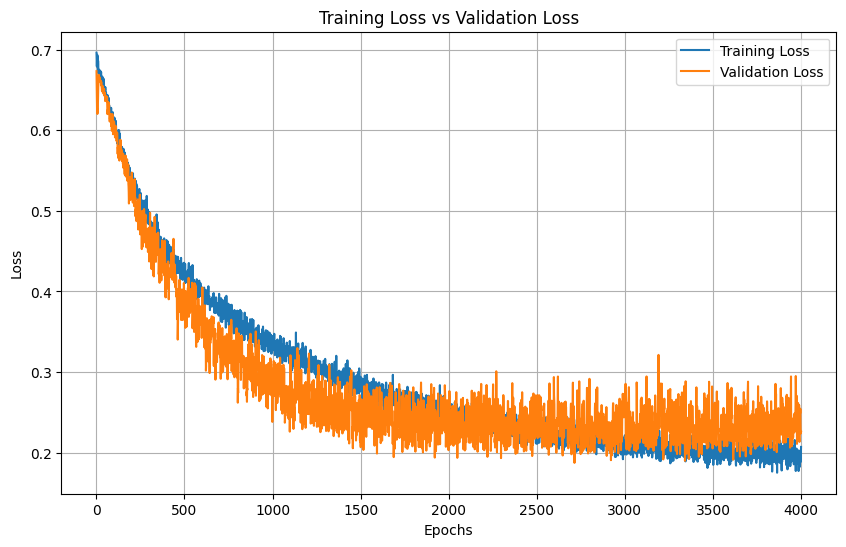

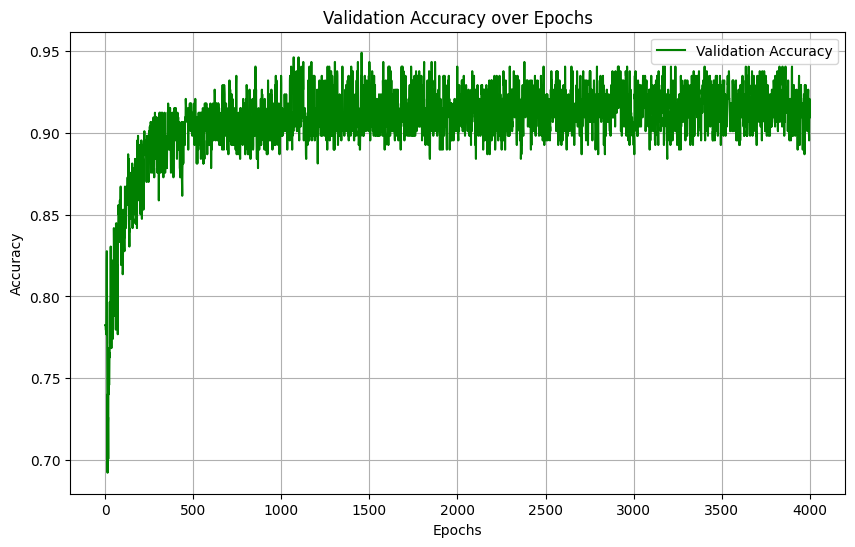

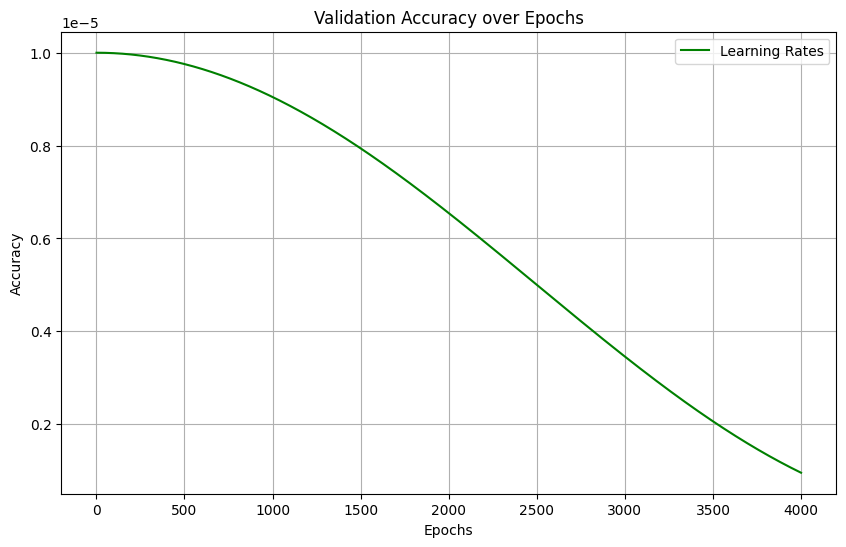

Model for bin 17 saved to GCNModels-5A_exp2/model_bin_17.pth
Training on bin 18/50
Bin 18, Epoch 1/4000, Train Loss: 0.7374, Validation Loss: 0.6520,  Accuracy: 0.7825, LR: 0.000010
Bin 18, Epoch 101/4000, Train Loss: 0.6017, Validation Loss: 0.5891,  Accuracy: 0.8588, LR: 0.000010
Bin 18, Epoch 201/4000, Train Loss: 0.5310, Validation Loss: 0.5093,  Accuracy: 0.8898, LR: 0.000010
Bin 18, Epoch 301/4000, Train Loss: 0.5071, Validation Loss: 0.4337,  Accuracy: 0.9040, LR: 0.000010
Bin 18, Epoch 401/4000, Train Loss: 0.4269, Validation Loss: 0.4131,  Accuracy: 0.8785, LR: 0.000010
Bin 18, Epoch 501/4000, Train Loss: 0.4437, Validation Loss: 0.3663,  Accuracy: 0.8927, LR: 0.000010
Bin 18, Epoch 601/4000, Train Loss: 0.3853, Validation Loss: 0.3531,  Accuracy: 0.8898, LR: 0.000010
Bin 18, Epoch 701/4000, Train Loss: 0.3664, Validation Loss: 0.3210,  Accuracy: 0.8983, LR: 0.000010
Bin 18, Epoch 801/4000, Train Loss: 0.3400, Validation Loss: 0.3013,  Accuracy: 0.8955, LR: 0.000009
Bin 18, Ep

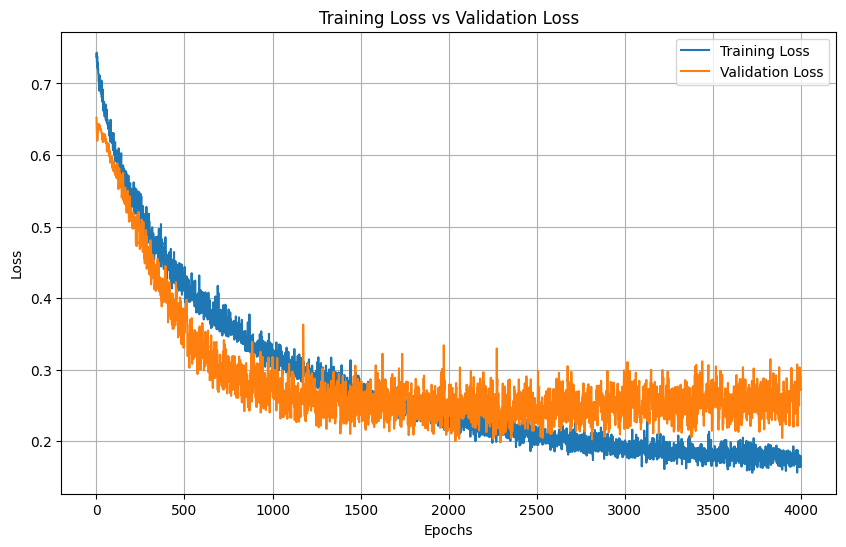

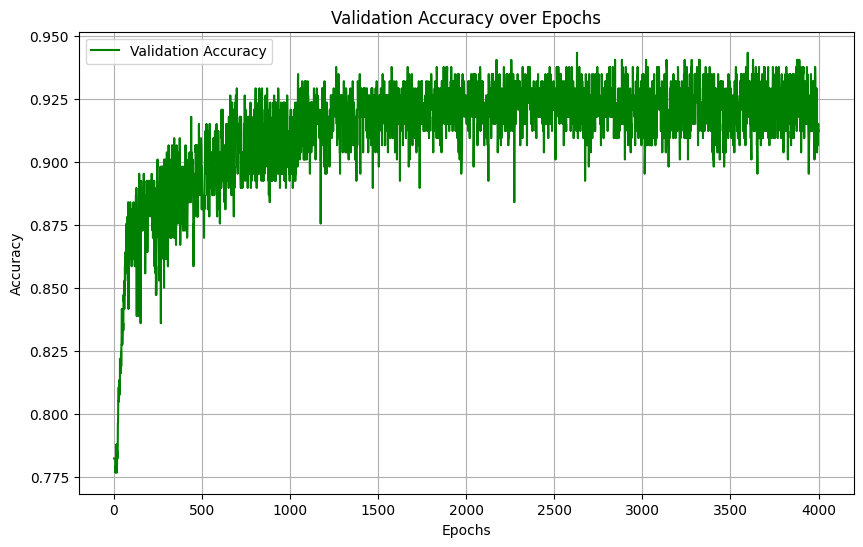

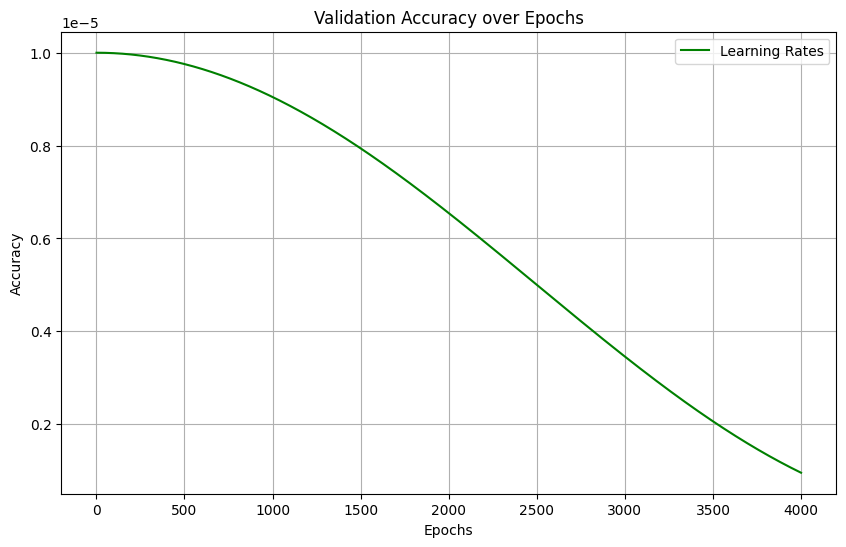

Model for bin 18 saved to GCNModels-5A_exp2/model_bin_18.pth
Training on bin 19/50
Bin 19, Epoch 1/4000, Train Loss: 0.7006, Validation Loss: 0.7242,  Accuracy: 0.2175, LR: 0.000010
Bin 19, Epoch 101/4000, Train Loss: 0.6348, Validation Loss: 0.7006,  Accuracy: 0.5367, LR: 0.000010
Bin 19, Epoch 201/4000, Train Loss: 0.5758, Validation Loss: 0.6245,  Accuracy: 0.7910, LR: 0.000010
Bin 19, Epoch 301/4000, Train Loss: 0.5302, Validation Loss: 0.5001,  Accuracy: 0.8672, LR: 0.000010
Bin 19, Epoch 401/4000, Train Loss: 0.4793, Validation Loss: 0.4578,  Accuracy: 0.8729, LR: 0.000010
Bin 19, Epoch 501/4000, Train Loss: 0.4487, Validation Loss: 0.4117,  Accuracy: 0.8870, LR: 0.000010
Bin 19, Epoch 601/4000, Train Loss: 0.4462, Validation Loss: 0.3603,  Accuracy: 0.9040, LR: 0.000010
Bin 19, Epoch 701/4000, Train Loss: 0.4132, Validation Loss: 0.3461,  Accuracy: 0.8983, LR: 0.000010
Bin 19, Epoch 801/4000, Train Loss: 0.3847, Validation Loss: 0.3139,  Accuracy: 0.9181, LR: 0.000009
Bin 19, Ep

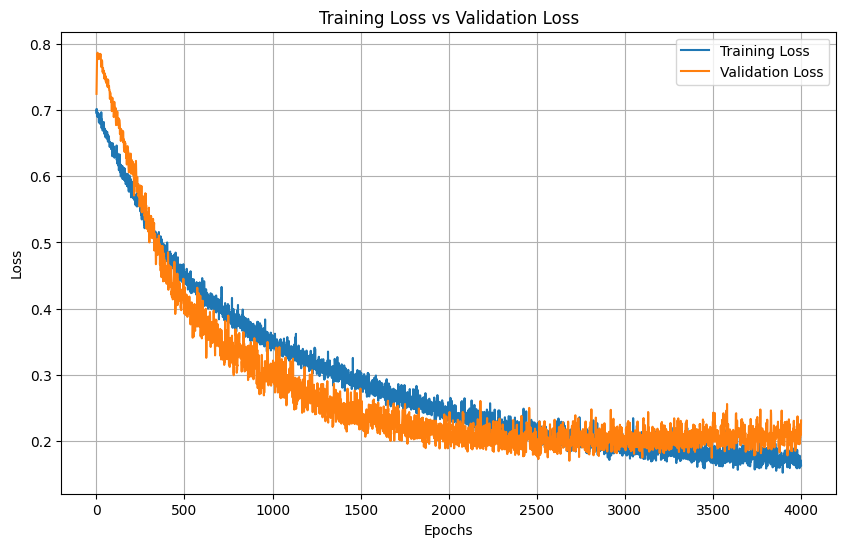

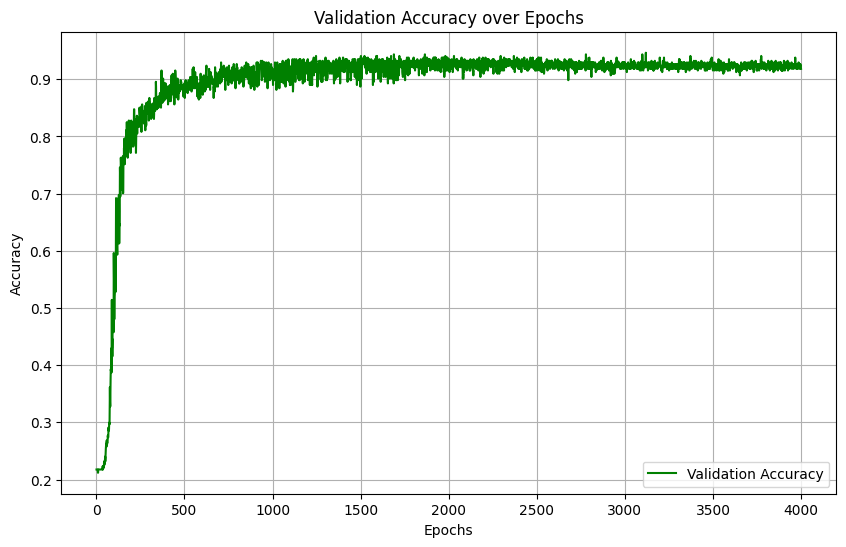

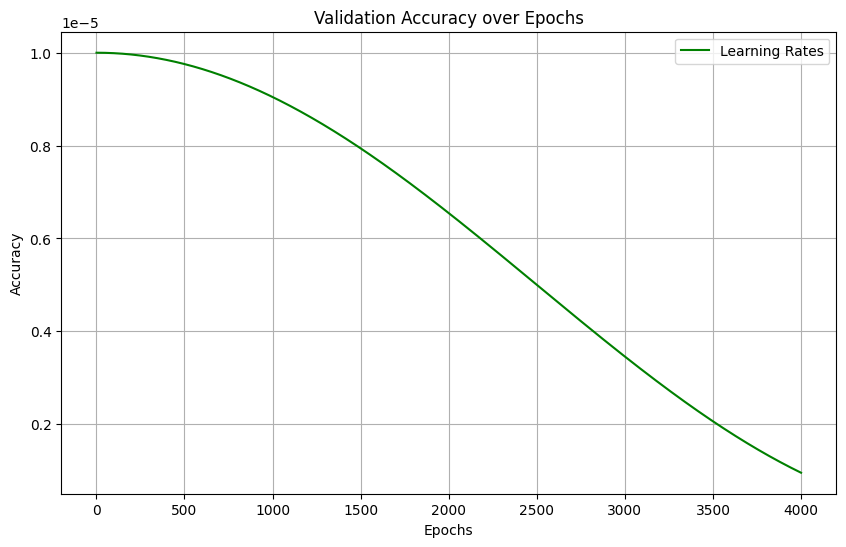

Model for bin 19 saved to GCNModels-5A_exp2/model_bin_19.pth
Training on bin 20/50
Bin 20, Epoch 1/4000, Train Loss: 0.7326, Validation Loss: 0.6541,  Accuracy: 0.7825, LR: 0.000010
Bin 20, Epoch 101/4000, Train Loss: 0.6254, Validation Loss: 0.6179,  Accuracy: 0.8333, LR: 0.000010
Bin 20, Epoch 201/4000, Train Loss: 0.5553, Validation Loss: 0.5941,  Accuracy: 0.8362, LR: 0.000010
Bin 20, Epoch 301/4000, Train Loss: 0.5103, Validation Loss: 0.5164,  Accuracy: 0.8729, LR: 0.000010
Bin 20, Epoch 401/4000, Train Loss: 0.4705, Validation Loss: 0.4771,  Accuracy: 0.8729, LR: 0.000010
Bin 20, Epoch 501/4000, Train Loss: 0.4563, Validation Loss: 0.4789,  Accuracy: 0.8785, LR: 0.000010
Bin 20, Epoch 601/4000, Train Loss: 0.4108, Validation Loss: 0.3963,  Accuracy: 0.9237, LR: 0.000010
Bin 20, Epoch 701/4000, Train Loss: 0.3917, Validation Loss: 0.4139,  Accuracy: 0.9153, LR: 0.000010
Bin 20, Epoch 801/4000, Train Loss: 0.3888, Validation Loss: 0.3892,  Accuracy: 0.9266, LR: 0.000009
Bin 20, Ep

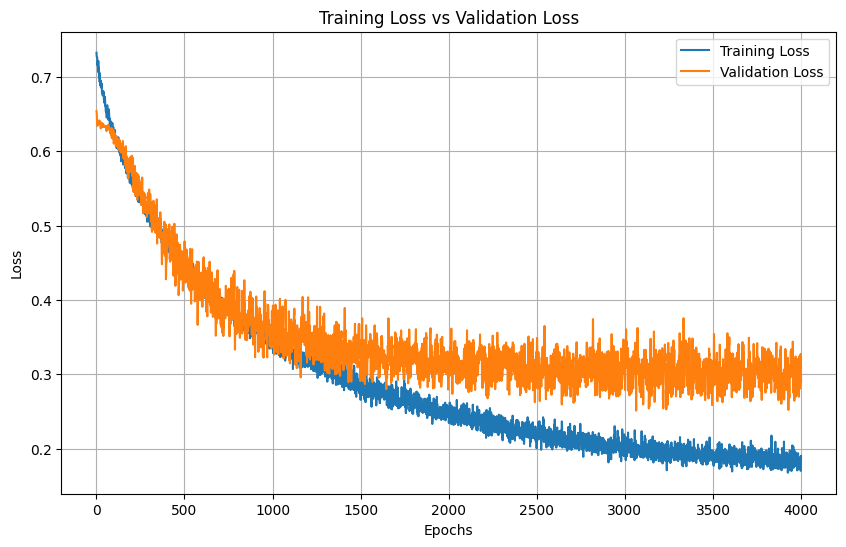

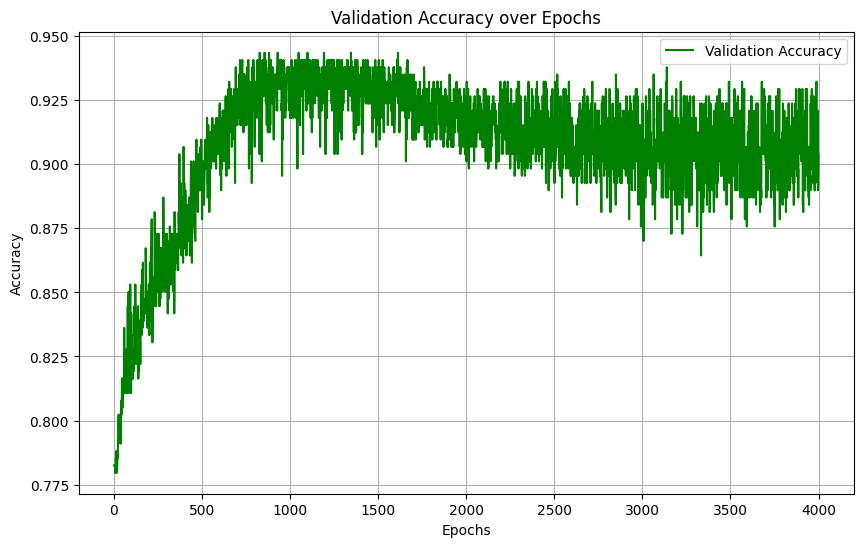

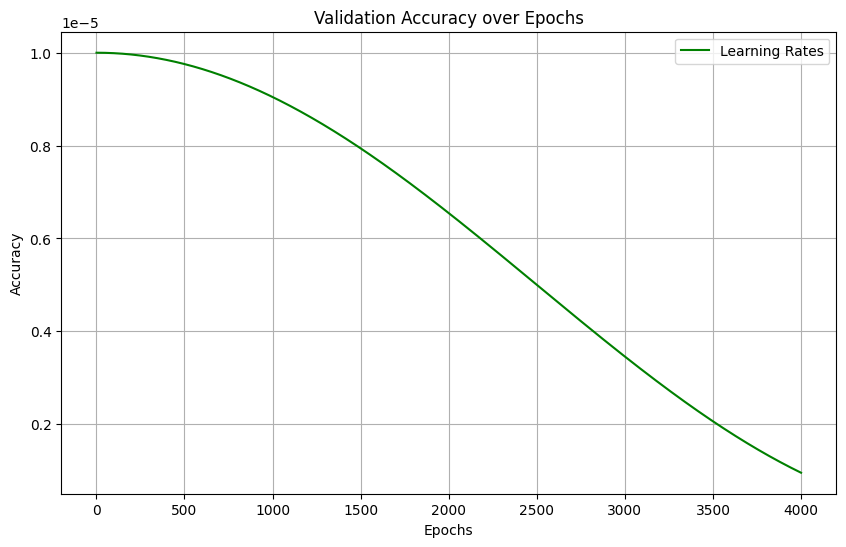

Model for bin 20 saved to GCNModels-5A_exp2/model_bin_20.pth
Training on bin 21/50
Bin 21, Epoch 1/4000, Train Loss: 0.6899, Validation Loss: 0.6670,  Accuracy: 0.7825, LR: 0.000010
Bin 21, Epoch 101/4000, Train Loss: 0.6117, Validation Loss: 0.6399,  Accuracy: 0.8079, LR: 0.000010
Bin 21, Epoch 201/4000, Train Loss: 0.5570, Validation Loss: 0.5741,  Accuracy: 0.8588, LR: 0.000010
Bin 21, Epoch 301/4000, Train Loss: 0.5235, Validation Loss: 0.4930,  Accuracy: 0.8927, LR: 0.000010
Bin 21, Epoch 401/4000, Train Loss: 0.4798, Validation Loss: 0.4578,  Accuracy: 0.8757, LR: 0.000010
Bin 21, Epoch 501/4000, Train Loss: 0.4604, Validation Loss: 0.4059,  Accuracy: 0.8898, LR: 0.000010
Bin 21, Epoch 601/4000, Train Loss: 0.3979, Validation Loss: 0.3703,  Accuracy: 0.8927, LR: 0.000010
Bin 21, Epoch 701/4000, Train Loss: 0.3963, Validation Loss: 0.3615,  Accuracy: 0.8870, LR: 0.000010
Bin 21, Epoch 801/4000, Train Loss: 0.3633, Validation Loss: 0.2959,  Accuracy: 0.9040, LR: 0.000009
Bin 21, Ep

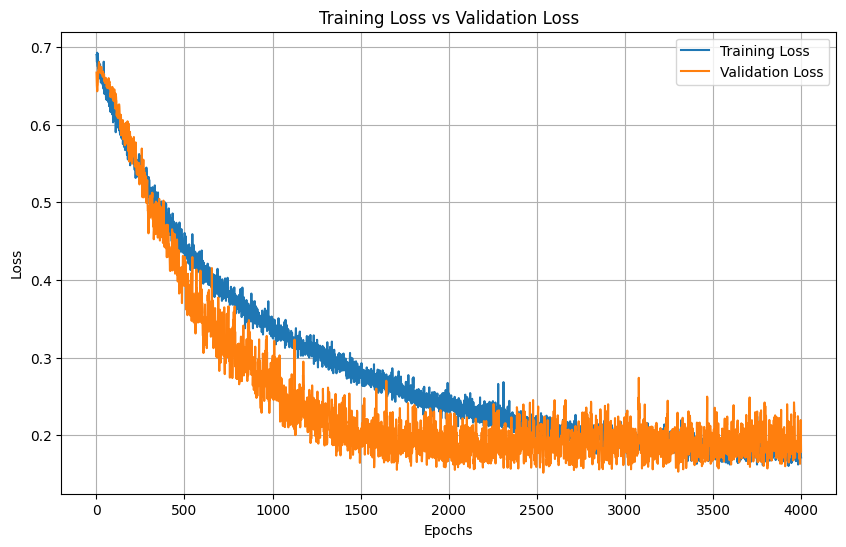

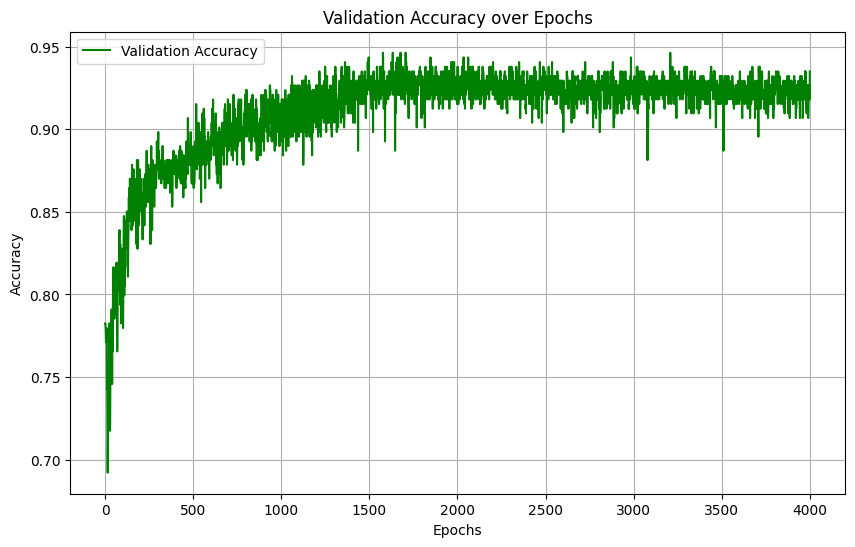

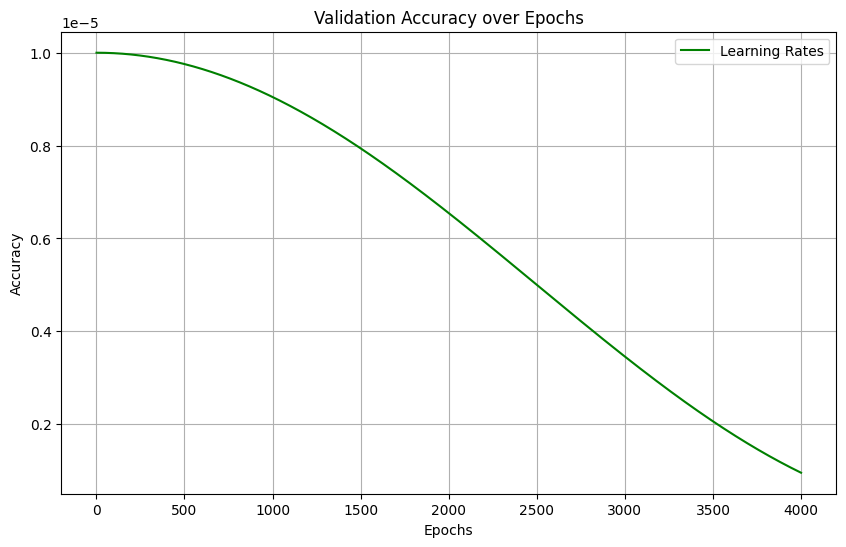

Model for bin 21 saved to GCNModels-5A_exp2/model_bin_21.pth
Training on bin 22/50
Bin 22, Epoch 1/4000, Train Loss: 0.6874, Validation Loss: 0.7225,  Accuracy: 0.2175, LR: 0.000010
Bin 22, Epoch 101/4000, Train Loss: 0.6070, Validation Loss: 0.6572,  Accuracy: 0.7260, LR: 0.000010
Bin 22, Epoch 201/4000, Train Loss: 0.5504, Validation Loss: 0.5695,  Accuracy: 0.8701, LR: 0.000010
Bin 22, Epoch 301/4000, Train Loss: 0.5004, Validation Loss: 0.4774,  Accuracy: 0.8927, LR: 0.000010
Bin 22, Epoch 401/4000, Train Loss: 0.4662, Validation Loss: 0.4433,  Accuracy: 0.8814, LR: 0.000010
Bin 22, Epoch 501/4000, Train Loss: 0.4227, Validation Loss: 0.3674,  Accuracy: 0.9124, LR: 0.000010
Bin 22, Epoch 601/4000, Train Loss: 0.3997, Validation Loss: 0.3733,  Accuracy: 0.8983, LR: 0.000010
Bin 22, Epoch 701/4000, Train Loss: 0.3886, Validation Loss: 0.3583,  Accuracy: 0.8870, LR: 0.000010
Bin 22, Epoch 801/4000, Train Loss: 0.3504, Validation Loss: 0.2860,  Accuracy: 0.9322, LR: 0.000009
Bin 22, Ep

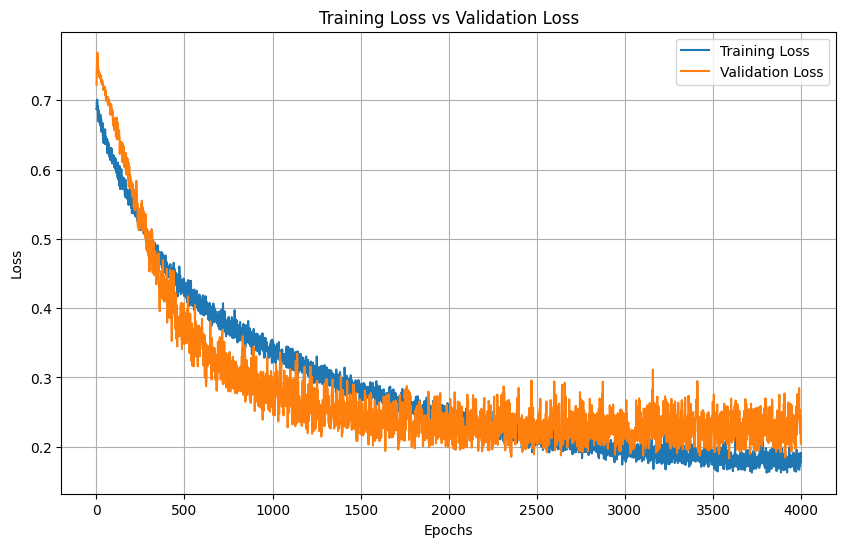

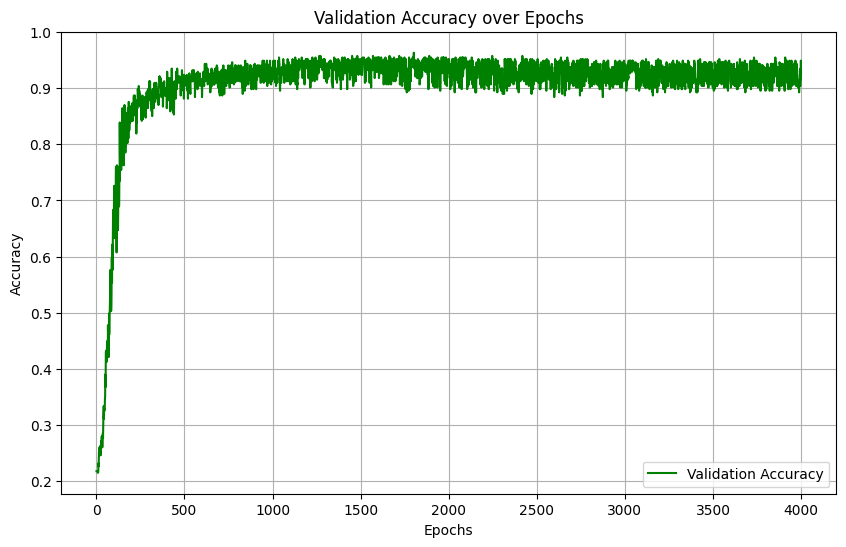

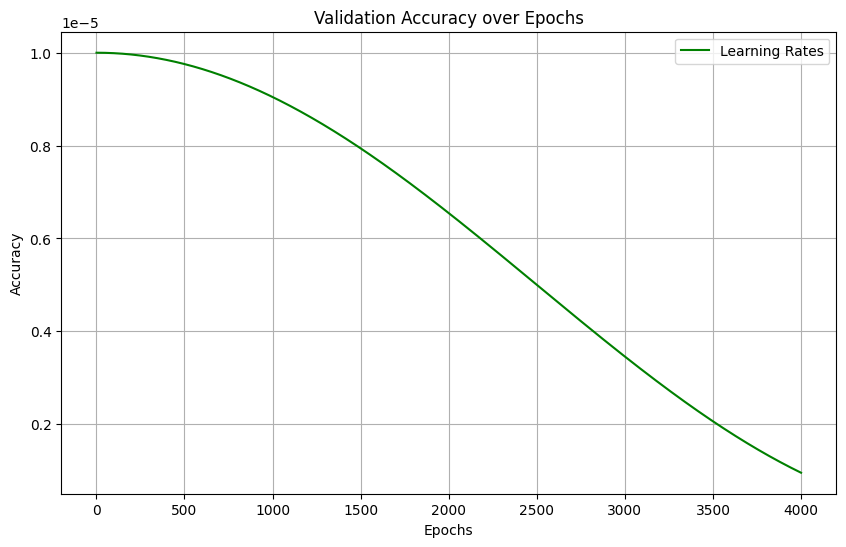

Model for bin 22 saved to GCNModels-5A_exp2/model_bin_22.pth
Training on bin 23/50
Bin 23, Epoch 1/4000, Train Loss: 0.6961, Validation Loss: 0.6808,  Accuracy: 0.7825, LR: 0.000010
Bin 23, Epoch 101/4000, Train Loss: 0.6243, Validation Loss: 0.6480,  Accuracy: 0.7571, LR: 0.000010
Bin 23, Epoch 201/4000, Train Loss: 0.5739, Validation Loss: 0.6126,  Accuracy: 0.8023, LR: 0.000010
Bin 23, Epoch 301/4000, Train Loss: 0.5348, Validation Loss: 0.5467,  Accuracy: 0.8531, LR: 0.000010
Bin 23, Epoch 401/4000, Train Loss: 0.4870, Validation Loss: 0.5340,  Accuracy: 0.8729, LR: 0.000010
Bin 23, Epoch 501/4000, Train Loss: 0.4581, Validation Loss: 0.4676,  Accuracy: 0.8983, LR: 0.000010
Bin 23, Epoch 601/4000, Train Loss: 0.4176, Validation Loss: 0.4124,  Accuracy: 0.9096, LR: 0.000010
Bin 23, Epoch 701/4000, Train Loss: 0.4002, Validation Loss: 0.4157,  Accuracy: 0.9153, LR: 0.000010
Bin 23, Epoch 801/4000, Train Loss: 0.3829, Validation Loss: 0.4059,  Accuracy: 0.9181, LR: 0.000009
Bin 23, Ep

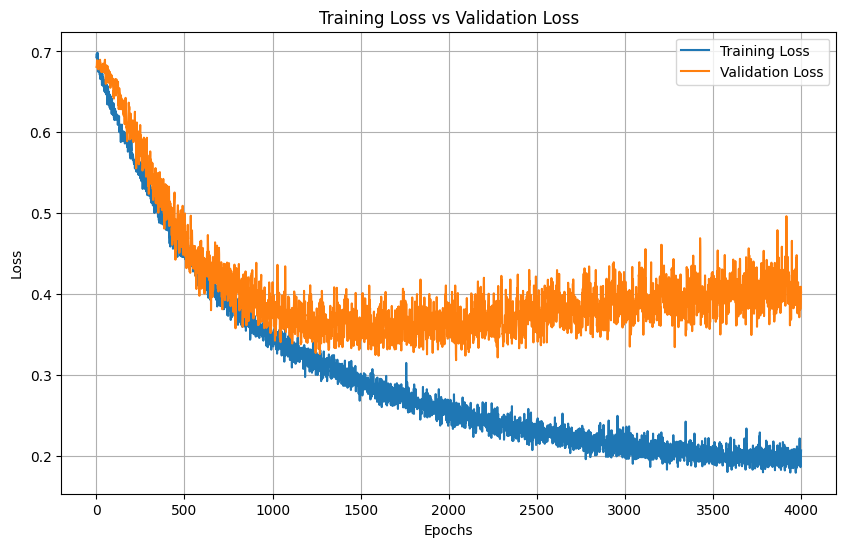

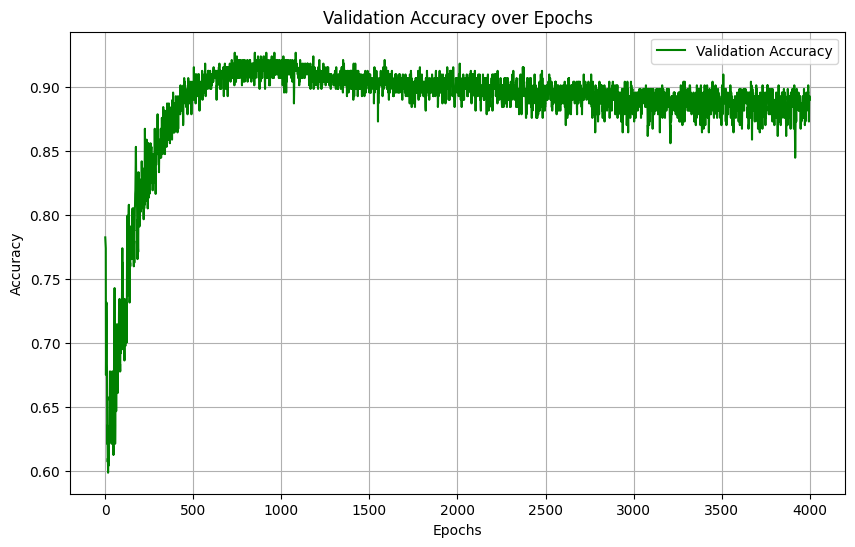

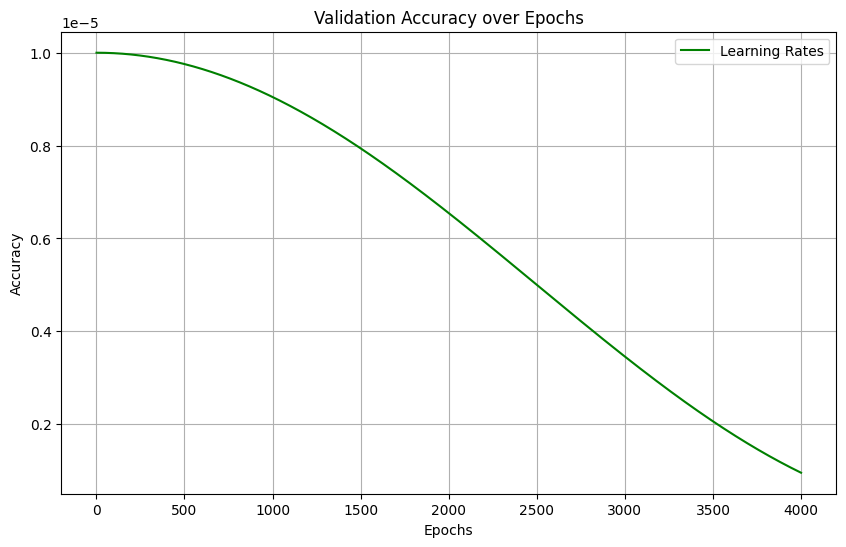

Model for bin 23 saved to GCNModels-5A_exp2/model_bin_23.pth
Training on bin 24/50
Bin 24, Epoch 1/4000, Train Loss: 0.7365, Validation Loss: 0.6517,  Accuracy: 0.7825, LR: 0.000010
Bin 24, Epoch 101/4000, Train Loss: 0.6274, Validation Loss: 0.5865,  Accuracy: 0.8672, LR: 0.000010
Bin 24, Epoch 201/4000, Train Loss: 0.5520, Validation Loss: 0.5399,  Accuracy: 0.8616, LR: 0.000010
Bin 24, Epoch 301/4000, Train Loss: 0.5283, Validation Loss: 0.4690,  Accuracy: 0.8729, LR: 0.000010
Bin 24, Epoch 401/4000, Train Loss: 0.4925, Validation Loss: 0.4226,  Accuracy: 0.8729, LR: 0.000010
Bin 24, Epoch 501/4000, Train Loss: 0.4659, Validation Loss: 0.4111,  Accuracy: 0.8672, LR: 0.000010
Bin 24, Epoch 601/4000, Train Loss: 0.4584, Validation Loss: 0.3692,  Accuracy: 0.8870, LR: 0.000010
Bin 24, Epoch 701/4000, Train Loss: 0.4015, Validation Loss: 0.3557,  Accuracy: 0.8898, LR: 0.000010
Bin 24, Epoch 801/4000, Train Loss: 0.4005, Validation Loss: 0.2979,  Accuracy: 0.9181, LR: 0.000009
Bin 24, Ep

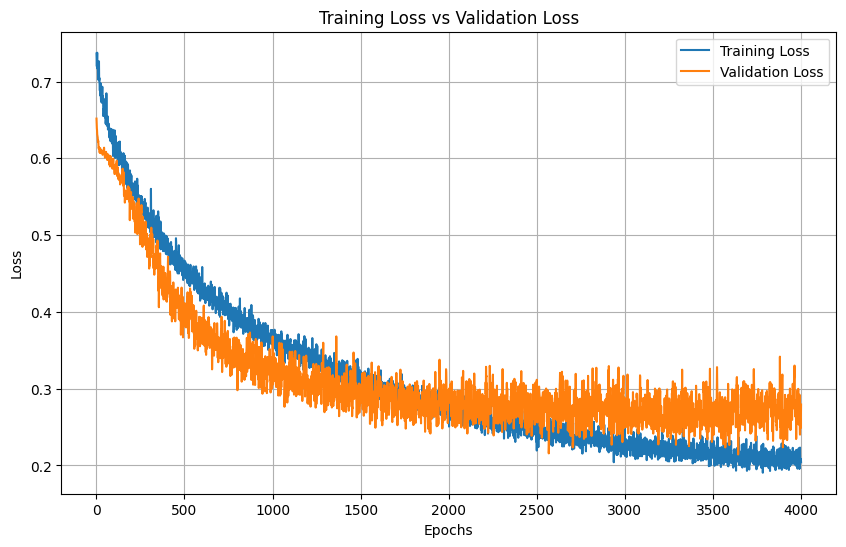

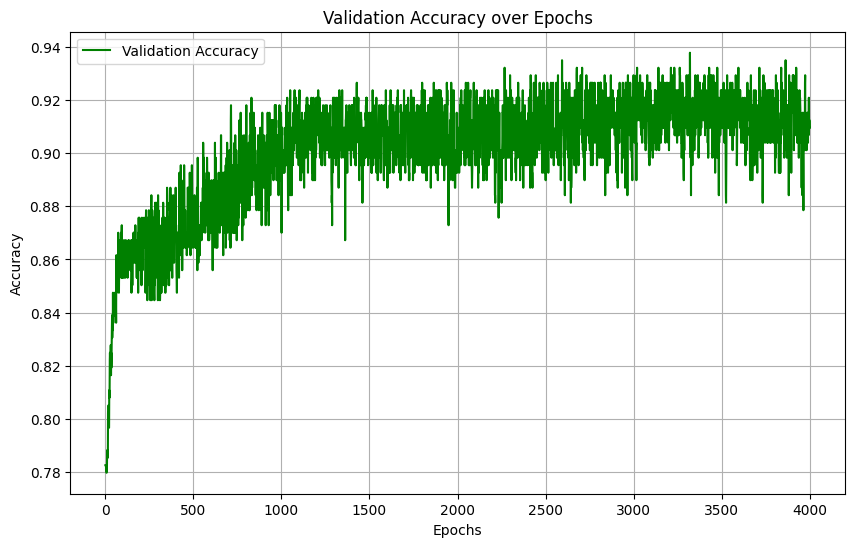

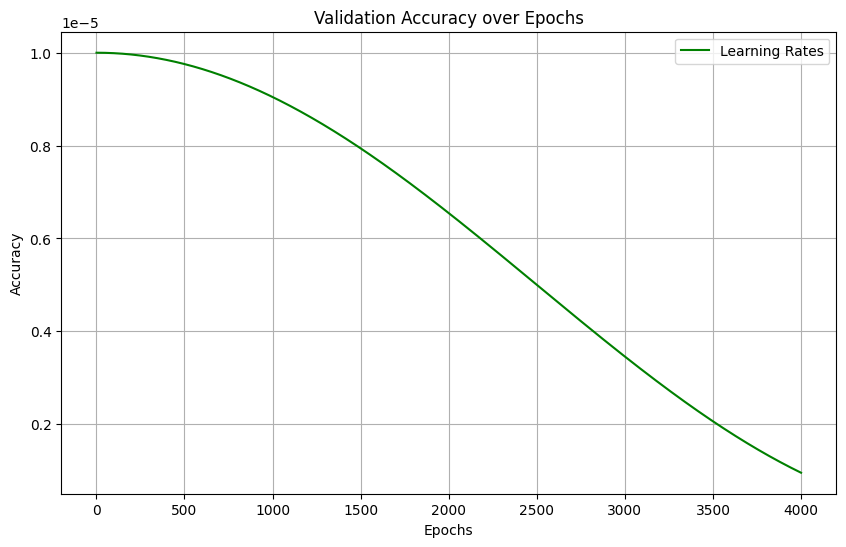

Model for bin 24 saved to GCNModels-5A_exp2/model_bin_24.pth
Training on bin 25/50
Bin 25, Epoch 1/4000, Train Loss: 0.7032, Validation Loss: 0.6922,  Accuracy: 0.7712, LR: 0.000010
Bin 25, Epoch 101/4000, Train Loss: 0.6418, Validation Loss: 0.6463,  Accuracy: 0.7655, LR: 0.000010
Bin 25, Epoch 201/4000, Train Loss: 0.5984, Validation Loss: 0.5769,  Accuracy: 0.8333, LR: 0.000010
Bin 25, Epoch 301/4000, Train Loss: 0.5773, Validation Loss: 0.5618,  Accuracy: 0.8079, LR: 0.000010
Bin 25, Epoch 401/4000, Train Loss: 0.5330, Validation Loss: 0.5023,  Accuracy: 0.8362, LR: 0.000010
Bin 25, Epoch 501/4000, Train Loss: 0.5066, Validation Loss: 0.4661,  Accuracy: 0.8475, LR: 0.000010
Bin 25, Epoch 601/4000, Train Loss: 0.4965, Validation Loss: 0.3832,  Accuracy: 0.8814, LR: 0.000010
Bin 25, Epoch 701/4000, Train Loss: 0.4453, Validation Loss: 0.3556,  Accuracy: 0.8983, LR: 0.000010
Bin 25, Epoch 801/4000, Train Loss: 0.4494, Validation Loss: 0.3484,  Accuracy: 0.8983, LR: 0.000009
Bin 25, Ep

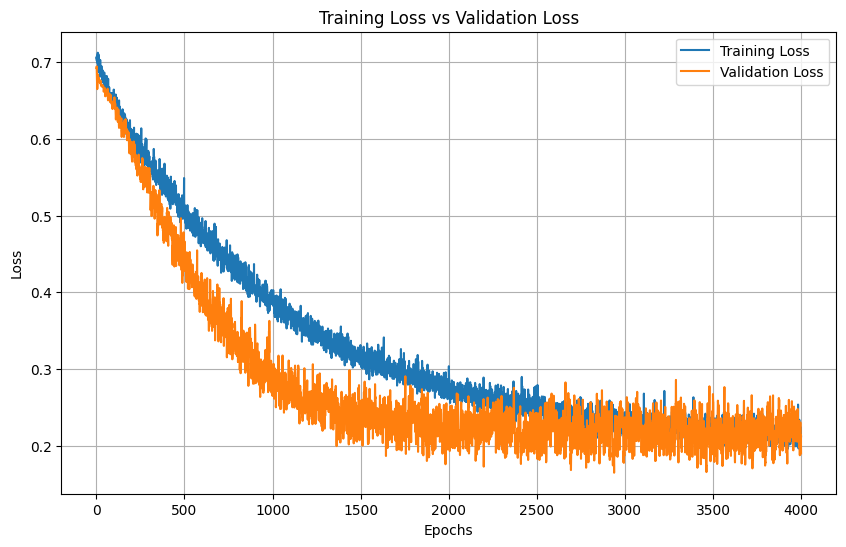

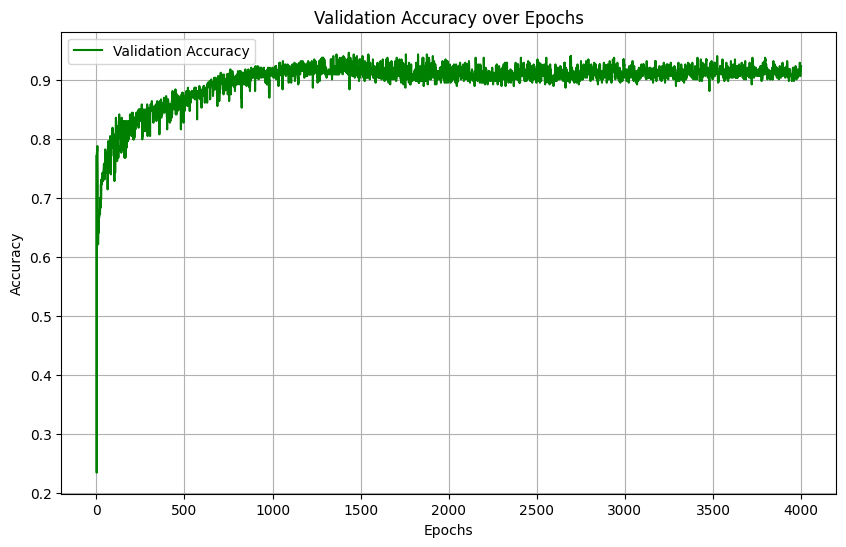

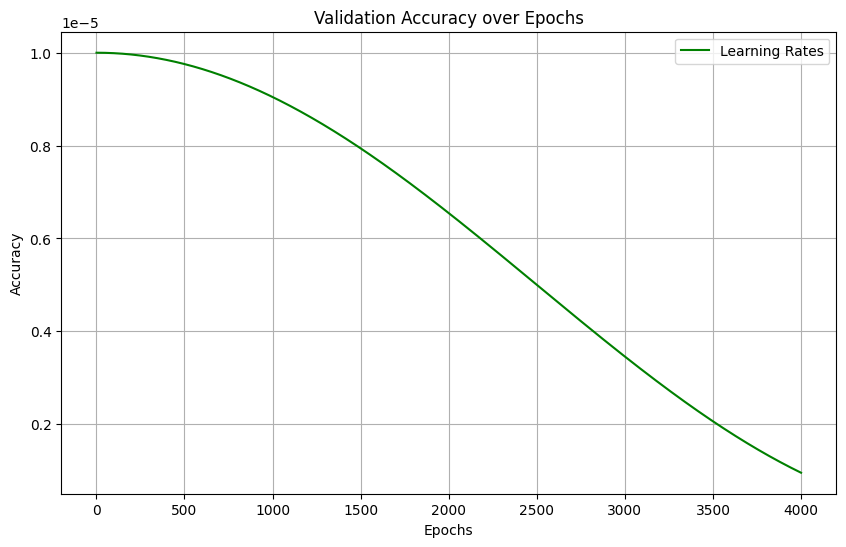

Model for bin 25 saved to GCNModels-5A_exp2/model_bin_25.pth
Training on bin 26/50
Bin 26, Epoch 1/4000, Train Loss: 0.7272, Validation Loss: 0.6935,  Accuracy: 0.3333, LR: 0.000010
Bin 26, Epoch 101/4000, Train Loss: 0.6439, Validation Loss: 0.6459,  Accuracy: 0.7768, LR: 0.000010
Bin 26, Epoch 201/4000, Train Loss: 0.5858, Validation Loss: 0.5786,  Accuracy: 0.8503, LR: 0.000010
Bin 26, Epoch 301/4000, Train Loss: 0.5701, Validation Loss: 0.5331,  Accuracy: 0.8446, LR: 0.000010
Bin 26, Epoch 401/4000, Train Loss: 0.5313, Validation Loss: 0.4885,  Accuracy: 0.8531, LR: 0.000010
Bin 26, Epoch 501/4000, Train Loss: 0.4951, Validation Loss: 0.4085,  Accuracy: 0.8870, LR: 0.000010
Bin 26, Epoch 601/4000, Train Loss: 0.4696, Validation Loss: 0.3898,  Accuracy: 0.8983, LR: 0.000010
Bin 26, Epoch 701/4000, Train Loss: 0.4522, Validation Loss: 0.3580,  Accuracy: 0.9011, LR: 0.000010
Bin 26, Epoch 801/4000, Train Loss: 0.4221, Validation Loss: 0.3263,  Accuracy: 0.9124, LR: 0.000009
Bin 26, Ep

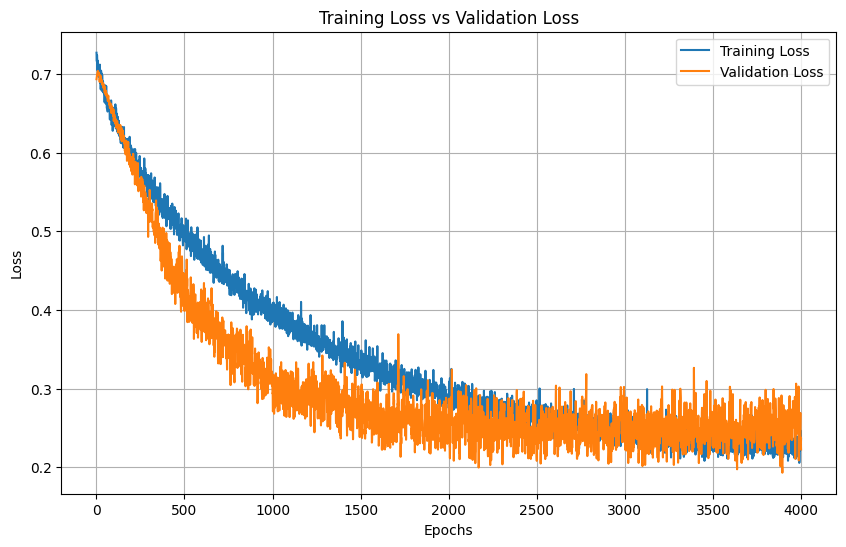

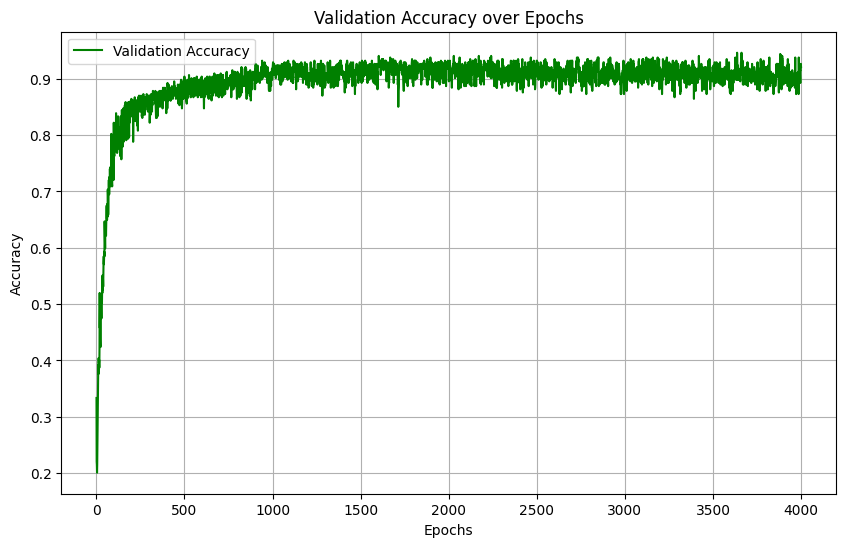

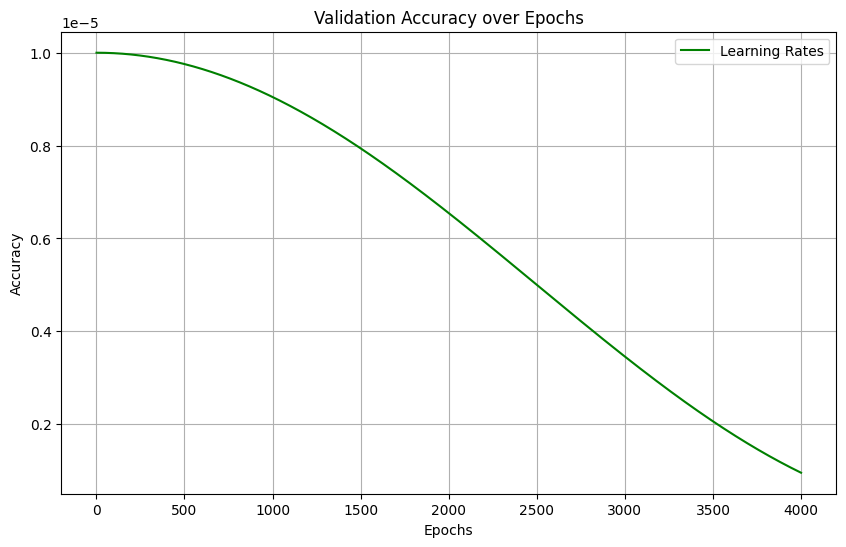

Model for bin 26 saved to GCNModels-5A_exp2/model_bin_26.pth
Training on bin 27/50
Bin 27, Epoch 1/4000, Train Loss: 0.6887, Validation Loss: 0.7201,  Accuracy: 0.2175, LR: 0.000010
Bin 27, Epoch 101/4000, Train Loss: 0.6068, Validation Loss: 0.6685,  Accuracy: 0.6610, LR: 0.000010
Bin 27, Epoch 201/4000, Train Loss: 0.5494, Validation Loss: 0.5776,  Accuracy: 0.8192, LR: 0.000010
Bin 27, Epoch 301/4000, Train Loss: 0.5096, Validation Loss: 0.4712,  Accuracy: 0.8785, LR: 0.000010
Bin 27, Epoch 401/4000, Train Loss: 0.4543, Validation Loss: 0.4338,  Accuracy: 0.8983, LR: 0.000010
Bin 27, Epoch 501/4000, Train Loss: 0.4161, Validation Loss: 0.3753,  Accuracy: 0.9124, LR: 0.000010
Bin 27, Epoch 601/4000, Train Loss: 0.3977, Validation Loss: 0.3792,  Accuracy: 0.9153, LR: 0.000010
Bin 27, Epoch 701/4000, Train Loss: 0.3720, Validation Loss: 0.3961,  Accuracy: 0.8983, LR: 0.000010
Bin 27, Epoch 801/4000, Train Loss: 0.3450, Validation Loss: 0.3816,  Accuracy: 0.8955, LR: 0.000009
Bin 27, Ep

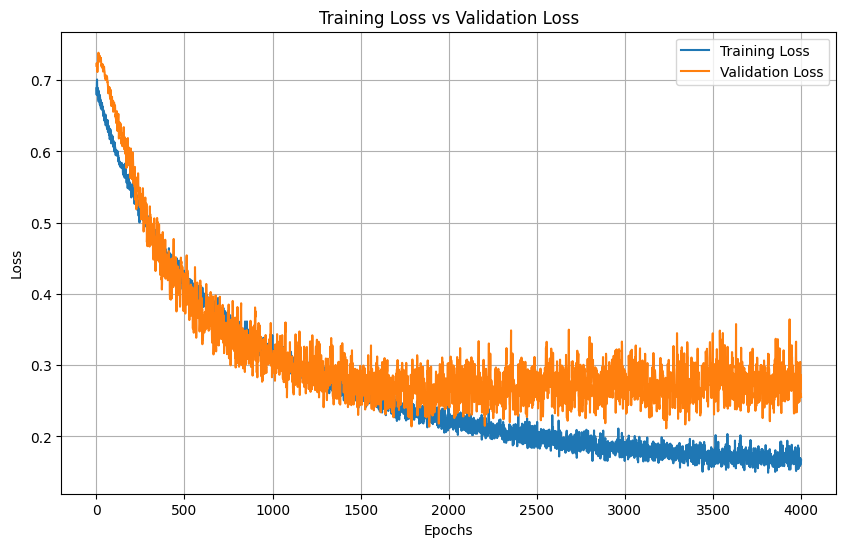

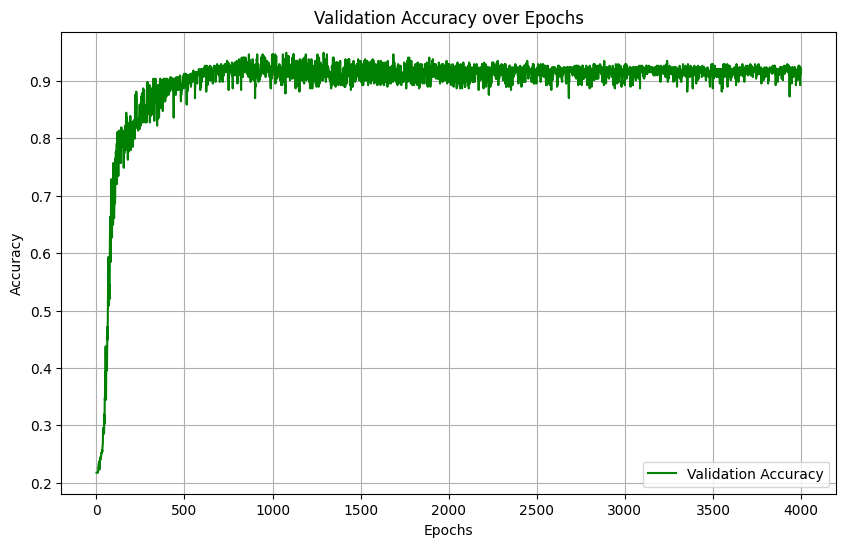

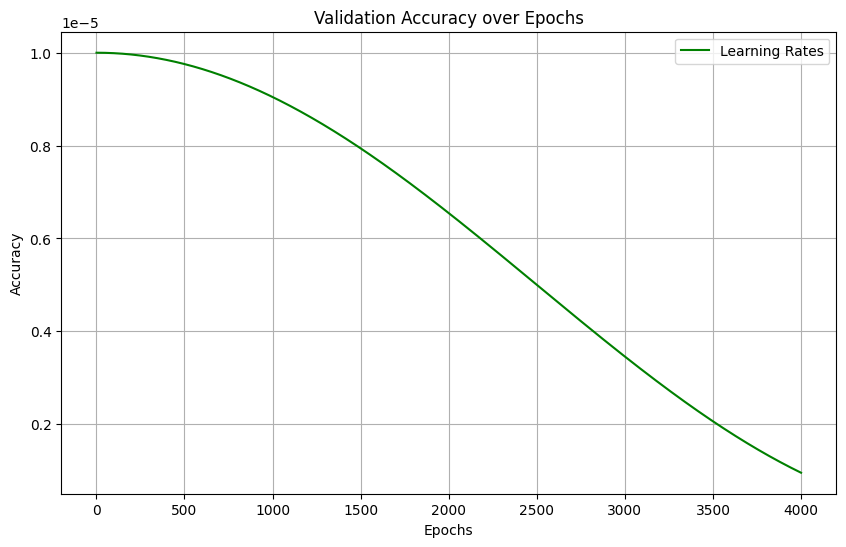

Model for bin 27 saved to GCNModels-5A_exp2/model_bin_27.pth
Training on bin 28/50
Bin 28, Epoch 1/4000, Train Loss: 0.7556, Validation Loss: 0.6687,  Accuracy: 0.7825, LR: 0.000010
Bin 28, Epoch 101/4000, Train Loss: 0.6150, Validation Loss: 0.6012,  Accuracy: 0.8672, LR: 0.000010
Bin 28, Epoch 201/4000, Train Loss: 0.5523, Validation Loss: 0.5345,  Accuracy: 0.8644, LR: 0.000010
Bin 28, Epoch 301/4000, Train Loss: 0.5041, Validation Loss: 0.4879,  Accuracy: 0.8701, LR: 0.000010
Bin 28, Epoch 401/4000, Train Loss: 0.4595, Validation Loss: 0.4219,  Accuracy: 0.8955, LR: 0.000010
Bin 28, Epoch 501/4000, Train Loss: 0.4230, Validation Loss: 0.3692,  Accuracy: 0.9096, LR: 0.000010
Bin 28, Epoch 601/4000, Train Loss: 0.4037, Validation Loss: 0.3462,  Accuracy: 0.9181, LR: 0.000010
Bin 28, Epoch 701/4000, Train Loss: 0.3908, Validation Loss: 0.3123,  Accuracy: 0.9266, LR: 0.000010
Bin 28, Epoch 801/4000, Train Loss: 0.3562, Validation Loss: 0.3137,  Accuracy: 0.9237, LR: 0.000009
Bin 28, Ep

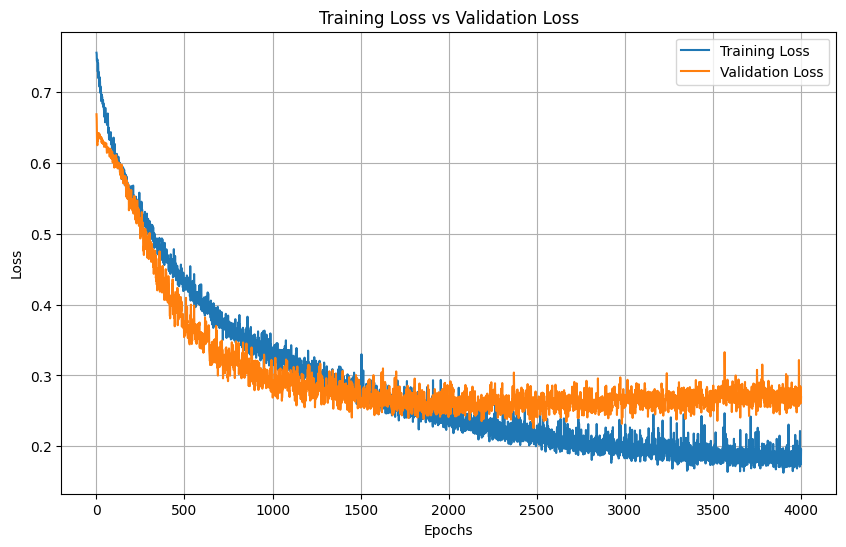

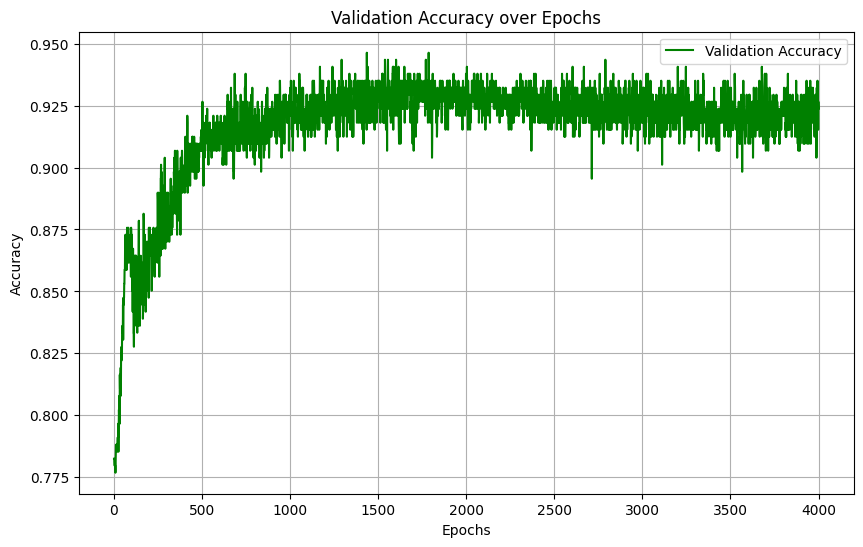

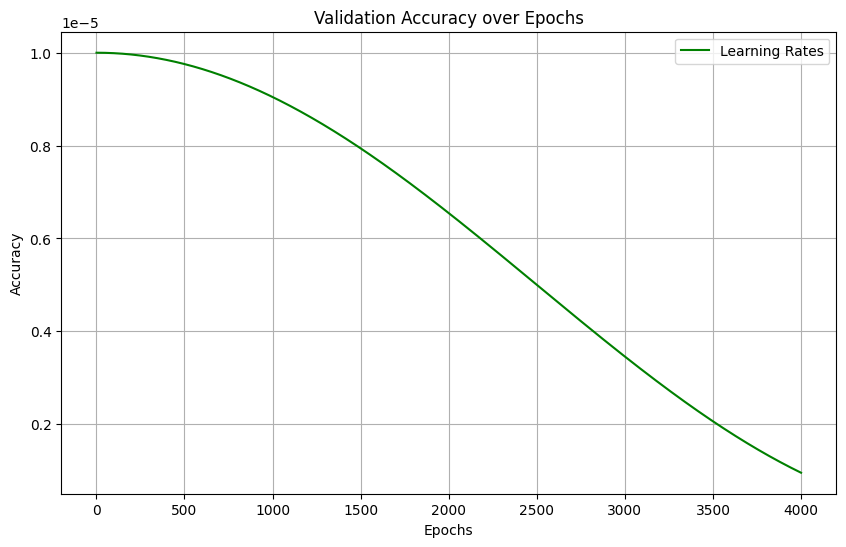

Model for bin 28 saved to GCNModels-5A_exp2/model_bin_28.pth
Training on bin 29/50
Bin 29, Epoch 1/4000, Train Loss: 0.6802, Validation Loss: 0.6882,  Accuracy: 0.7797, LR: 0.000010
Bin 29, Epoch 101/4000, Train Loss: 0.6035, Validation Loss: 0.6154,  Accuracy: 0.8136, LR: 0.000010
Bin 29, Epoch 201/4000, Train Loss: 0.5457, Validation Loss: 0.5141,  Accuracy: 0.8446, LR: 0.000010
Bin 29, Epoch 301/4000, Train Loss: 0.5026, Validation Loss: 0.4741,  Accuracy: 0.8418, LR: 0.000010
Bin 29, Epoch 401/4000, Train Loss: 0.4600, Validation Loss: 0.4042,  Accuracy: 0.8814, LR: 0.000010
Bin 29, Epoch 501/4000, Train Loss: 0.4323, Validation Loss: 0.3660,  Accuracy: 0.8729, LR: 0.000010
Bin 29, Epoch 601/4000, Train Loss: 0.4053, Validation Loss: 0.3505,  Accuracy: 0.8814, LR: 0.000010
Bin 29, Epoch 701/4000, Train Loss: 0.3807, Validation Loss: 0.3129,  Accuracy: 0.9153, LR: 0.000010
Bin 29, Epoch 801/4000, Train Loss: 0.3703, Validation Loss: 0.2772,  Accuracy: 0.9153, LR: 0.000009
Bin 29, Ep

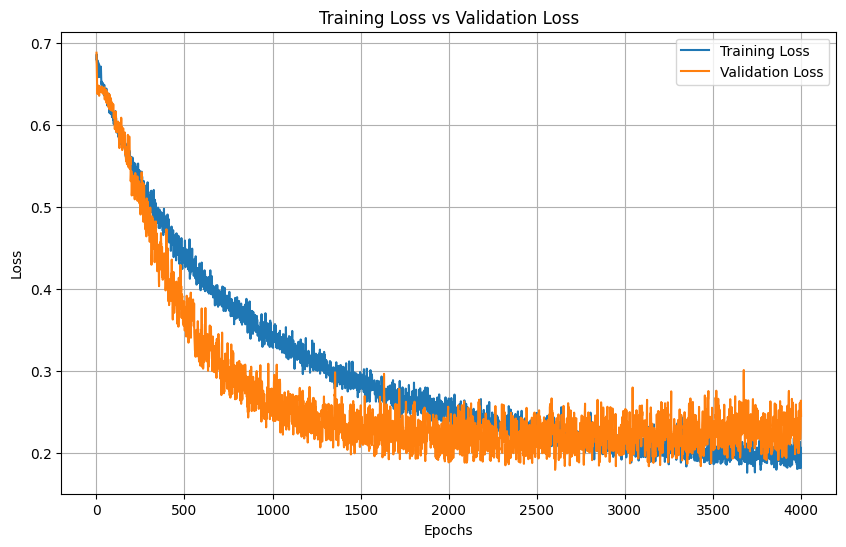

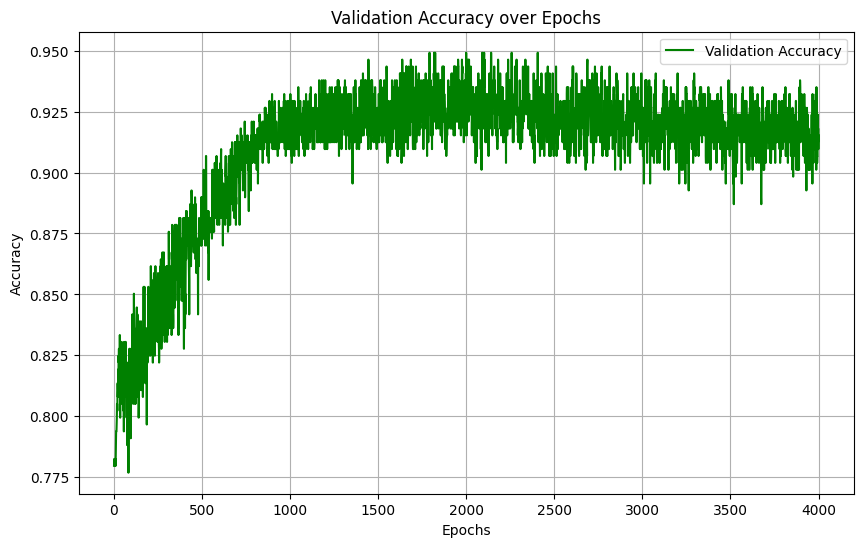

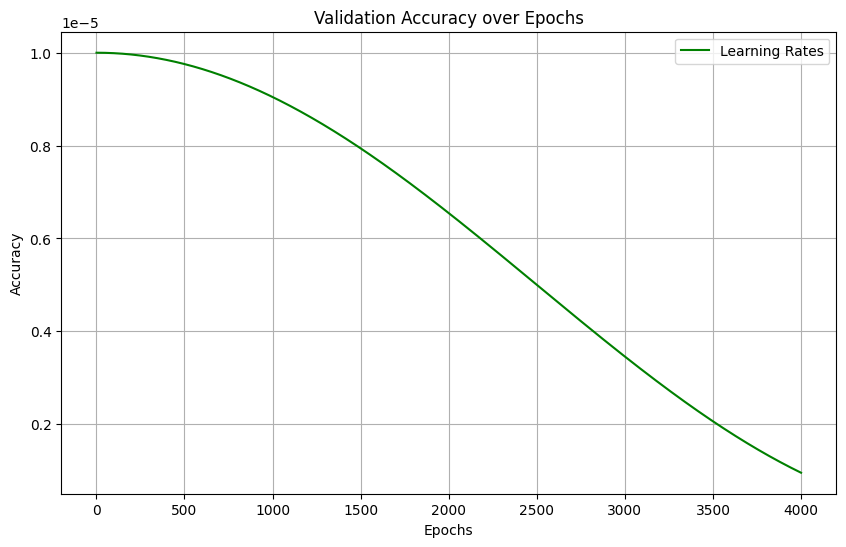

Model for bin 29 saved to GCNModels-5A_exp2/model_bin_29.pth
Training on bin 30/50
Bin 30, Epoch 1/4000, Train Loss: 0.6998, Validation Loss: 0.7067,  Accuracy: 0.2175, LR: 0.000010
Bin 30, Epoch 101/4000, Train Loss: 0.6026, Validation Loss: 0.6710,  Accuracy: 0.7175, LR: 0.000010
Bin 30, Epoch 201/4000, Train Loss: 0.5587, Validation Loss: 0.6032,  Accuracy: 0.8164, LR: 0.000010
Bin 30, Epoch 301/4000, Train Loss: 0.4770, Validation Loss: 0.5585,  Accuracy: 0.8277, LR: 0.000010
Bin 30, Epoch 401/4000, Train Loss: 0.4490, Validation Loss: 0.5075,  Accuracy: 0.8616, LR: 0.000010
Bin 30, Epoch 501/4000, Train Loss: 0.4216, Validation Loss: 0.4843,  Accuracy: 0.8757, LR: 0.000010
Bin 30, Epoch 601/4000, Train Loss: 0.3974, Validation Loss: 0.4572,  Accuracy: 0.8983, LR: 0.000010
Bin 30, Epoch 701/4000, Train Loss: 0.3701, Validation Loss: 0.4027,  Accuracy: 0.9040, LR: 0.000010
Bin 30, Epoch 801/4000, Train Loss: 0.3486, Validation Loss: 0.4325,  Accuracy: 0.8955, LR: 0.000009
Bin 30, Ep

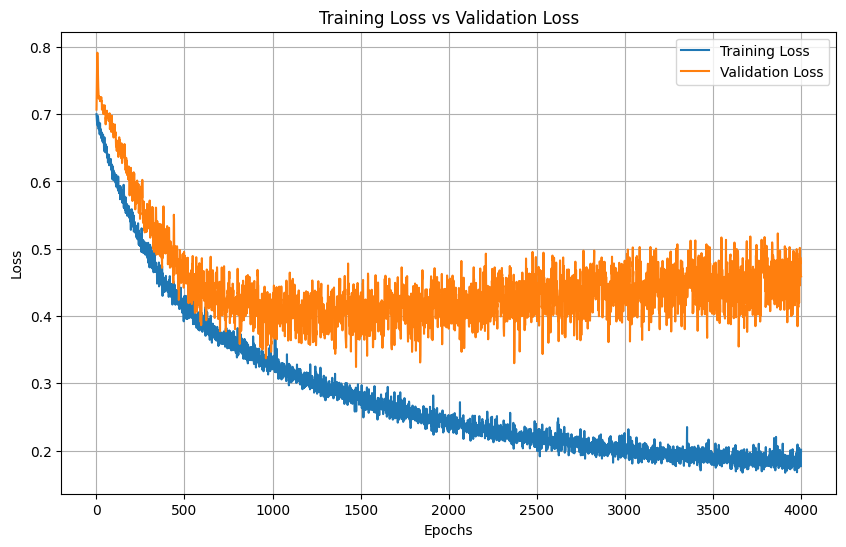

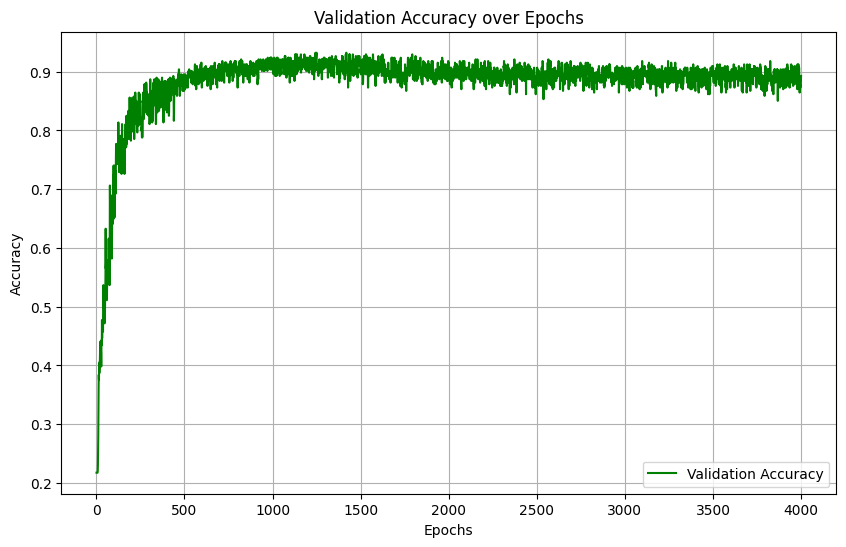

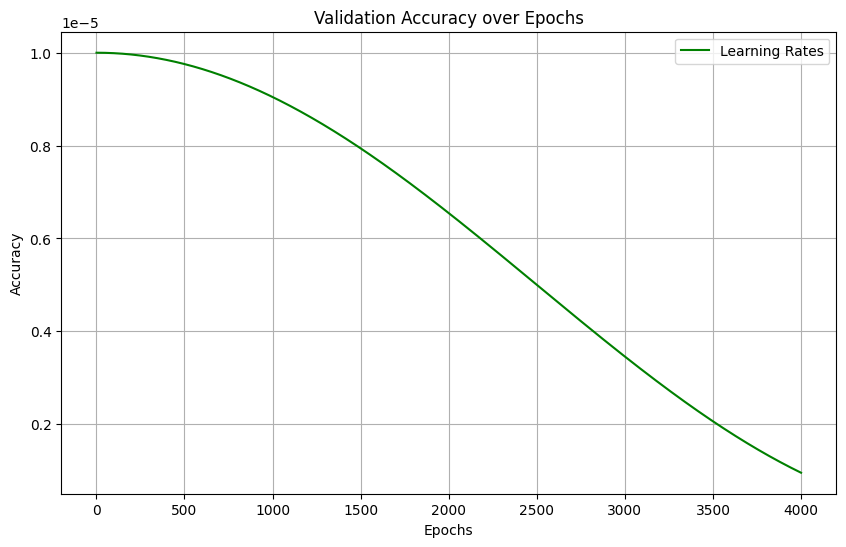

Model for bin 30 saved to GCNModels-5A_exp2/model_bin_30.pth
Training on bin 31/50
Bin 31, Epoch 1/4000, Train Loss: 0.7227, Validation Loss: 0.6810,  Accuracy: 0.7825, LR: 0.000010
Bin 31, Epoch 101/4000, Train Loss: 0.5979, Validation Loss: 0.6201,  Accuracy: 0.8446, LR: 0.000010
Bin 31, Epoch 201/4000, Train Loss: 0.5359, Validation Loss: 0.5339,  Accuracy: 0.9011, LR: 0.000010
Bin 31, Epoch 301/4000, Train Loss: 0.4750, Validation Loss: 0.5099,  Accuracy: 0.8898, LR: 0.000010
Bin 31, Epoch 401/4000, Train Loss: 0.4437, Validation Loss: 0.4603,  Accuracy: 0.9068, LR: 0.000010
Bin 31, Epoch 501/4000, Train Loss: 0.3899, Validation Loss: 0.4476,  Accuracy: 0.9068, LR: 0.000010
Bin 31, Epoch 601/4000, Train Loss: 0.3728, Validation Loss: 0.4370,  Accuracy: 0.9153, LR: 0.000010
Bin 31, Epoch 701/4000, Train Loss: 0.3559, Validation Loss: 0.3902,  Accuracy: 0.9266, LR: 0.000010
Bin 31, Epoch 801/4000, Train Loss: 0.3376, Validation Loss: 0.3772,  Accuracy: 0.9294, LR: 0.000009
Bin 31, Ep

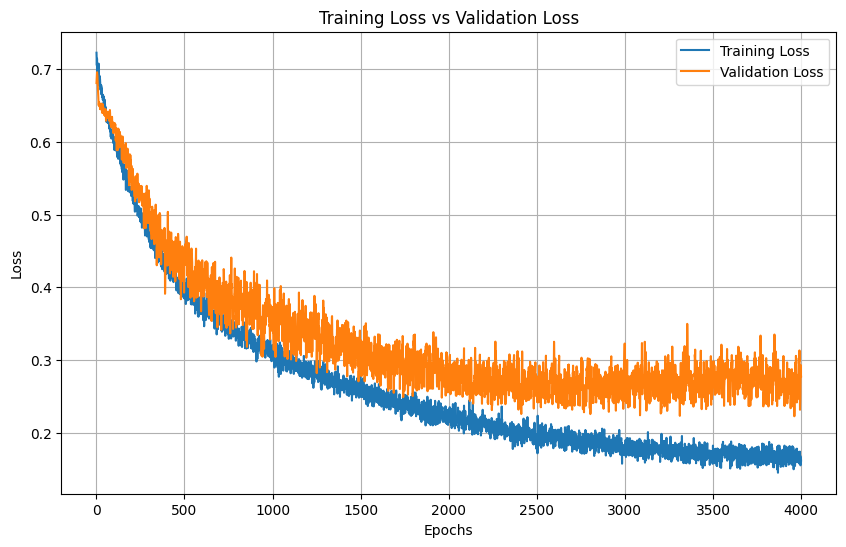

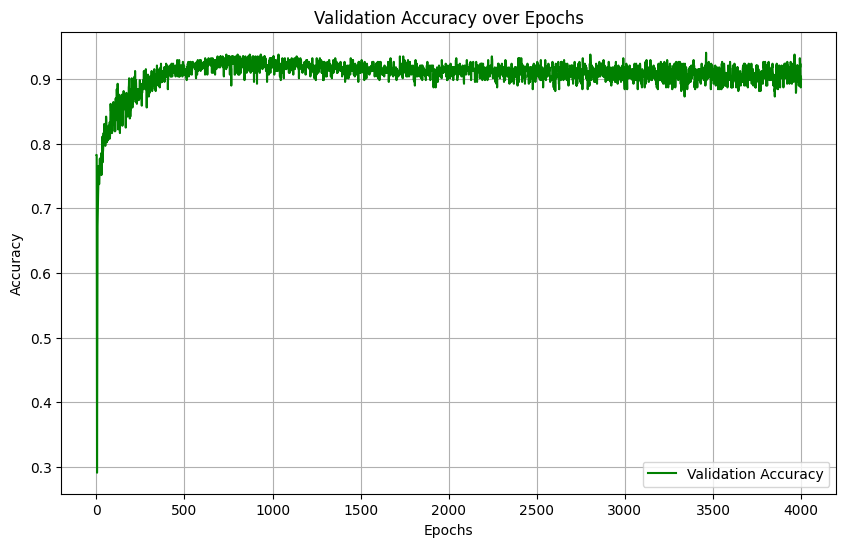

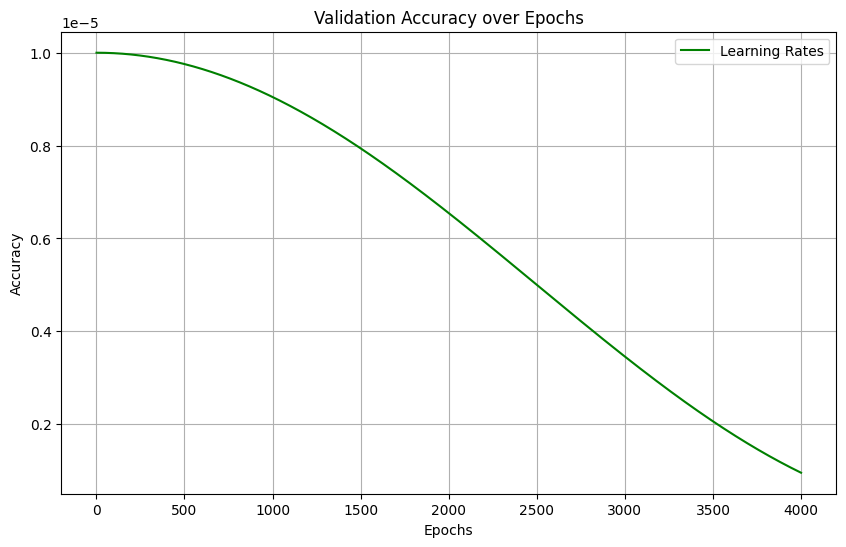

Model for bin 31 saved to GCNModels-5A_exp2/model_bin_31.pth
Training on bin 32/50
Bin 32, Epoch 1/4000, Train Loss: 0.7114, Validation Loss: 0.6767,  Accuracy: 0.7825, LR: 0.000010
Bin 32, Epoch 101/4000, Train Loss: 0.6034, Validation Loss: 0.6270,  Accuracy: 0.8757, LR: 0.000010
Bin 32, Epoch 201/4000, Train Loss: 0.5454, Validation Loss: 0.5762,  Accuracy: 0.8701, LR: 0.000010
Bin 32, Epoch 301/4000, Train Loss: 0.4881, Validation Loss: 0.5281,  Accuracy: 0.8672, LR: 0.000010
Bin 32, Epoch 401/4000, Train Loss: 0.4247, Validation Loss: 0.4963,  Accuracy: 0.8729, LR: 0.000010
Bin 32, Epoch 501/4000, Train Loss: 0.4158, Validation Loss: 0.4488,  Accuracy: 0.8927, LR: 0.000010
Bin 32, Epoch 601/4000, Train Loss: 0.3987, Validation Loss: 0.4293,  Accuracy: 0.8898, LR: 0.000010
Bin 32, Epoch 701/4000, Train Loss: 0.3685, Validation Loss: 0.4229,  Accuracy: 0.8870, LR: 0.000010
Bin 32, Epoch 801/4000, Train Loss: 0.3654, Validation Loss: 0.3938,  Accuracy: 0.9040, LR: 0.000009
Bin 32, Ep

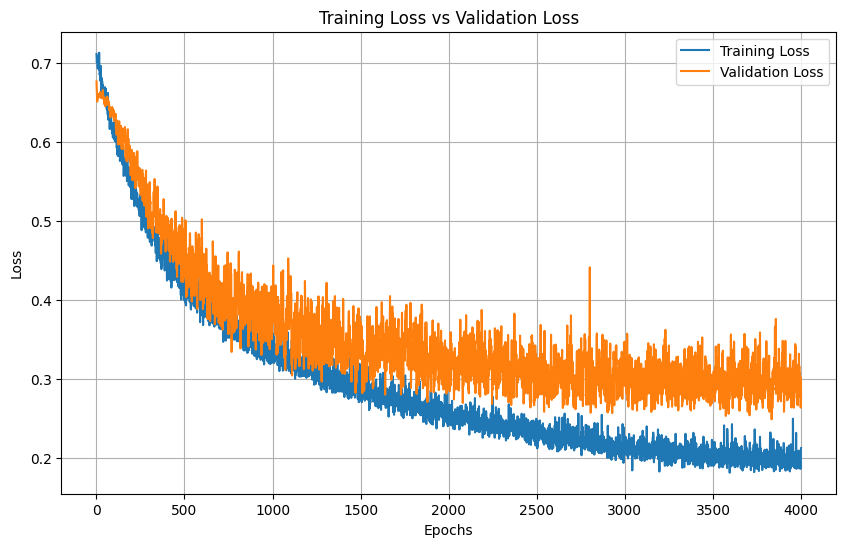

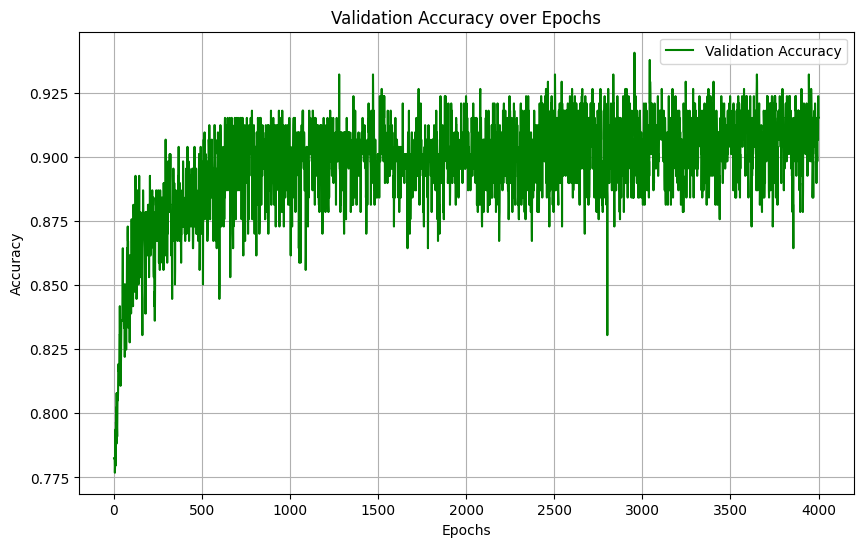

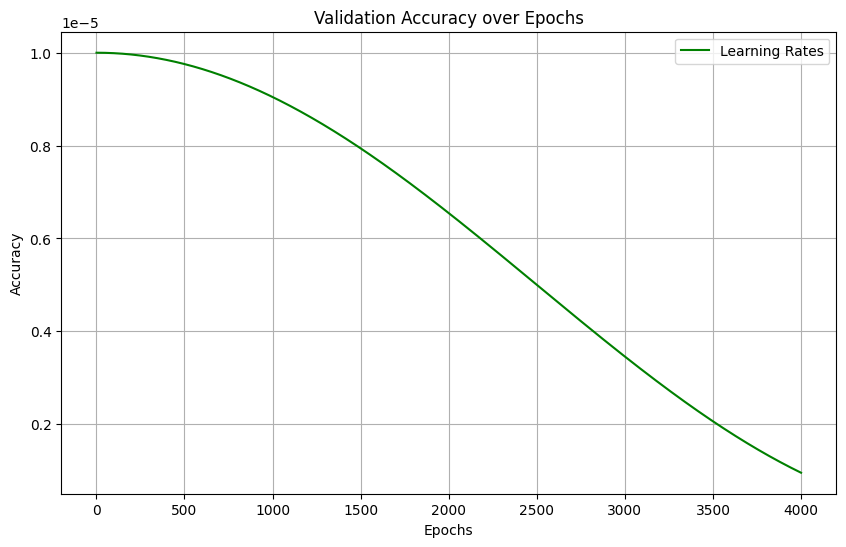

Model for bin 32 saved to GCNModels-5A_exp2/model_bin_32.pth
Training on bin 33/50
Bin 33, Epoch 1/4000, Train Loss: 0.7278, Validation Loss: 0.7033,  Accuracy: 0.2175, LR: 0.000010
Bin 33, Epoch 101/4000, Train Loss: 0.6411, Validation Loss: 0.6728,  Accuracy: 0.7373, LR: 0.000010
Bin 33, Epoch 201/4000, Train Loss: 0.6053, Validation Loss: 0.6249,  Accuracy: 0.8051, LR: 0.000010
Bin 33, Epoch 301/4000, Train Loss: 0.5617, Validation Loss: 0.5257,  Accuracy: 0.8531, LR: 0.000010
Bin 33, Epoch 401/4000, Train Loss: 0.5175, Validation Loss: 0.4566,  Accuracy: 0.8814, LR: 0.000010
Bin 33, Epoch 501/4000, Train Loss: 0.4771, Validation Loss: 0.4455,  Accuracy: 0.8644, LR: 0.000010
Bin 33, Epoch 601/4000, Train Loss: 0.4503, Validation Loss: 0.4086,  Accuracy: 0.8672, LR: 0.000010
Bin 33, Epoch 701/4000, Train Loss: 0.4310, Validation Loss: 0.3768,  Accuracy: 0.8757, LR: 0.000010
Bin 33, Epoch 801/4000, Train Loss: 0.4136, Validation Loss: 0.3501,  Accuracy: 0.8842, LR: 0.000009
Bin 33, Ep

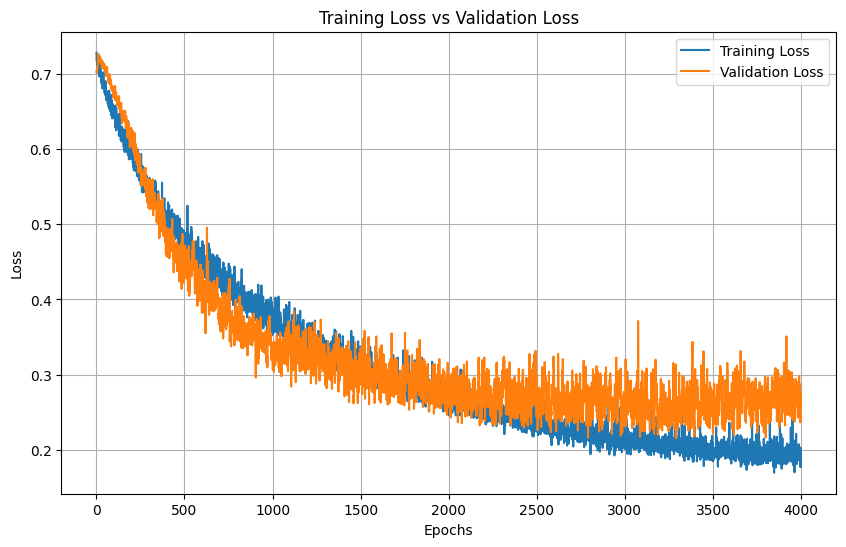

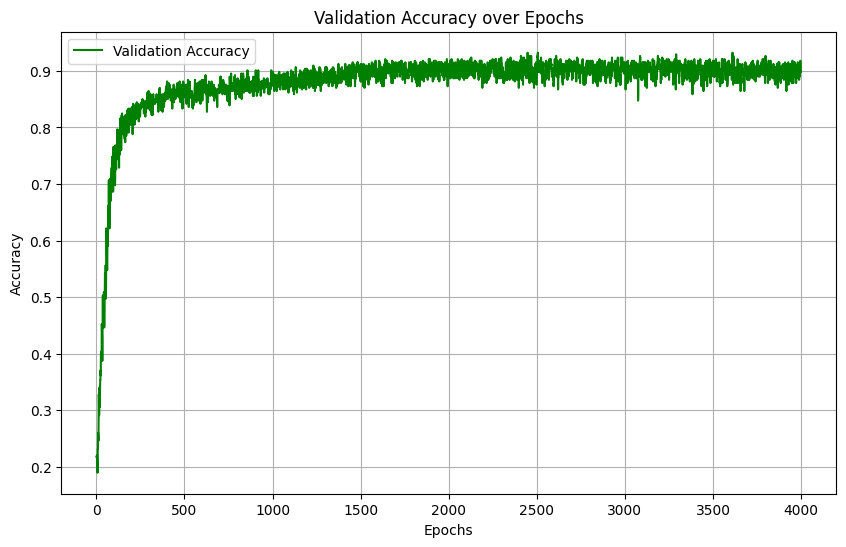

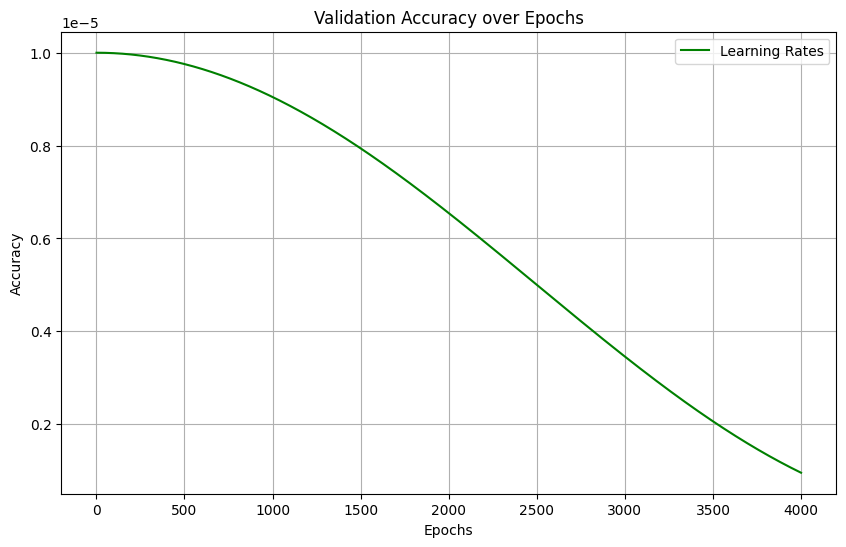

Model for bin 33 saved to GCNModels-5A_exp2/model_bin_33.pth
Training on bin 34/50
Bin 34, Epoch 1/4000, Train Loss: 0.7022, Validation Loss: 0.6890,  Accuracy: 0.7825, LR: 0.000010
Bin 34, Epoch 101/4000, Train Loss: 0.5947, Validation Loss: 0.5843,  Accuracy: 0.8616, LR: 0.000010
Bin 34, Epoch 201/4000, Train Loss: 0.5260, Validation Loss: 0.5312,  Accuracy: 0.8588, LR: 0.000010
Bin 34, Epoch 301/4000, Train Loss: 0.4801, Validation Loss: 0.4826,  Accuracy: 0.8870, LR: 0.000010
Bin 34, Epoch 401/4000, Train Loss: 0.4456, Validation Loss: 0.3999,  Accuracy: 0.8955, LR: 0.000010
Bin 34, Epoch 501/4000, Train Loss: 0.3992, Validation Loss: 0.4124,  Accuracy: 0.9011, LR: 0.000010
Bin 34, Epoch 601/4000, Train Loss: 0.3829, Validation Loss: 0.3929,  Accuracy: 0.9096, LR: 0.000010
Bin 34, Epoch 701/4000, Train Loss: 0.3596, Validation Loss: 0.3870,  Accuracy: 0.8983, LR: 0.000010
Bin 34, Epoch 801/4000, Train Loss: 0.3550, Validation Loss: 0.3575,  Accuracy: 0.9124, LR: 0.000009
Bin 34, Ep

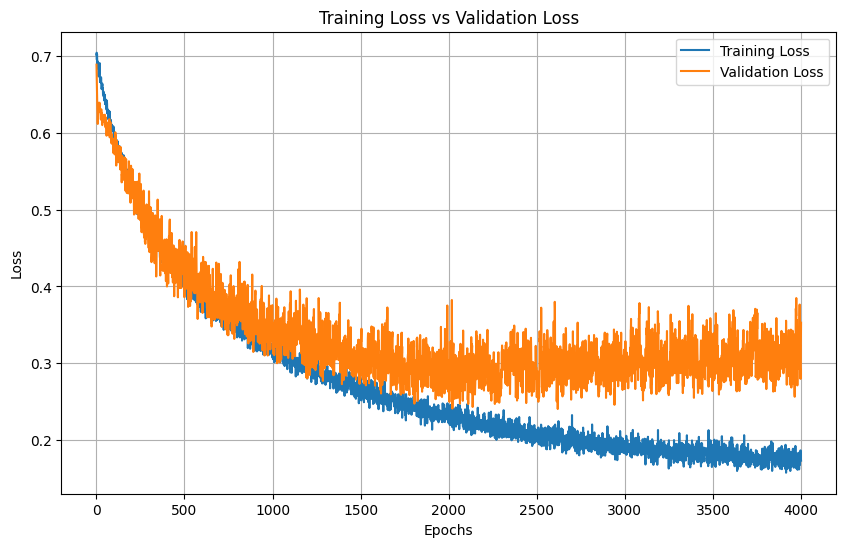

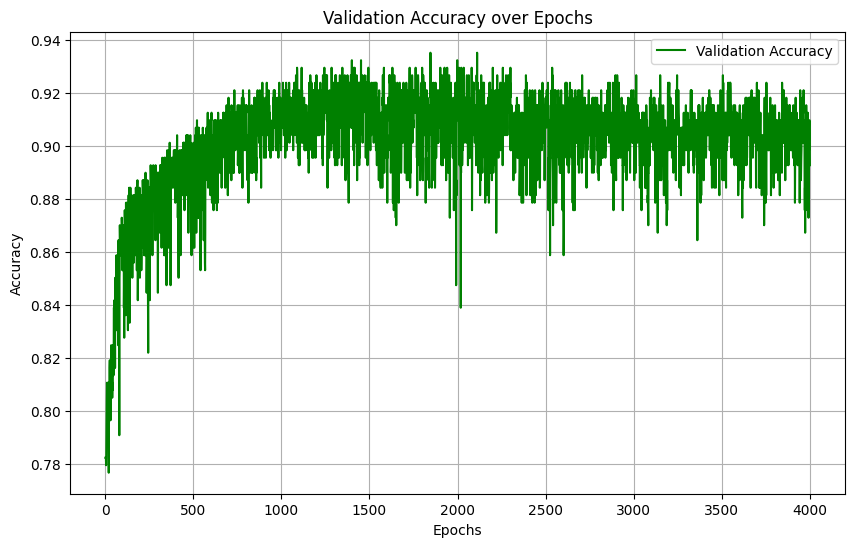

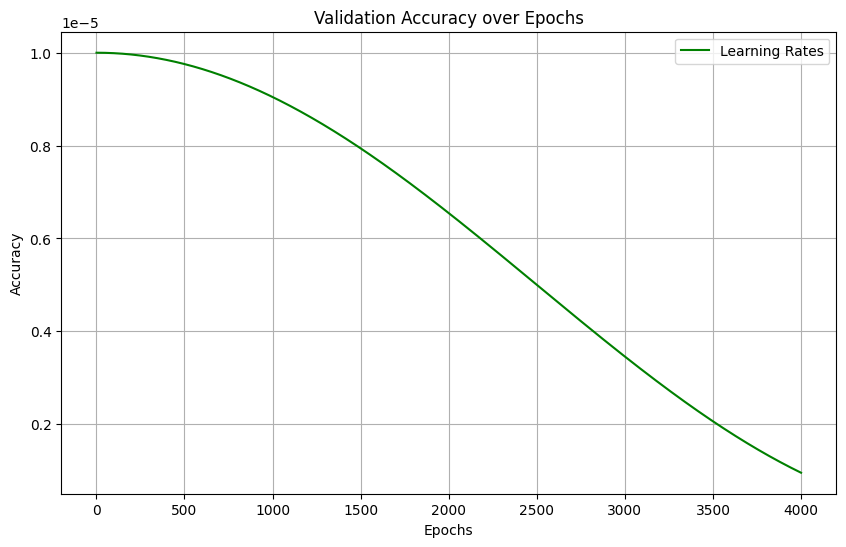

Model for bin 34 saved to GCNModels-5A_exp2/model_bin_34.pth
Training on bin 35/50
Bin 35, Epoch 1/4000, Train Loss: 0.7035, Validation Loss: 0.7175,  Accuracy: 0.2175, LR: 0.000010
Bin 35, Epoch 101/4000, Train Loss: 0.6498, Validation Loss: 0.6608,  Accuracy: 0.7345, LR: 0.000010
Bin 35, Epoch 201/4000, Train Loss: 0.6064, Validation Loss: 0.5898,  Accuracy: 0.8475, LR: 0.000010
Bin 35, Epoch 301/4000, Train Loss: 0.5657, Validation Loss: 0.5222,  Accuracy: 0.8729, LR: 0.000010
Bin 35, Epoch 401/4000, Train Loss: 0.5146, Validation Loss: 0.4627,  Accuracy: 0.8785, LR: 0.000010
Bin 35, Epoch 501/4000, Train Loss: 0.4953, Validation Loss: 0.4271,  Accuracy: 0.8814, LR: 0.000010
Bin 35, Epoch 601/4000, Train Loss: 0.4614, Validation Loss: 0.3702,  Accuracy: 0.9011, LR: 0.000010
Bin 35, Epoch 701/4000, Train Loss: 0.4541, Validation Loss: 0.3455,  Accuracy: 0.9011, LR: 0.000010
Bin 35, Epoch 801/4000, Train Loss: 0.4053, Validation Loss: 0.2891,  Accuracy: 0.9181, LR: 0.000009
Bin 35, Ep

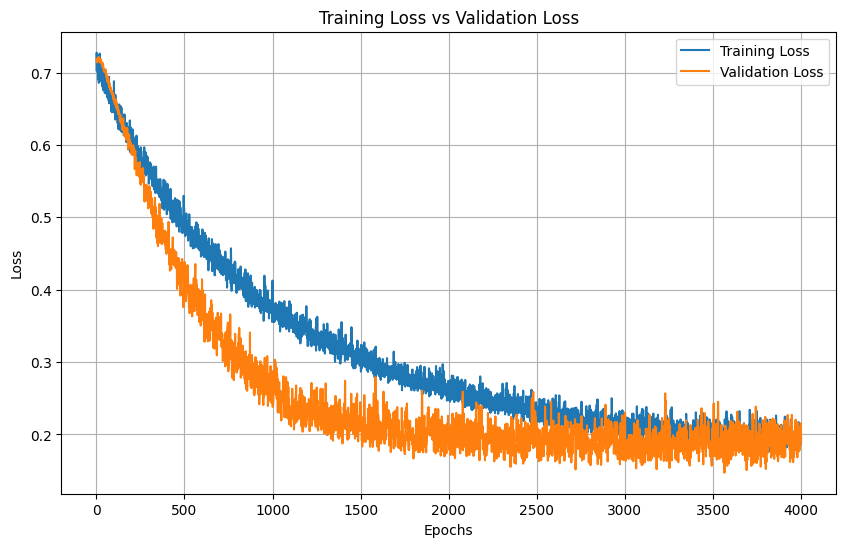

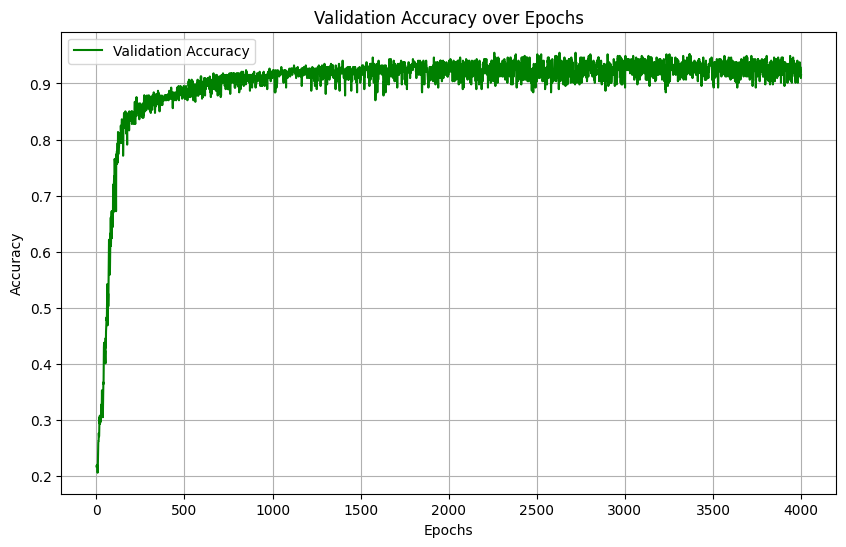

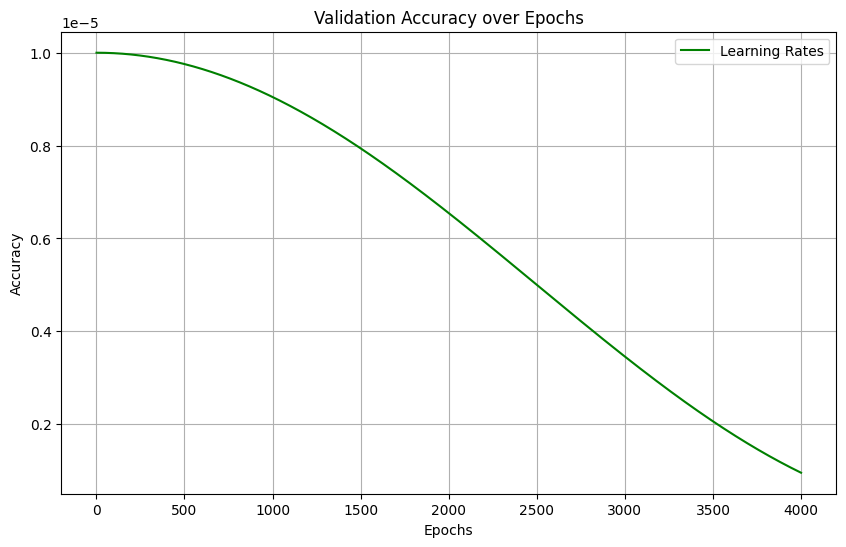

Model for bin 35 saved to GCNModels-5A_exp2/model_bin_35.pth
Training on bin 36/50
Bin 36, Epoch 1/4000, Train Loss: 0.6738, Validation Loss: 0.6844,  Accuracy: 0.7825, LR: 0.000010
Bin 36, Epoch 101/4000, Train Loss: 0.5908, Validation Loss: 0.6071,  Accuracy: 0.8644, LR: 0.000010
Bin 36, Epoch 201/4000, Train Loss: 0.5466, Validation Loss: 0.5288,  Accuracy: 0.8757, LR: 0.000010
Bin 36, Epoch 301/4000, Train Loss: 0.5015, Validation Loss: 0.4888,  Accuracy: 0.8785, LR: 0.000010
Bin 36, Epoch 401/4000, Train Loss: 0.4491, Validation Loss: 0.4114,  Accuracy: 0.9040, LR: 0.000010
Bin 36, Epoch 501/4000, Train Loss: 0.4161, Validation Loss: 0.3802,  Accuracy: 0.9153, LR: 0.000010
Bin 36, Epoch 601/4000, Train Loss: 0.4092, Validation Loss: 0.3333,  Accuracy: 0.9209, LR: 0.000010
Bin 36, Epoch 701/4000, Train Loss: 0.3744, Validation Loss: 0.2976,  Accuracy: 0.9350, LR: 0.000010
Bin 36, Epoch 801/4000, Train Loss: 0.3378, Validation Loss: 0.3159,  Accuracy: 0.9124, LR: 0.000009
Bin 36, Ep

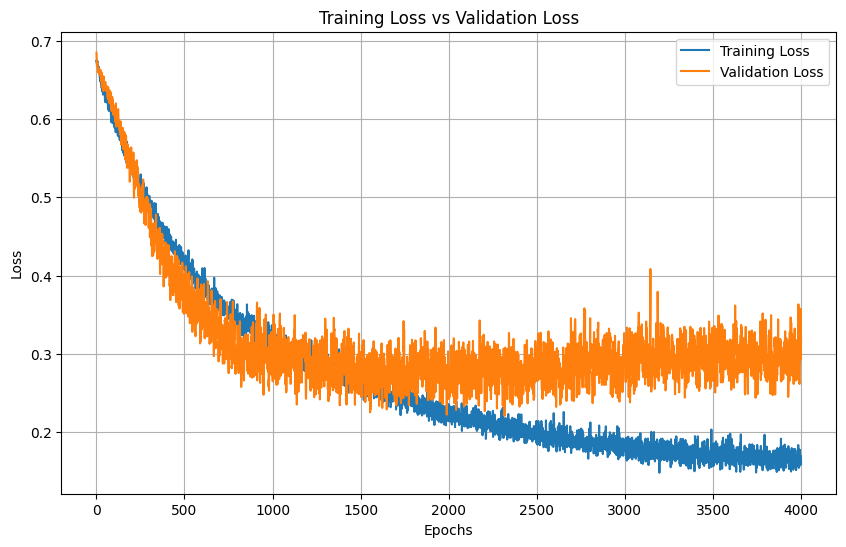

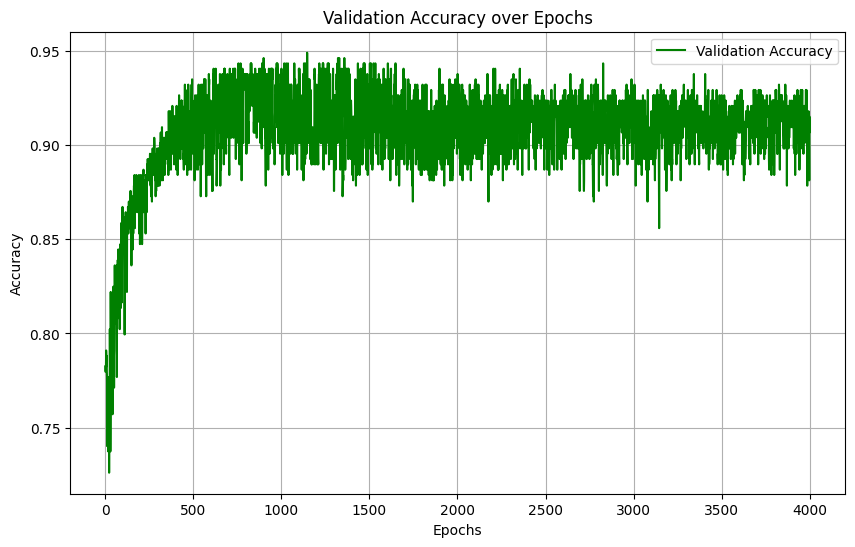

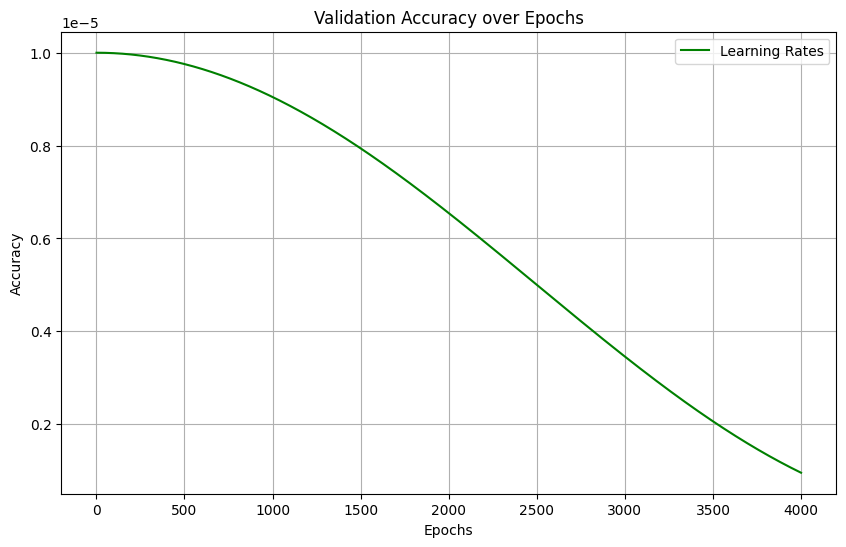

Model for bin 36 saved to GCNModels-5A_exp2/model_bin_36.pth
Training on bin 37/50
Bin 37, Epoch 1/4000, Train Loss: 0.7589, Validation Loss: 0.7131,  Accuracy: 0.2175, LR: 0.000010
Bin 37, Epoch 101/4000, Train Loss: 0.6229, Validation Loss: 0.6647,  Accuracy: 0.7627, LR: 0.000010
Bin 37, Epoch 201/4000, Train Loss: 0.5814, Validation Loss: 0.6128,  Accuracy: 0.8446, LR: 0.000010
Bin 37, Epoch 301/4000, Train Loss: 0.5290, Validation Loss: 0.5500,  Accuracy: 0.8842, LR: 0.000010
Bin 37, Epoch 401/4000, Train Loss: 0.4641, Validation Loss: 0.4960,  Accuracy: 0.8983, LR: 0.000010
Bin 37, Epoch 501/4000, Train Loss: 0.4626, Validation Loss: 0.4631,  Accuracy: 0.9011, LR: 0.000010
Bin 37, Epoch 601/4000, Train Loss: 0.4150, Validation Loss: 0.4238,  Accuracy: 0.9096, LR: 0.000010
Bin 37, Epoch 701/4000, Train Loss: 0.4031, Validation Loss: 0.4263,  Accuracy: 0.9153, LR: 0.000010
Bin 37, Epoch 801/4000, Train Loss: 0.3833, Validation Loss: 0.4054,  Accuracy: 0.9068, LR: 0.000009
Bin 37, Ep

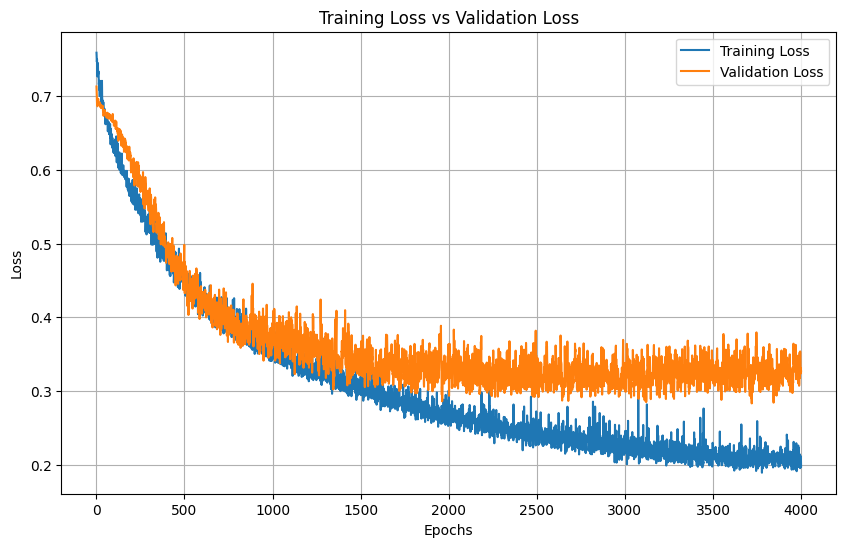

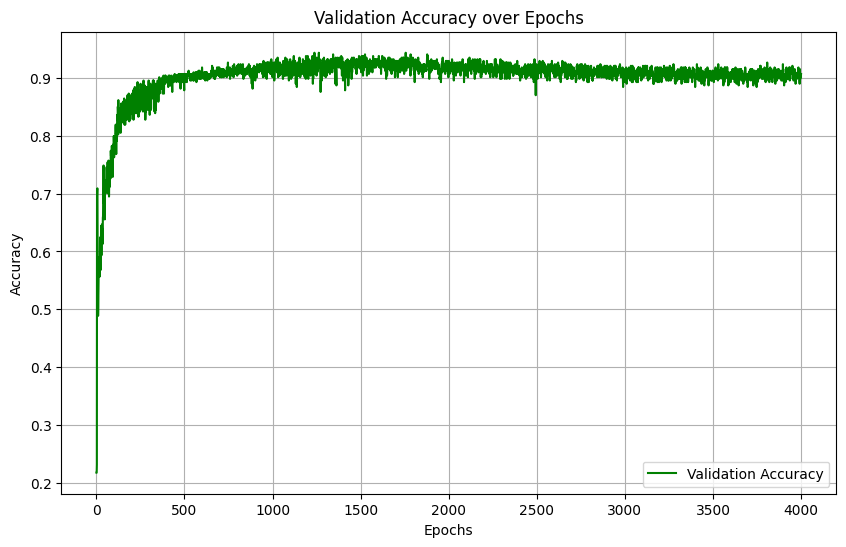

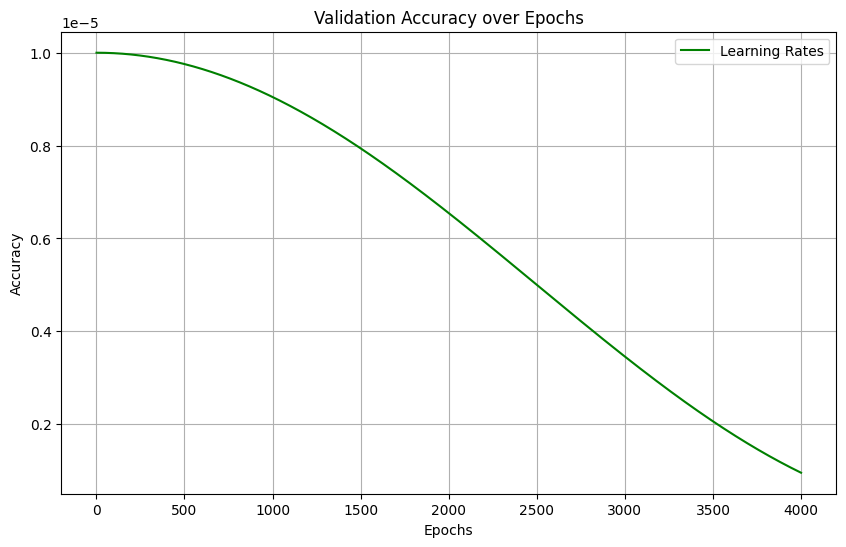

Model for bin 37 saved to GCNModels-5A_exp2/model_bin_37.pth
Training on bin 38/50
Bin 38, Epoch 1/4000, Train Loss: 0.7274, Validation Loss: 0.6861,  Accuracy: 0.7825, LR: 0.000010
Bin 38, Epoch 101/4000, Train Loss: 0.6380, Validation Loss: 0.6001,  Accuracy: 0.8503, LR: 0.000010
Bin 38, Epoch 201/4000, Train Loss: 0.5752, Validation Loss: 0.5477,  Accuracy: 0.8672, LR: 0.000010
Bin 38, Epoch 301/4000, Train Loss: 0.5360, Validation Loss: 0.4805,  Accuracy: 0.8955, LR: 0.000010
Bin 38, Epoch 401/4000, Train Loss: 0.4923, Validation Loss: 0.4350,  Accuracy: 0.8927, LR: 0.000010
Bin 38, Epoch 501/4000, Train Loss: 0.4579, Validation Loss: 0.3999,  Accuracy: 0.8898, LR: 0.000010
Bin 38, Epoch 601/4000, Train Loss: 0.4177, Validation Loss: 0.3348,  Accuracy: 0.9209, LR: 0.000010
Bin 38, Epoch 701/4000, Train Loss: 0.4003, Validation Loss: 0.3126,  Accuracy: 0.9181, LR: 0.000010
Bin 38, Epoch 801/4000, Train Loss: 0.3868, Validation Loss: 0.2834,  Accuracy: 0.9294, LR: 0.000009
Bin 38, Ep

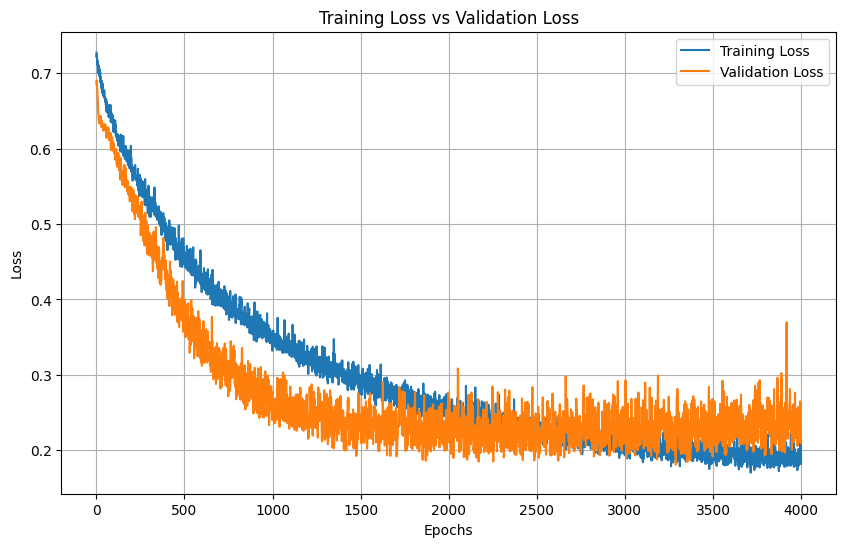

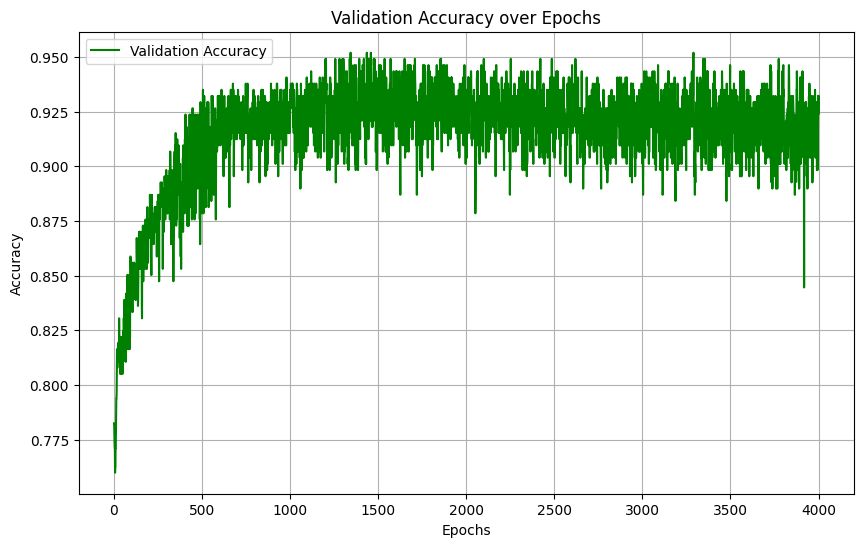

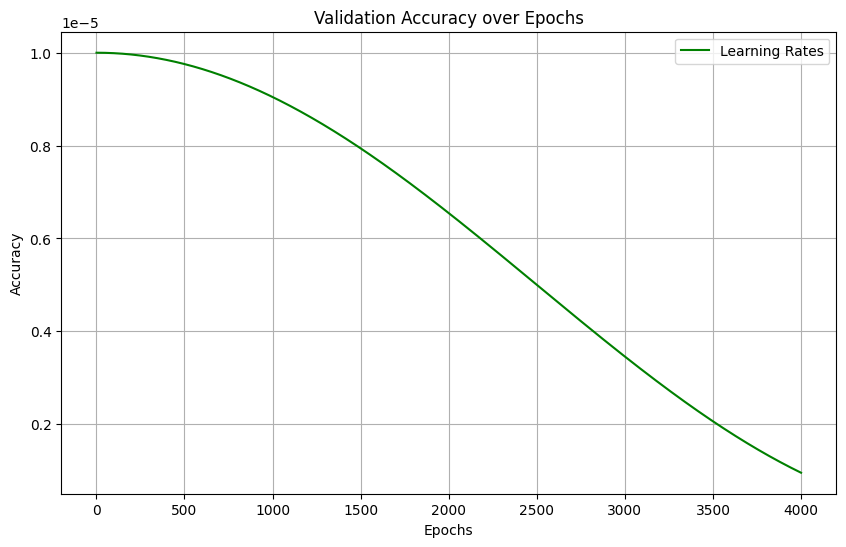

Model for bin 38 saved to GCNModels-5A_exp2/model_bin_38.pth
Training on bin 39/50
Bin 39, Epoch 1/4000, Train Loss: 0.7071, Validation Loss: 0.7283,  Accuracy: 0.2175, LR: 0.000010
Bin 39, Epoch 101/4000, Train Loss: 0.6029, Validation Loss: 0.6881,  Accuracy: 0.7175, LR: 0.000010
Bin 39, Epoch 201/4000, Train Loss: 0.5416, Validation Loss: 0.6374,  Accuracy: 0.8164, LR: 0.000010
Bin 39, Epoch 301/4000, Train Loss: 0.4893, Validation Loss: 0.5327,  Accuracy: 0.8870, LR: 0.000010
Bin 39, Epoch 401/4000, Train Loss: 0.4548, Validation Loss: 0.5213,  Accuracy: 0.8503, LR: 0.000010
Bin 39, Epoch 501/4000, Train Loss: 0.4326, Validation Loss: 0.4645,  Accuracy: 0.8757, LR: 0.000010
Bin 39, Epoch 601/4000, Train Loss: 0.3959, Validation Loss: 0.3813,  Accuracy: 0.9237, LR: 0.000010
Bin 39, Epoch 701/4000, Train Loss: 0.3637, Validation Loss: 0.4165,  Accuracy: 0.8898, LR: 0.000010
Bin 39, Epoch 801/4000, Train Loss: 0.3598, Validation Loss: 0.3907,  Accuracy: 0.8983, LR: 0.000009
Bin 39, Ep

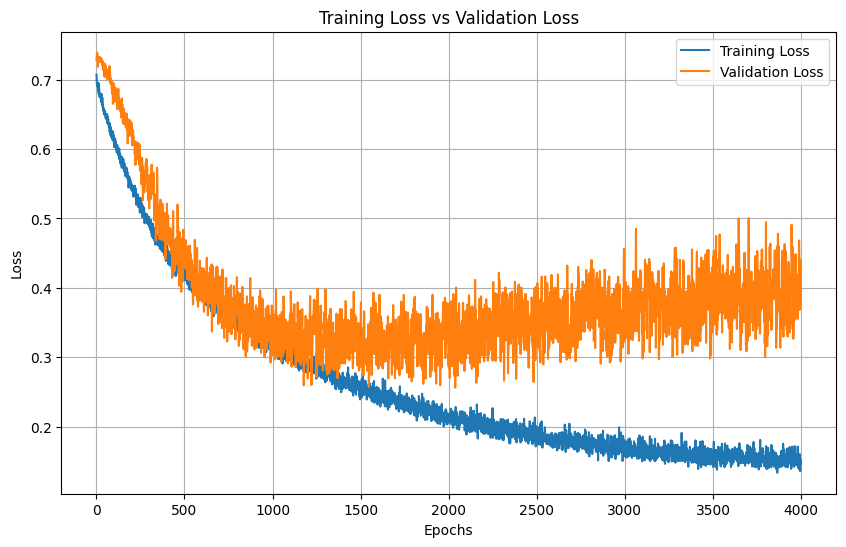

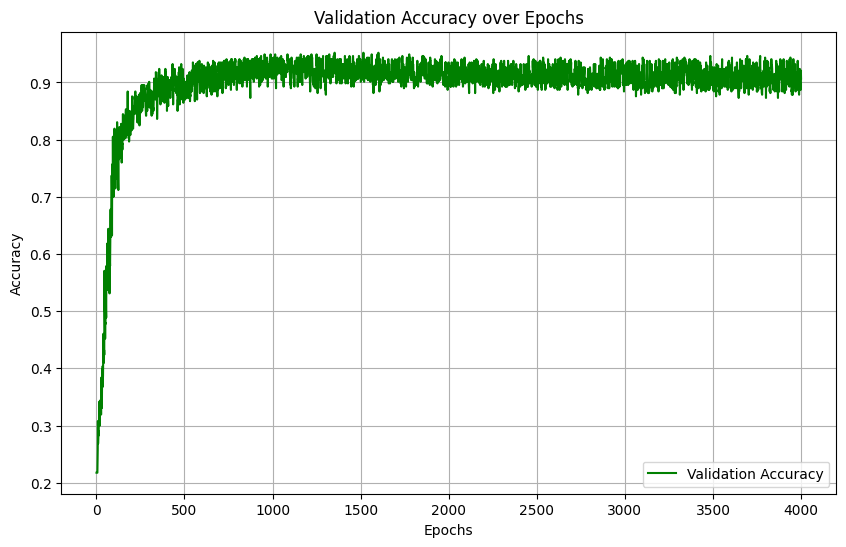

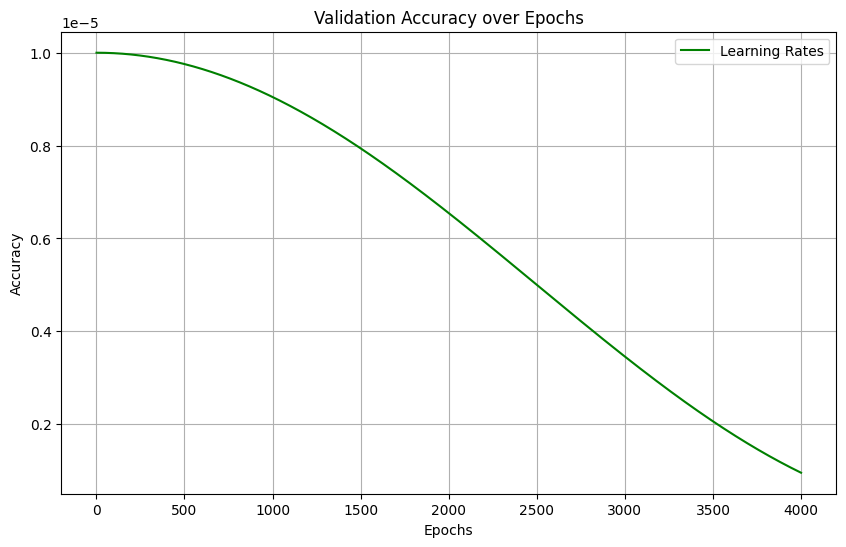

Model for bin 39 saved to GCNModels-5A_exp2/model_bin_39.pth
Training on bin 40/50
Bin 40, Epoch 1/4000, Train Loss: 0.6808, Validation Loss: 0.6671,  Accuracy: 0.7825, LR: 0.000010
Bin 40, Epoch 101/4000, Train Loss: 0.6172, Validation Loss: 0.6448,  Accuracy: 0.8023, LR: 0.000010
Bin 40, Epoch 201/4000, Train Loss: 0.5699, Validation Loss: 0.5921,  Accuracy: 0.8418, LR: 0.000010
Bin 40, Epoch 301/4000, Train Loss: 0.5224, Validation Loss: 0.5076,  Accuracy: 0.9011, LR: 0.000010
Bin 40, Epoch 401/4000, Train Loss: 0.4705, Validation Loss: 0.4625,  Accuracy: 0.9068, LR: 0.000010
Bin 40, Epoch 501/4000, Train Loss: 0.4281, Validation Loss: 0.4806,  Accuracy: 0.8644, LR: 0.000010
Bin 40, Epoch 601/4000, Train Loss: 0.4132, Validation Loss: 0.4052,  Accuracy: 0.9011, LR: 0.000010
Bin 40, Epoch 701/4000, Train Loss: 0.3882, Validation Loss: 0.4055,  Accuracy: 0.8898, LR: 0.000010
Bin 40, Epoch 801/4000, Train Loss: 0.3767, Validation Loss: 0.3500,  Accuracy: 0.9124, LR: 0.000009
Bin 40, Ep

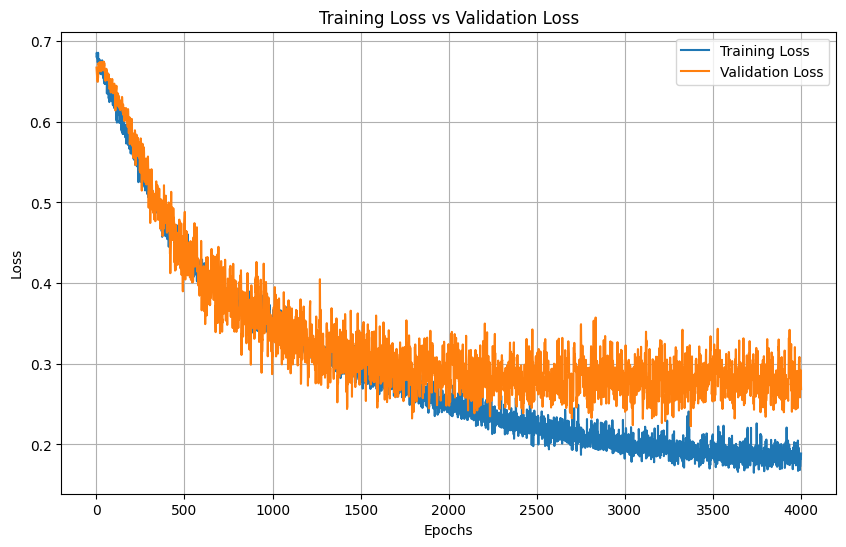

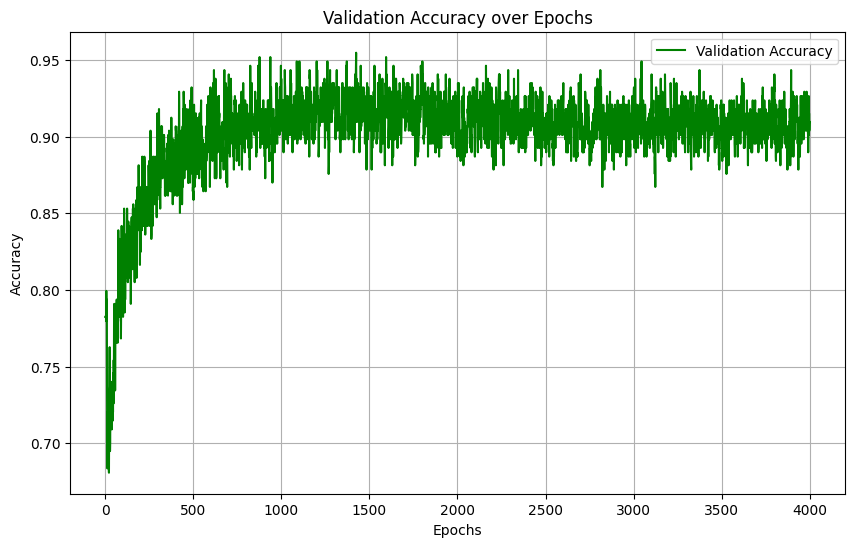

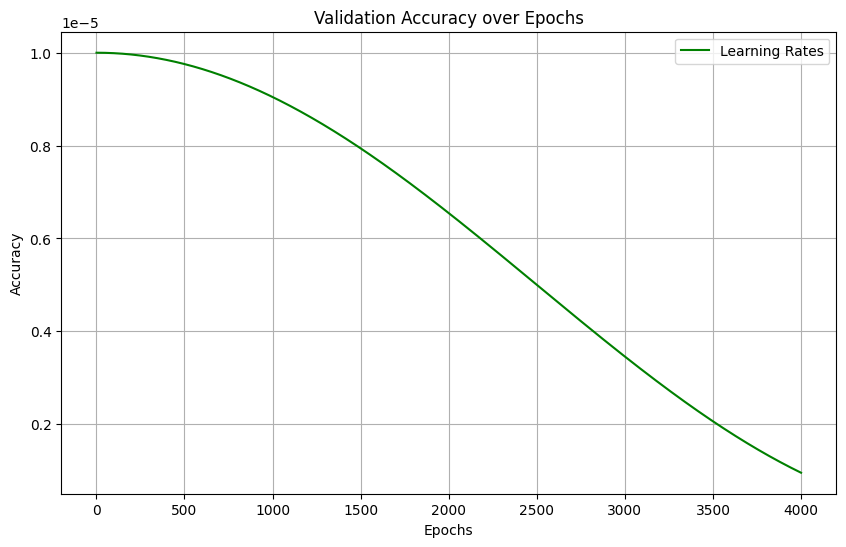

Model for bin 40 saved to GCNModels-5A_exp2/model_bin_40.pth
Training on bin 41/50
Bin 41, Epoch 1/4000, Train Loss: 0.6925, Validation Loss: 0.6810,  Accuracy: 0.7825, LR: 0.000010
Bin 41, Epoch 101/4000, Train Loss: 0.6375, Validation Loss: 0.6230,  Accuracy: 0.8192, LR: 0.000010
Bin 41, Epoch 201/4000, Train Loss: 0.5717, Validation Loss: 0.5741,  Accuracy: 0.8305, LR: 0.000010
Bin 41, Epoch 301/4000, Train Loss: 0.5362, Validation Loss: 0.5123,  Accuracy: 0.8616, LR: 0.000010
Bin 41, Epoch 401/4000, Train Loss: 0.4984, Validation Loss: 0.4501,  Accuracy: 0.8898, LR: 0.000010
Bin 41, Epoch 501/4000, Train Loss: 0.4590, Validation Loss: 0.4133,  Accuracy: 0.9124, LR: 0.000010
Bin 41, Epoch 601/4000, Train Loss: 0.4276, Validation Loss: 0.4185,  Accuracy: 0.8927, LR: 0.000010
Bin 41, Epoch 701/4000, Train Loss: 0.4048, Validation Loss: 0.3655,  Accuracy: 0.9181, LR: 0.000010
Bin 41, Epoch 801/4000, Train Loss: 0.3803, Validation Loss: 0.3347,  Accuracy: 0.9237, LR: 0.000009
Bin 41, Ep

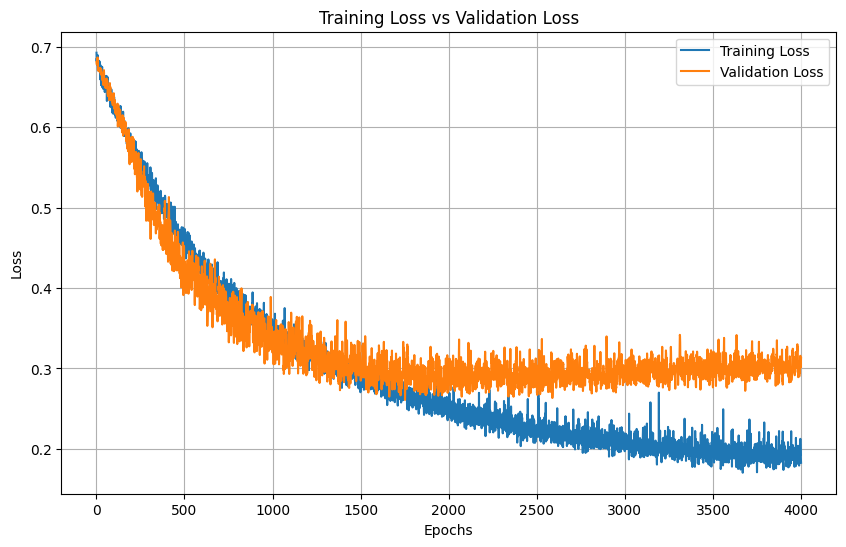

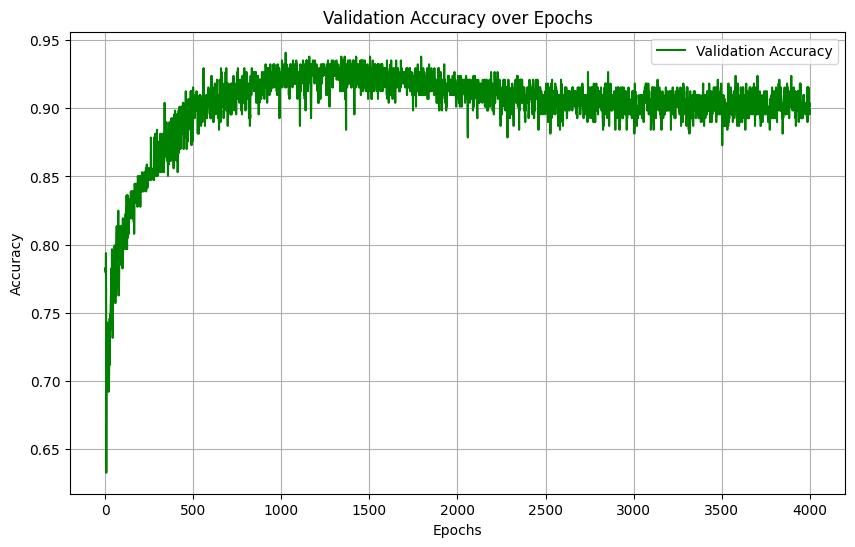

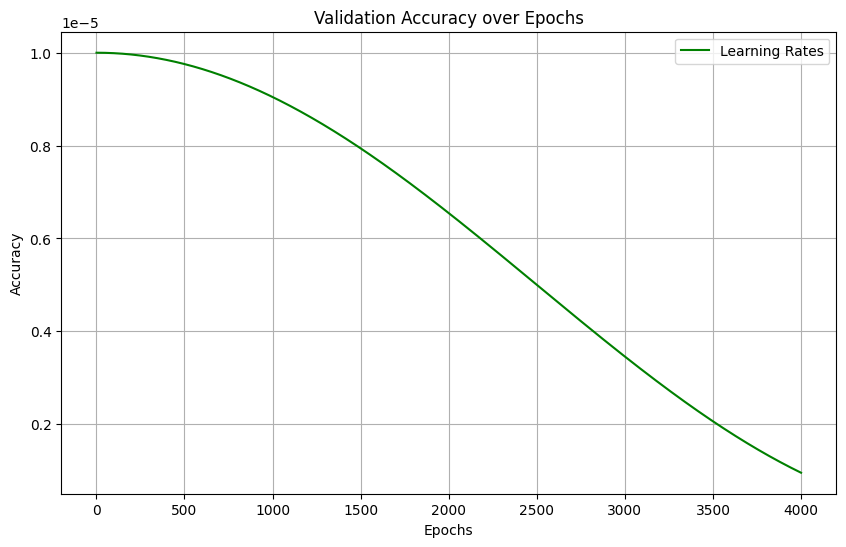

Model for bin 41 saved to GCNModels-5A_exp2/model_bin_41.pth
Training on bin 42/50
Bin 42, Epoch 1/4000, Train Loss: 0.7123, Validation Loss: 0.6565,  Accuracy: 0.7825, LR: 0.000010
Bin 42, Epoch 101/4000, Train Loss: 0.6459, Validation Loss: 0.6075,  Accuracy: 0.8446, LR: 0.000010
Bin 42, Epoch 201/4000, Train Loss: 0.5807, Validation Loss: 0.5690,  Accuracy: 0.8277, LR: 0.000010
Bin 42, Epoch 301/4000, Train Loss: 0.5443, Validation Loss: 0.4809,  Accuracy: 0.8757, LR: 0.000010
Bin 42, Epoch 401/4000, Train Loss: 0.4860, Validation Loss: 0.4519,  Accuracy: 0.8729, LR: 0.000010
Bin 42, Epoch 501/4000, Train Loss: 0.4790, Validation Loss: 0.3962,  Accuracy: 0.8955, LR: 0.000010
Bin 42, Epoch 601/4000, Train Loss: 0.4549, Validation Loss: 0.3361,  Accuracy: 0.9068, LR: 0.000010
Bin 42, Epoch 701/4000, Train Loss: 0.4174, Validation Loss: 0.3036,  Accuracy: 0.9209, LR: 0.000010
Bin 42, Epoch 801/4000, Train Loss: 0.3924, Validation Loss: 0.3068,  Accuracy: 0.9209, LR: 0.000009
Bin 42, Ep

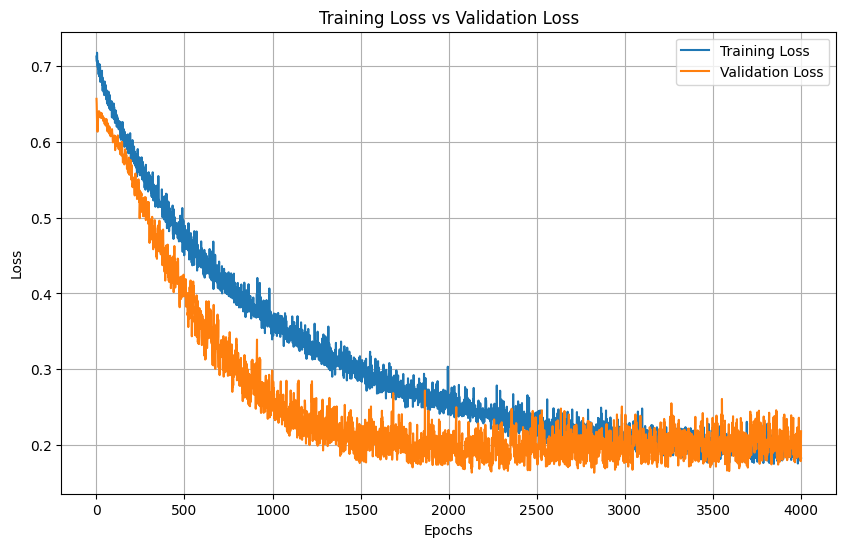

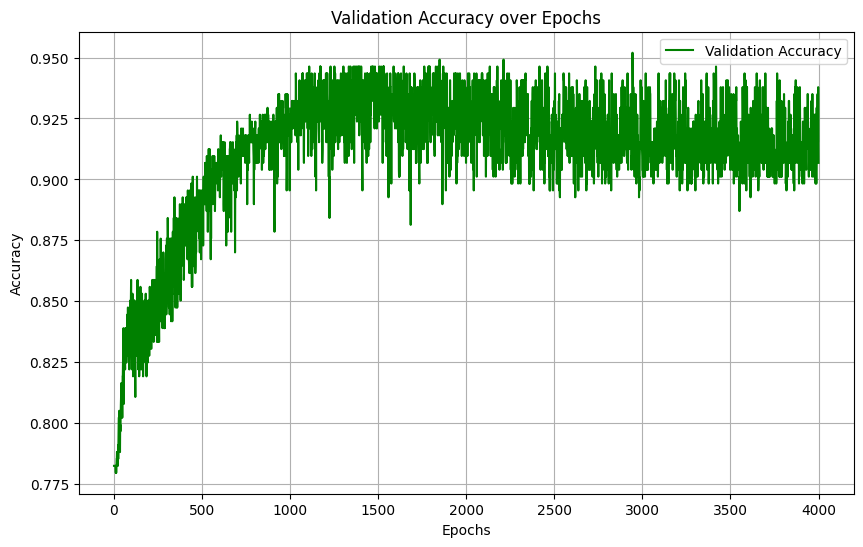

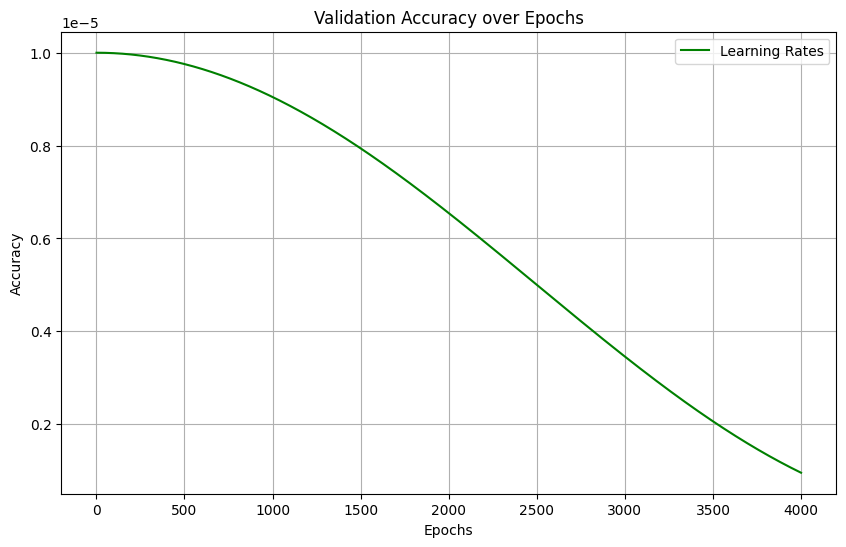

Model for bin 42 saved to GCNModels-5A_exp2/model_bin_42.pth
Training on bin 43/50
Bin 43, Epoch 1/4000, Train Loss: 0.7142, Validation Loss: 0.6916,  Accuracy: 0.7768, LR: 0.000010
Bin 43, Epoch 101/4000, Train Loss: 0.6292, Validation Loss: 0.6588,  Accuracy: 0.7345, LR: 0.000010
Bin 43, Epoch 201/4000, Train Loss: 0.5651, Validation Loss: 0.5742,  Accuracy: 0.8503, LR: 0.000010
Bin 43, Epoch 301/4000, Train Loss: 0.5147, Validation Loss: 0.5222,  Accuracy: 0.8418, LR: 0.000010
Bin 43, Epoch 401/4000, Train Loss: 0.4647, Validation Loss: 0.4859,  Accuracy: 0.8390, LR: 0.000010
Bin 43, Epoch 501/4000, Train Loss: 0.4287, Validation Loss: 0.4036,  Accuracy: 0.8616, LR: 0.000010
Bin 43, Epoch 601/4000, Train Loss: 0.4095, Validation Loss: 0.3805,  Accuracy: 0.8701, LR: 0.000010
Bin 43, Epoch 701/4000, Train Loss: 0.3679, Validation Loss: 0.3276,  Accuracy: 0.9068, LR: 0.000010
Bin 43, Epoch 801/4000, Train Loss: 0.3678, Validation Loss: 0.3368,  Accuracy: 0.8701, LR: 0.000009
Bin 43, Ep

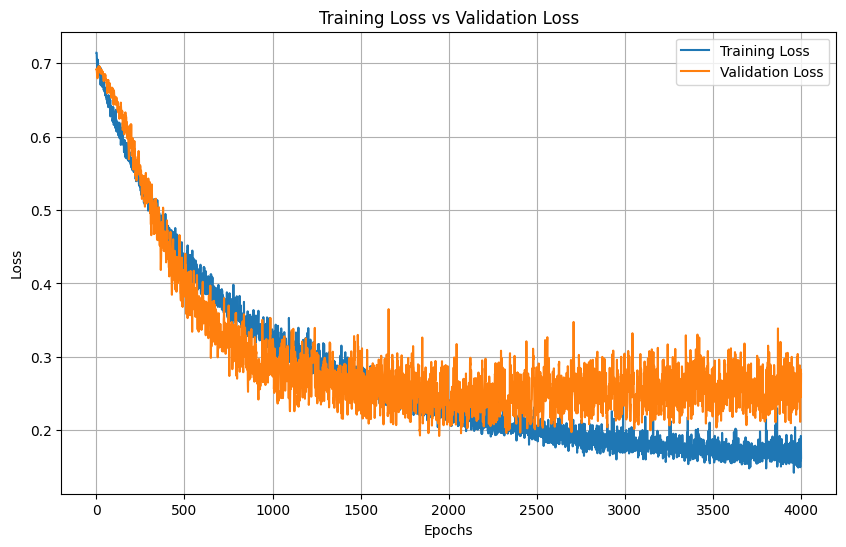

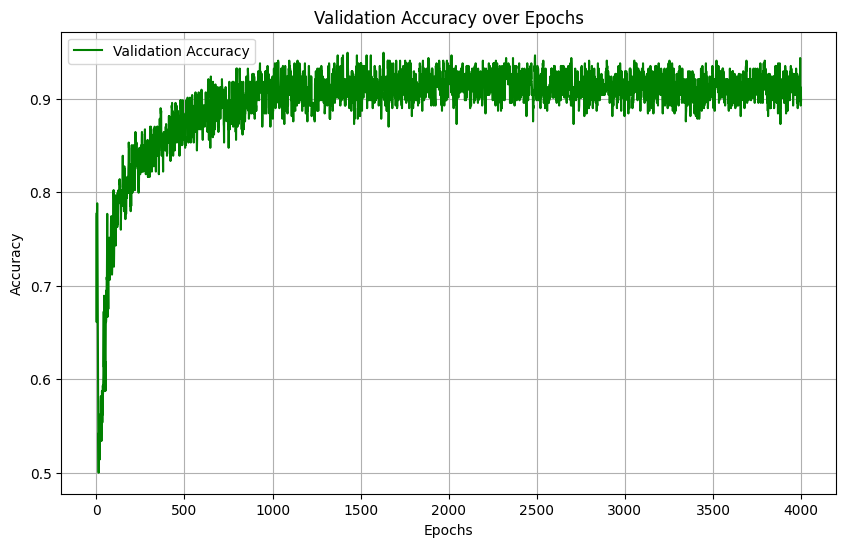

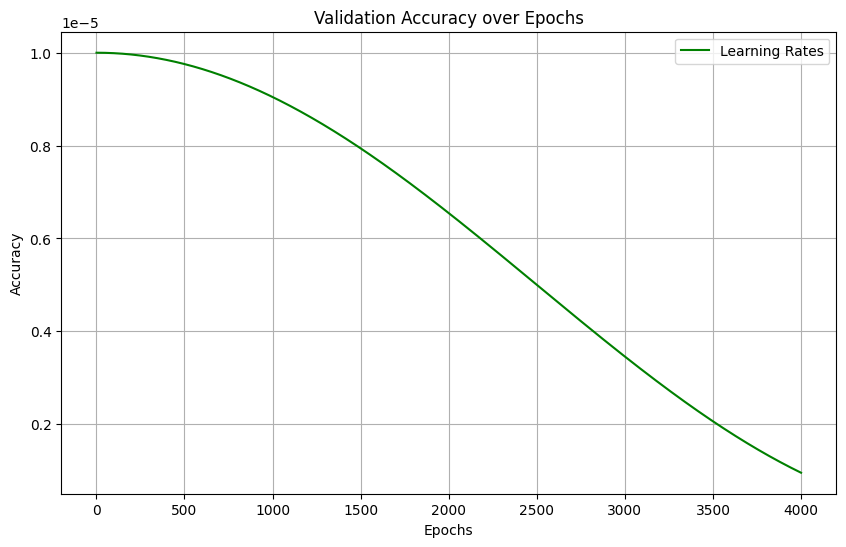

Model for bin 43 saved to GCNModels-5A_exp2/model_bin_43.pth
Training on bin 44/50
Bin 44, Epoch 1/4000, Train Loss: 0.6563, Validation Loss: 0.6583,  Accuracy: 0.7825, LR: 0.000010
Bin 44, Epoch 101/4000, Train Loss: 0.6125, Validation Loss: 0.6096,  Accuracy: 0.8559, LR: 0.000010
Bin 44, Epoch 201/4000, Train Loss: 0.5219, Validation Loss: 0.5280,  Accuracy: 0.8898, LR: 0.000010
Bin 44, Epoch 301/4000, Train Loss: 0.4747, Validation Loss: 0.5102,  Accuracy: 0.8927, LR: 0.000010
Bin 44, Epoch 401/4000, Train Loss: 0.4559, Validation Loss: 0.4687,  Accuracy: 0.9040, LR: 0.000010
Bin 44, Epoch 501/4000, Train Loss: 0.4234, Validation Loss: 0.4261,  Accuracy: 0.9237, LR: 0.000010
Bin 44, Epoch 601/4000, Train Loss: 0.4084, Validation Loss: 0.4227,  Accuracy: 0.9209, LR: 0.000010
Bin 44, Epoch 701/4000, Train Loss: 0.3999, Validation Loss: 0.4251,  Accuracy: 0.9153, LR: 0.000010
Bin 44, Epoch 801/4000, Train Loss: 0.3618, Validation Loss: 0.3600,  Accuracy: 0.9350, LR: 0.000009
Bin 44, Ep

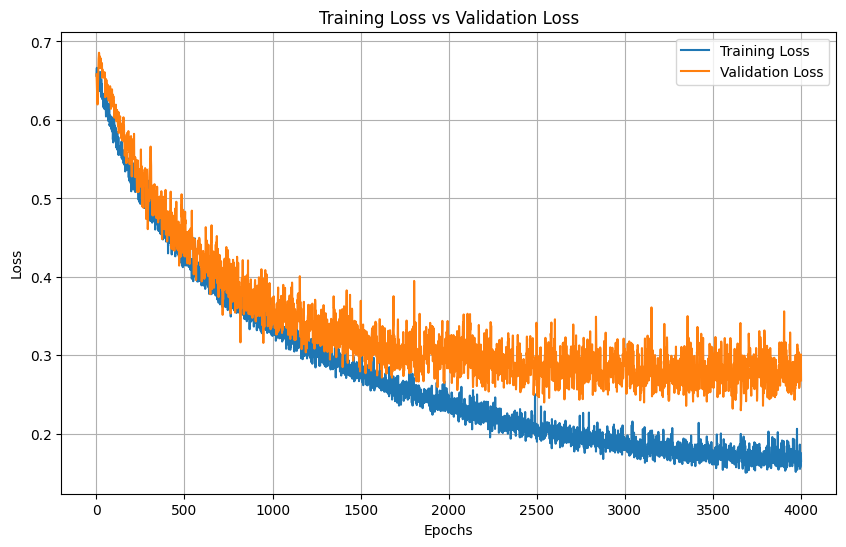

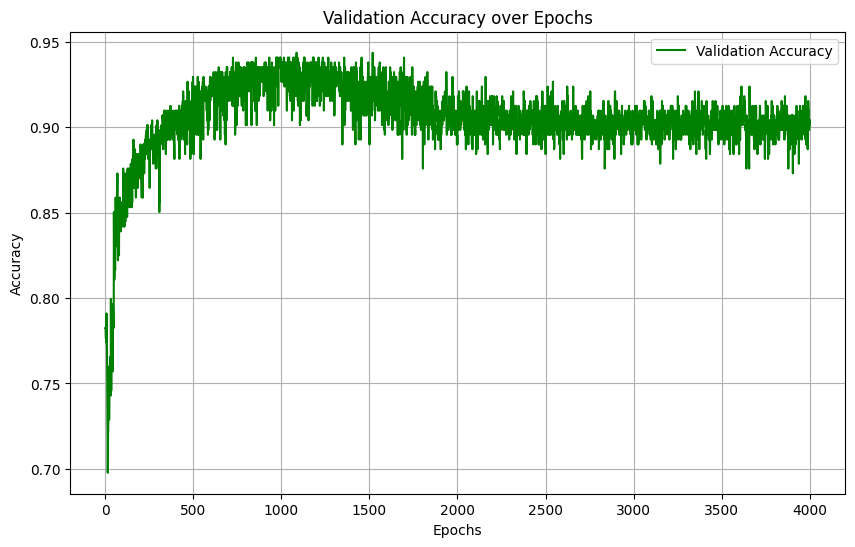

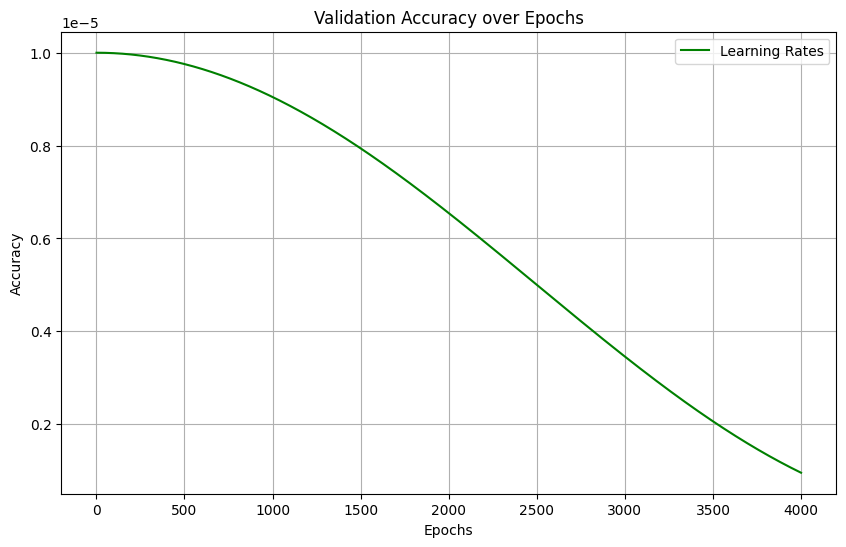

Model for bin 44 saved to GCNModels-5A_exp2/model_bin_44.pth
Training on bin 45/50
Bin 45, Epoch 1/4000, Train Loss: 0.7300, Validation Loss: 0.7038,  Accuracy: 0.2175, LR: 0.000010
Bin 45, Epoch 101/4000, Train Loss: 0.6240, Validation Loss: 0.6392,  Accuracy: 0.7966, LR: 0.000010
Bin 45, Epoch 201/4000, Train Loss: 0.5457, Validation Loss: 0.5613,  Accuracy: 0.8701, LR: 0.000010
Bin 45, Epoch 301/4000, Train Loss: 0.4878, Validation Loss: 0.4728,  Accuracy: 0.9011, LR: 0.000010
Bin 45, Epoch 401/4000, Train Loss: 0.4396, Validation Loss: 0.4266,  Accuracy: 0.9096, LR: 0.000010
Bin 45, Epoch 501/4000, Train Loss: 0.4047, Validation Loss: 0.3780,  Accuracy: 0.9181, LR: 0.000010
Bin 45, Epoch 601/4000, Train Loss: 0.3844, Validation Loss: 0.4234,  Accuracy: 0.8983, LR: 0.000010
Bin 45, Epoch 701/4000, Train Loss: 0.3544, Validation Loss: 0.4043,  Accuracy: 0.9124, LR: 0.000010
Bin 45, Epoch 801/4000, Train Loss: 0.3447, Validation Loss: 0.3712,  Accuracy: 0.9209, LR: 0.000009
Bin 45, Ep

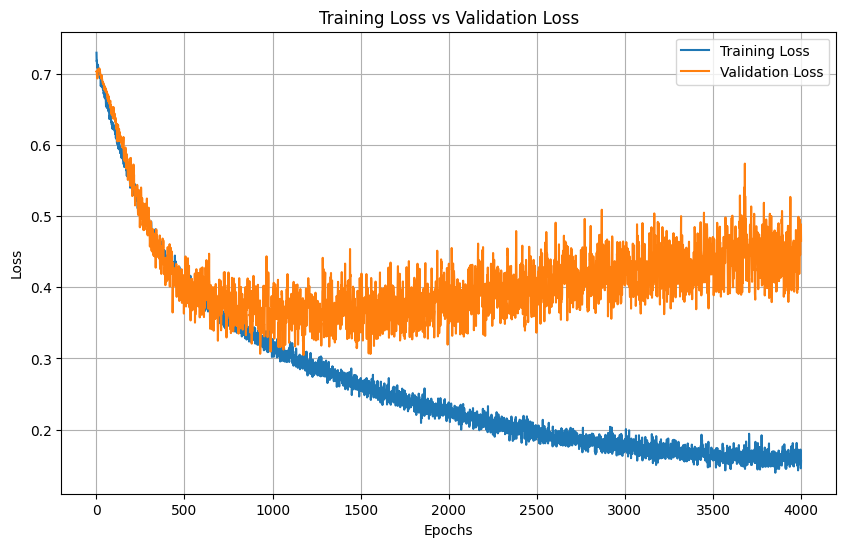

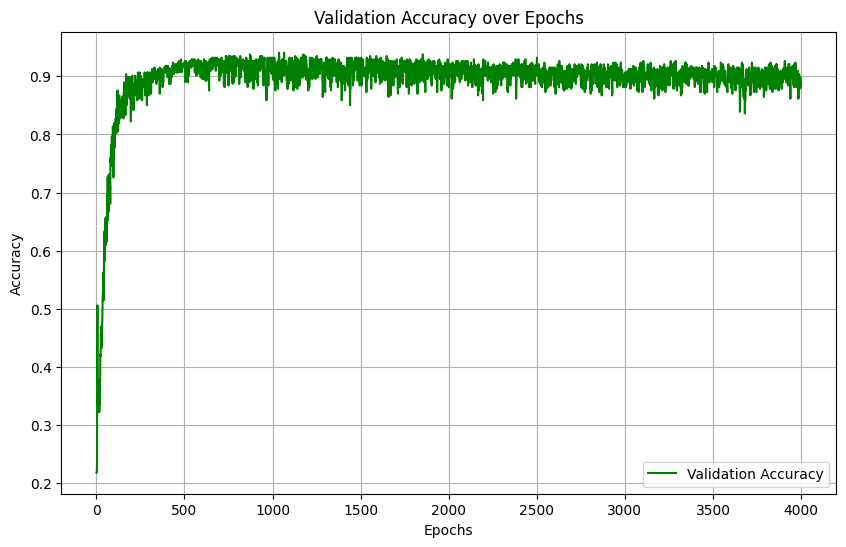

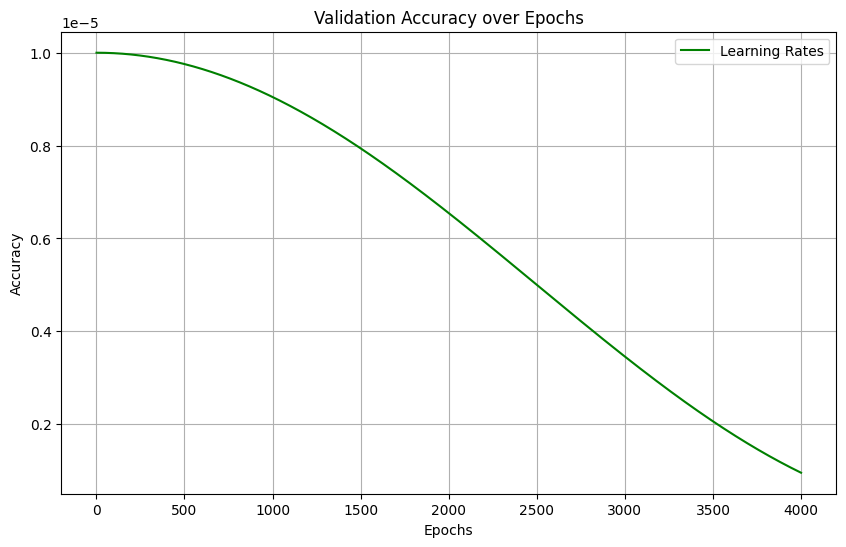

Model for bin 45 saved to GCNModels-5A_exp2/model_bin_45.pth
Training on bin 46/50
Bin 46, Epoch 1/4000, Train Loss: 0.6996, Validation Loss: 0.7093,  Accuracy: 0.2175, LR: 0.000010
Bin 46, Epoch 101/4000, Train Loss: 0.6390, Validation Loss: 0.6544,  Accuracy: 0.8249, LR: 0.000010
Bin 46, Epoch 201/4000, Train Loss: 0.5939, Validation Loss: 0.5868,  Accuracy: 0.8475, LR: 0.000010
Bin 46, Epoch 301/4000, Train Loss: 0.5516, Validation Loss: 0.5212,  Accuracy: 0.8616, LR: 0.000010
Bin 46, Epoch 401/4000, Train Loss: 0.4849, Validation Loss: 0.4479,  Accuracy: 0.8785, LR: 0.000010
Bin 46, Epoch 501/4000, Train Loss: 0.4683, Validation Loss: 0.3879,  Accuracy: 0.9040, LR: 0.000010
Bin 46, Epoch 601/4000, Train Loss: 0.4384, Validation Loss: 0.3759,  Accuracy: 0.9096, LR: 0.000010
Bin 46, Epoch 701/4000, Train Loss: 0.4030, Validation Loss: 0.3649,  Accuracy: 0.9096, LR: 0.000010
Bin 46, Epoch 801/4000, Train Loss: 0.4034, Validation Loss: 0.3209,  Accuracy: 0.9294, LR: 0.000009
Bin 46, Ep

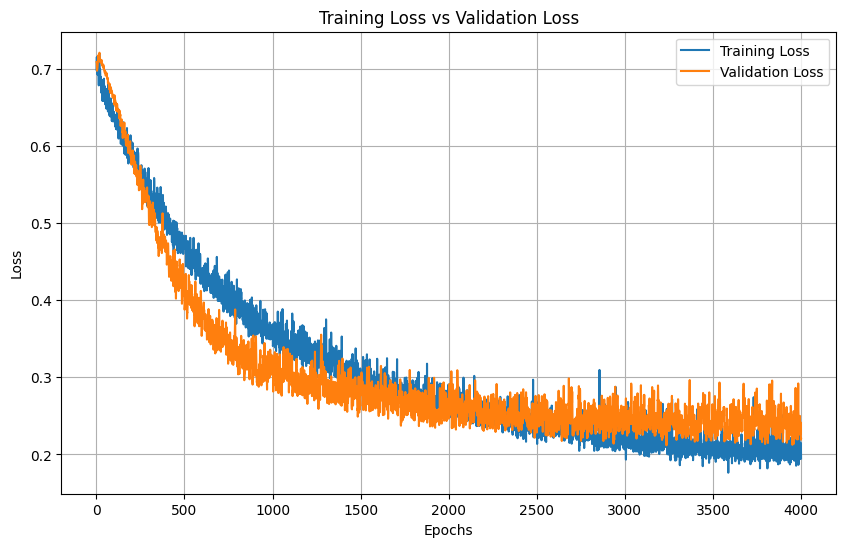

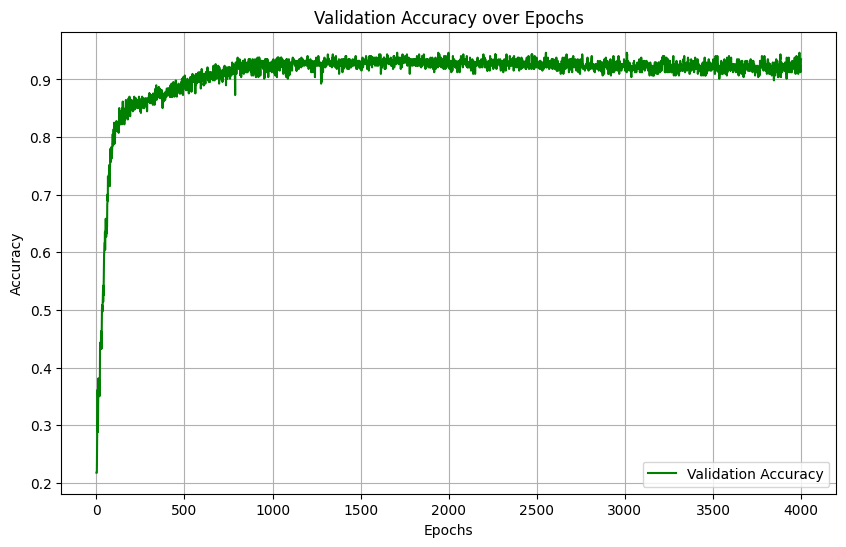

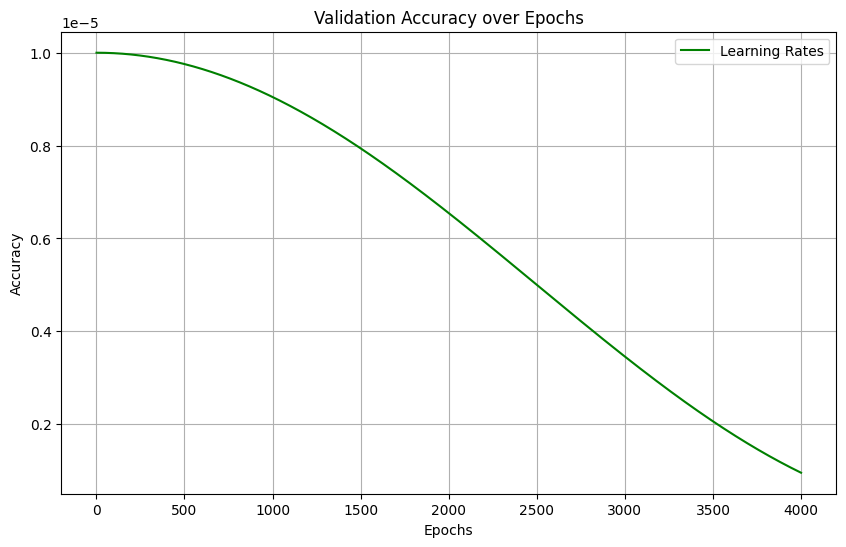

Model for bin 46 saved to GCNModels-5A_exp2/model_bin_46.pth
Training on bin 47/50
Bin 47, Epoch 1/4000, Train Loss: 0.6995, Validation Loss: 0.6867,  Accuracy: 0.7825, LR: 0.000010
Bin 47, Epoch 101/4000, Train Loss: 0.6219, Validation Loss: 0.6261,  Accuracy: 0.8390, LR: 0.000010
Bin 47, Epoch 201/4000, Train Loss: 0.5870, Validation Loss: 0.5669,  Accuracy: 0.8588, LR: 0.000010
Bin 47, Epoch 301/4000, Train Loss: 0.5336, Validation Loss: 0.4700,  Accuracy: 0.9011, LR: 0.000010
Bin 47, Epoch 401/4000, Train Loss: 0.4916, Validation Loss: 0.4370,  Accuracy: 0.9040, LR: 0.000010
Bin 47, Epoch 501/4000, Train Loss: 0.4761, Validation Loss: 0.3818,  Accuracy: 0.9040, LR: 0.000010
Bin 47, Epoch 601/4000, Train Loss: 0.4416, Validation Loss: 0.3204,  Accuracy: 0.9209, LR: 0.000010
Bin 47, Epoch 701/4000, Train Loss: 0.4270, Validation Loss: 0.3323,  Accuracy: 0.8983, LR: 0.000010
Bin 47, Epoch 801/4000, Train Loss: 0.3942, Validation Loss: 0.2540,  Accuracy: 0.9181, LR: 0.000009
Bin 47, Ep

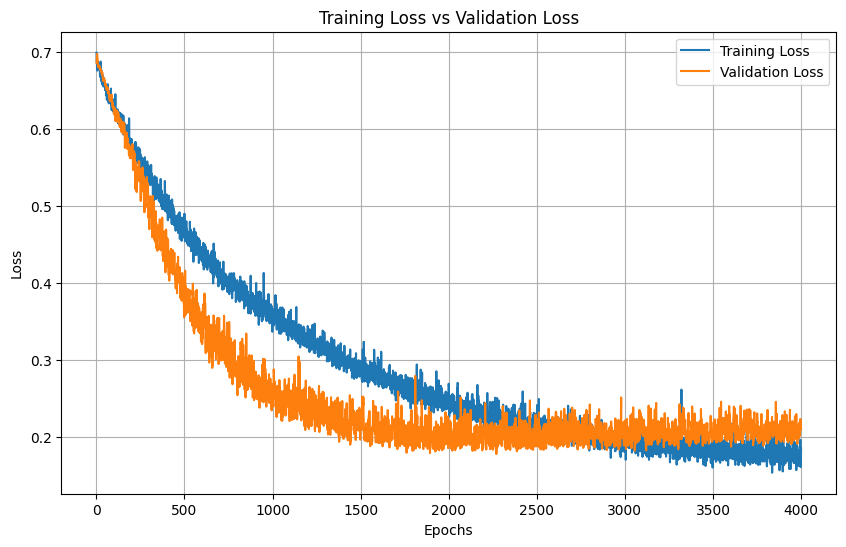

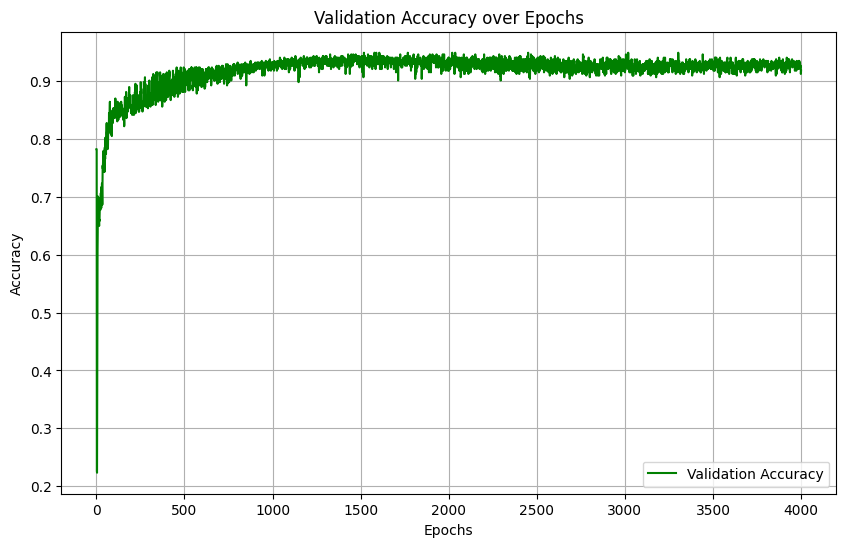

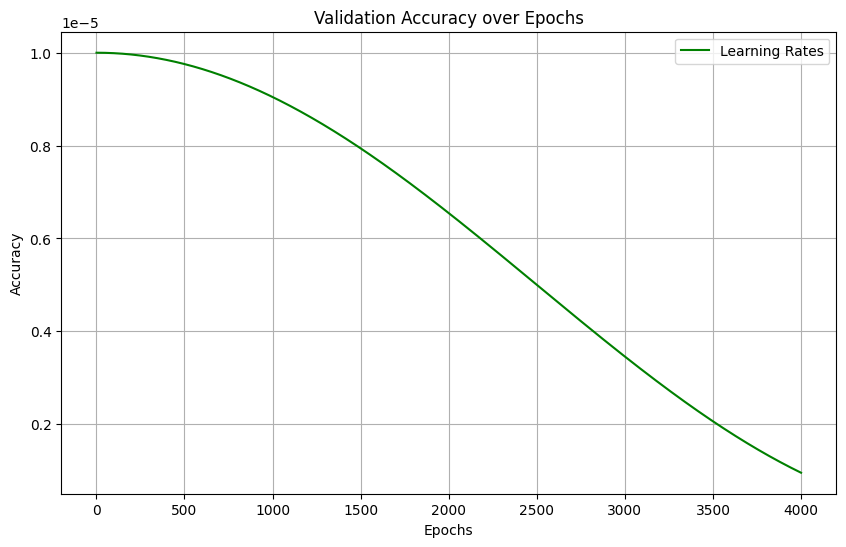

Model for bin 47 saved to GCNModels-5A_exp2/model_bin_47.pth
Training on bin 48/50
Bin 48, Epoch 1/4000, Train Loss: 0.6973, Validation Loss: 0.7286,  Accuracy: 0.2175, LR: 0.000010
Bin 48, Epoch 101/4000, Train Loss: 0.6285, Validation Loss: 0.6606,  Accuracy: 0.7034, LR: 0.000010
Bin 48, Epoch 201/4000, Train Loss: 0.5653, Validation Loss: 0.5862,  Accuracy: 0.8277, LR: 0.000010
Bin 48, Epoch 301/4000, Train Loss: 0.5188, Validation Loss: 0.5196,  Accuracy: 0.8390, LR: 0.000010
Bin 48, Epoch 401/4000, Train Loss: 0.5129, Validation Loss: 0.4226,  Accuracy: 0.8757, LR: 0.000010
Bin 48, Epoch 501/4000, Train Loss: 0.4713, Validation Loss: 0.4204,  Accuracy: 0.8898, LR: 0.000010
Bin 48, Epoch 601/4000, Train Loss: 0.4394, Validation Loss: 0.4205,  Accuracy: 0.8785, LR: 0.000010
Bin 48, Epoch 701/4000, Train Loss: 0.4124, Validation Loss: 0.3656,  Accuracy: 0.9011, LR: 0.000010
Bin 48, Epoch 801/4000, Train Loss: 0.3902, Validation Loss: 0.3534,  Accuracy: 0.9096, LR: 0.000009
Bin 48, Ep

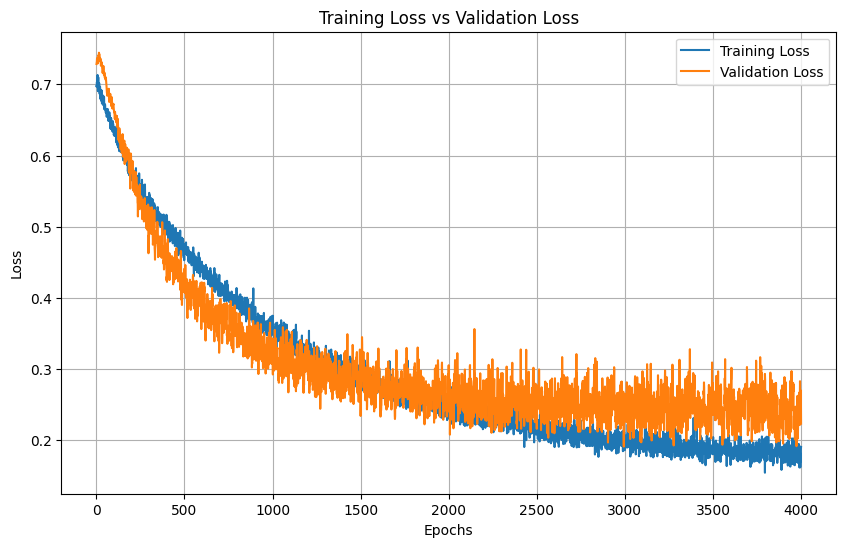

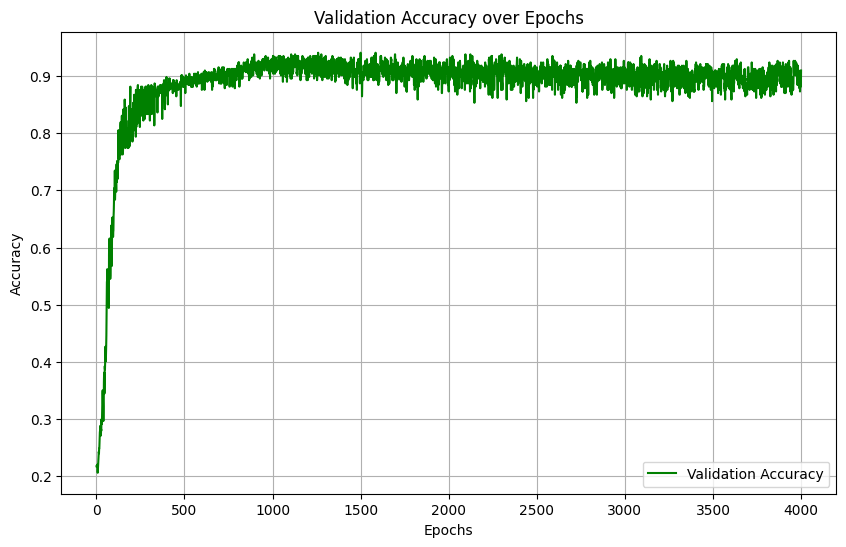

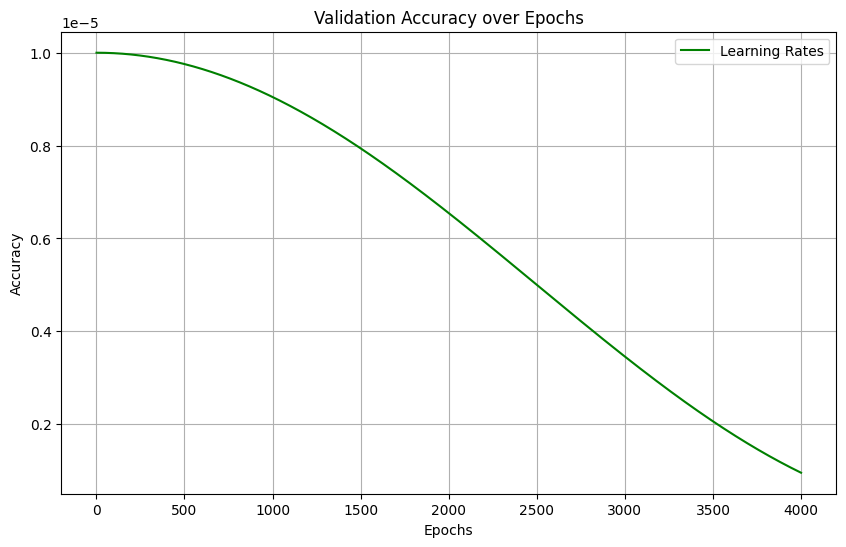

Model for bin 48 saved to GCNModels-5A_exp2/model_bin_48.pth
Training on bin 49/50
Bin 49, Epoch 1/4000, Train Loss: 0.6968, Validation Loss: 0.7226,  Accuracy: 0.2175, LR: 0.000010
Bin 49, Epoch 101/4000, Train Loss: 0.6500, Validation Loss: 0.6599,  Accuracy: 0.7006, LR: 0.000010
Bin 49, Epoch 201/4000, Train Loss: 0.5969, Validation Loss: 0.5953,  Accuracy: 0.8107, LR: 0.000010
Bin 49, Epoch 301/4000, Train Loss: 0.5557, Validation Loss: 0.5221,  Accuracy: 0.8390, LR: 0.000010
Bin 49, Epoch 401/4000, Train Loss: 0.5137, Validation Loss: 0.4508,  Accuracy: 0.8672, LR: 0.000010
Bin 49, Epoch 501/4000, Train Loss: 0.4753, Validation Loss: 0.3970,  Accuracy: 0.8870, LR: 0.000010
Bin 49, Epoch 601/4000, Train Loss: 0.4497, Validation Loss: 0.3864,  Accuracy: 0.8757, LR: 0.000010
Bin 49, Epoch 701/4000, Train Loss: 0.4196, Validation Loss: 0.3456,  Accuracy: 0.8898, LR: 0.000010
Bin 49, Epoch 801/4000, Train Loss: 0.4047, Validation Loss: 0.3059,  Accuracy: 0.9096, LR: 0.000009
Bin 49, Ep

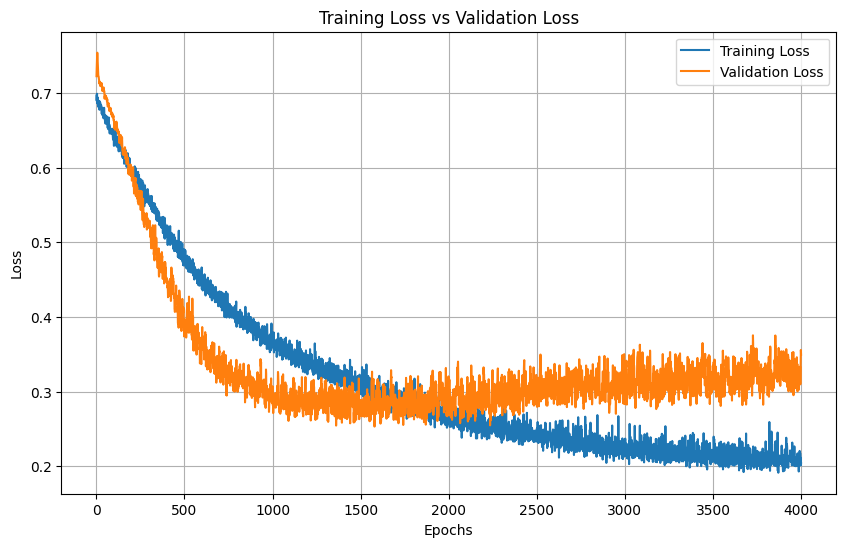

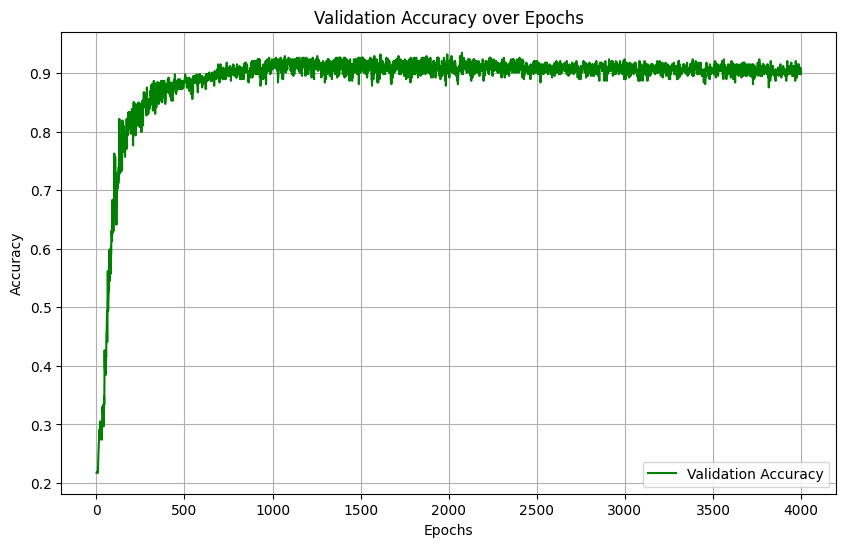

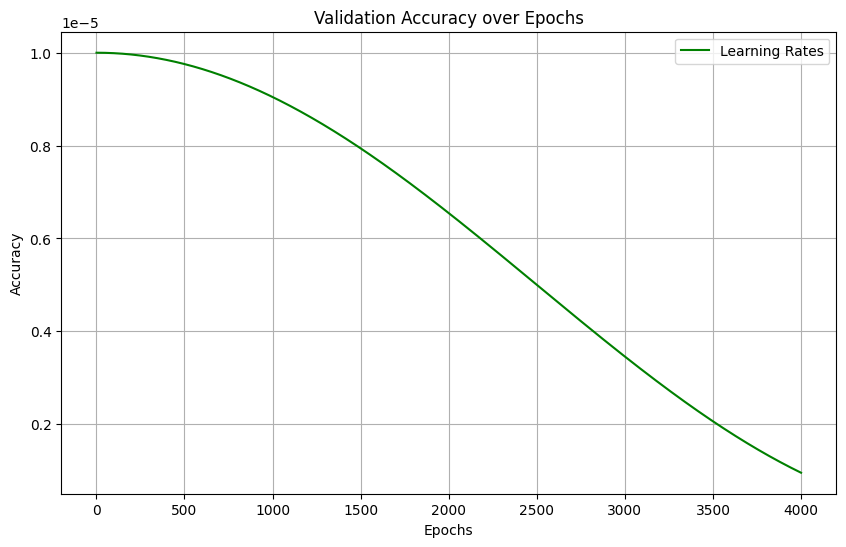

Model for bin 49 saved to GCNModels-5A_exp2/model_bin_49.pth
Training on bin 50/50
Bin 50, Epoch 1/4000, Train Loss: 0.6951, Validation Loss: 0.6828,  Accuracy: 0.7797, LR: 0.000010
Bin 50, Epoch 101/4000, Train Loss: 0.6267, Validation Loss: 0.6501,  Accuracy: 0.7429, LR: 0.000010
Bin 50, Epoch 201/4000, Train Loss: 0.5479, Validation Loss: 0.5534,  Accuracy: 0.8588, LR: 0.000010
Bin 50, Epoch 301/4000, Train Loss: 0.5216, Validation Loss: 0.4825,  Accuracy: 0.8814, LR: 0.000010
Bin 50, Epoch 401/4000, Train Loss: 0.4817, Validation Loss: 0.4271,  Accuracy: 0.8927, LR: 0.000010
Bin 50, Epoch 501/4000, Train Loss: 0.4512, Validation Loss: 0.3901,  Accuracy: 0.8955, LR: 0.000010
Bin 50, Epoch 601/4000, Train Loss: 0.4240, Validation Loss: 0.3600,  Accuracy: 0.9040, LR: 0.000010
Bin 50, Epoch 701/4000, Train Loss: 0.3805, Validation Loss: 0.2898,  Accuracy: 0.9237, LR: 0.000010
Bin 50, Epoch 801/4000, Train Loss: 0.3724, Validation Loss: 0.2737,  Accuracy: 0.9379, LR: 0.000009
Bin 50, Ep

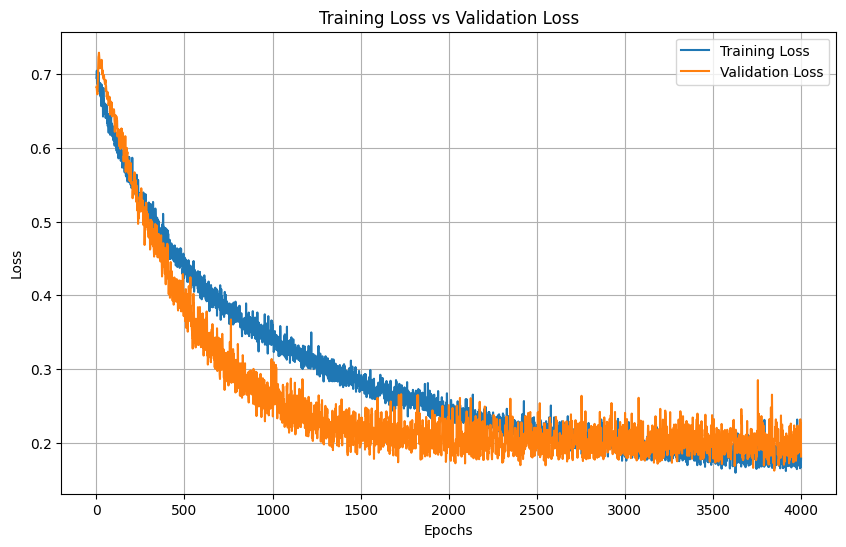

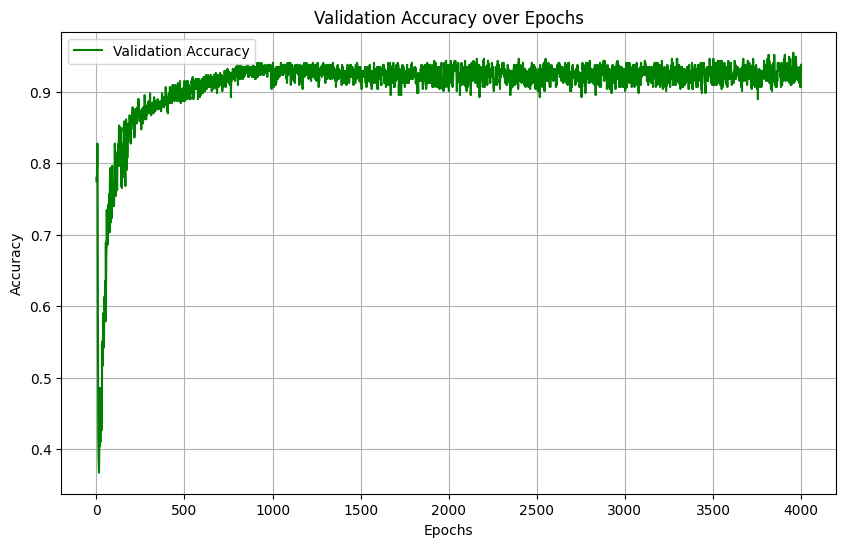

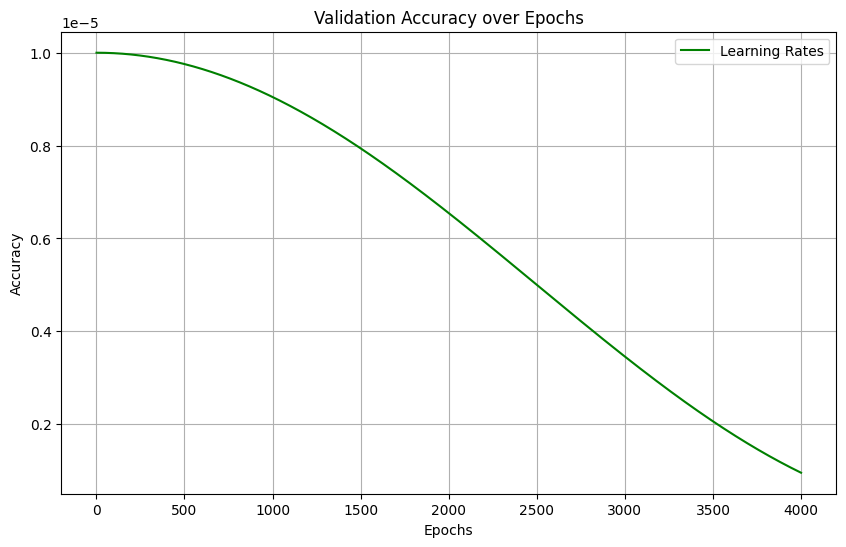

Model for bin 50 saved to GCNModels-5A_exp2/model_bin_50.pth
Training complete.


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
criterion = nn.BCEWithLogitsLoss()

# Define paths for saving models
save_dir = "GCNModels-5A_exp2"
os.makedirs(f"{save_dir}/Models", exist_ok=True)

# Training loop
epochs = 4000
batch_size = 128

# keep 10 positives and 10 negatives for validation data
val_loader = DataLoader(validation_graphs, batch_size=batch_size, shuffle=False)

for i in range(0, len(bins)):
    model = GCN(input_dim=37).to(device)
    optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4) 
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=5000, eta_min=1e-10)

    print(f"Training on bin {i+1}/{len(bins)}")
    train_loader = DataLoader(bins[i], batch_size=batch_size, shuffle=True)    

    train_losses = []
    learning_rates = []
    validation_losses = []
    validation_accuracies = []

    for epoch in range(epochs):
        epoch_loss, accuracy = train_model(model, train_loader, criterion, optimizer, device)
        validation_loss, validation_accuracy = validate_model(model, val_loader, criterion, device)
        current_lr = optimizer.param_groups[0]['lr'] 
        train_losses.append(epoch_loss)
        learning_rates.append(current_lr)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)   
        if epoch % 100 == 0:
            print(
                f"Bin {i+1}, Epoch {epoch+1}/{epochs}, "
                f"Train Loss: {epoch_loss:.4f}, Validation Loss: {validation_loss:.4f},  "
                f"Accuracy: {validation_accuracy:.4f}, "
                f"LR: {current_lr:.6f}"
            )

        scheduler.step()

    plot_graphs(train_losses, validation_losses, validation_accuracies, learning_rates)
    
    #Save the trained model
    model_path = os.path.join(save_dir, f"model_bin_{i+1}.pth")
    torch.save(model.state_dict(), model_path)
    print(f"Model for bin {i+1} saved to {model_path}")

print("Training complete.")